# **Multiple Models ML Threshold Synthetic Cross Validation**

## *1. Dataset Loading and Preprocessing*

### **1.1. Importing Required Libraries**

- Pathlib, os, shutil: These are used for handling file paths and directory manipulations. shutil is helpful in copying or moving files.
- NumPy: Essential for handling large arrays and numerical operations.
- Matplotlib, Seaborn: For data visualization. matplotlib.pyplot helps create various plots, and seaborn offers more advanced visualizations, typically with a higher-level API.
- Pandas: For data manipulation, especially working with tabular data. pandas.DataFrame is extensively used for loading, modifying, and analyzing datasets.
- Pickle: For serializing Python objects, commonly used to save/load objects such as models and dataframes.
- PIL (Python Imaging Library): For handling image data, including reading, processing, and transforming images.
- TQDM: For displaying progress bars when running loops, typically useful for large datasets or long-running operations.
- PyTorch & torchvision: Essential libraries for building and training deep learning models. torch.utils.data.DataLoader is for batching and loading datasets, torchvision.datasets provides utilities for image datasets, and torch.optim contains optimization algorithms.
- scikit-learn: Specifically, StandardScaler for feature scaling, and BaseEstimator for defining custom models.



#### Key Notes:

 - Using pathlib for path handling improves cross-platform compatibility.

- Torch and Torchvision are used to load image datasets and prepare for deep learning tasks.

- Using Pickle enables storing large DataFrames efficiently for future use.

In [1]:
from pathlib import Path
import numpy as np
import os, shutil
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import pickle

from PIL import Image

from tqdm.auto import tqdm

import torch
import torchvision
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.transforms import transforms
import torch.optim as optim

from torchvision.models import resnet50, ResNet50_Weights
from sklearn.base import BaseEstimator, TransformerMixin

c:\Users\peppe\anaconda3\envs\MVTEC_torch_py310_20250114\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### **1.2. Download and extract the data**

#### **Dataset Directory and Checkpoints Setup**

- Setting up dataset paths dynamically using os.path.abspath("__file__") to locate the dataset.

- Normalizing paths for compatibility across Windows and Linux.

- Checkpoint directory creation ensures data persistence for large datasets.

#### Key Notes:

- Using os.makedirs(..., exist_ok=True) prevents errors if the directory already exists.

- Relative path handling makes the script more portable across environments.

- Checkpoints help reduce load time by storing preprocessed data.

In [2]:
# Load the dataset in chunks to avoid MemoryError
dataset_dir = os.path.join(os.path.dirname(os.path.abspath("__file__")), "..\..\..\Dataset")
dataset_dir = os.path.normpath(dataset_dir)
file_path = os.path.join(dataset_dir, 'mvtec_meta_features_dataset.csv')



### **1.3. Loading Dataset with Chunk Processing**

#### Explanation:

- Checks if a preprocessed dataset exists to load faster.

- Uses chunk processing (chunksize=1000) to prevent MemoryErrors on large CSV files.

- Saves the final DataFrame to a pickle file for efficiency.

#### Key Notes:

- Chunk processing is essential for handling large datasets in memory-constrained environments.

- Pickle is faster than CSV for loading structured data.

- Using ignore_index=True ensures the DataFrame is properly indexed after concatenation.


### **1.4. Display Dataset Preview**

This prints a preview of the dataset to ensure it loaded correctly.

In [3]:
# Define the checkpoint path
checkpoint_dir = os.path.join(os.path.dirname(os.path.abspath("__file__")), 'Checkpoints')
os.makedirs(checkpoint_dir, exist_ok=True)
checkpoint_path = os.path.join(checkpoint_dir, 'features_df_checkpoint.pkl')

# Check if the checkpoint file exists
if os.path.exists(checkpoint_path):
	# Load the DataFrame from the checkpoint file
	with open(checkpoint_path, 'rb') as f:
		features_df = pickle.load(f)
else:
	# Load the dataset in chunks to avoid MemoryError
	chunk_size = 1000  # Adjust the chunk size based on your memory capacity
	chunks = []
	for chunk in pd.read_csv(file_path, chunksize=chunk_size):
		chunks.append(chunk)
	features_df = pd.concat(chunks, ignore_index=True)

	# Save the DataFrame to a checkpoint file
	with open(checkpoint_path, 'wb') as f:
		pickle.dump(features_df, f)

# Display the first few rows of the DataFrame
features_df.head()

,category,subclass,set_type,anomaly_status,anomaly_type,width,height,aspect_ratio,num_pixels_b,num_pixels_g,...,pixel_150519,pixel_150520,pixel_150521,pixel_150522,pixel_150523,pixel_150524,pixel_150525,pixel_150526,pixel_150527,pixel_150528
0,bottle,Consumer Products,train,normal,none,900,900,1.0,6999311,6773371,...,255,255,255,255,255,255,255,255,255,255
1,bottle,Consumer Products,train,normal,none,900,900,1.0,7067411,6860049,...,255,255,255,255,255,255,255,255,255,255
2,bottle,Consumer Products,train,normal,none,900,900,1.0,6960857,6767973,...,255,255,255,255,255,255,255,255,255,255
3,bottle,Consumer Products,train,normal,none,900,900,1.0,6941894,6749162,...,255,255,255,255,255,255,255,255,255,255
4,bottle,Consumer Products,train,normal,none,900,900,1.0,7080991,6879424,...,255,255,255,255,255,255,255,255,255,255


- Dataset Example: The table shows meta-data for a few images. Each row represents an image, and columns represent various image features like:

- Category: The object category the image belongs to.
- Anomaly Status: Whether the image is normal or contains an anomaly.
- Pixel Data: Columns like num_pixels_b, num_pixels_g, and num_pixels_r represent the pixel counts of each color channel. These features can be used for distinguishing different object types or identifying anomalies.

### **1.5. Grouping and Extracting Sizes by Category**

The code groups the dataset by category and extracts the unique image sizes (width and height) for each category, ensuring that you have a clear view of image dimensions across different categories.

In [4]:
# Group by category and extract unique sizes
sizes_by_category = features_df.groupby('category')[['category', 'width', 'height']].apply(lambda x: x.drop_duplicates()).reset_index(drop=True)
sizes_by_category

,category,width,height
0,bottle,900,900
1,cable,1024,1024
2,capsule,1000,1000
3,carpet,1024,1024
4,grid,1024,1024
5,hazelnut,1024,1024
6,leather,1024,1024
7,metal_nut,700,700
8,pill,800,800
9,screw,1024,1024


This table shows the unique image sizes (width, height) for each category. This helps in understanding the diversity of image sizes in the dataset, which might be relevant for preprocessing (e.g., resizing before training a model).

### **1.6. Category Extraction and Initialization**

- Extracts all unique categories from the dataset.

- Sorts them alphabetically for consistency.

- Sets bounds for category filtering.

#### Key Notes:

- Sorting ensures order consistency when iterating through categories.

- Setting min/max boundaries can help in controlled dataset sampling.

- Avoiding hardcoded categories improves adaptability to new datasets.

In [5]:
# create a list of the categories
categories = np.sort(features_df['category'].unique())
min_categories = 0
max_categories = 15

### **1.7. Image Path ExtractionExtracts all unique categories from the datase**

- Defines a function to extract image paths from different dataset folders.

- Uses os.walk() to recursively find all images inside the specified directories.

- Supports multiple image formats (PNG, JPG, BMP, etc.).

- Sorts them alphabetically for consistency.

- Sets bounds for category filtering.

#### Notes: 

- **Using **.lower().endswith() makes the code case-insensitive.

- Recursive os.walk() ensures all images in subdirectories are found.

- Keeping functions modular improves reusability.

- Sorting ensures order consistency when iterating through categories.

- Setting min/max boundaries can help in controlled dataset sampling.

- Avoiding hardcoded categories improves adaptability to new datasets.

### **1.8. Organizing Image Paths**

#### Explanation:

- Iterates over all categories to extract image paths.

- Stores image paths in dictionaries for easy access and processing.

#### Key Notes:

- Dictionaries allow fast lookup of image paths by category.

- Avoids redundant file system calls by storing paths once.

- Ensures train/test/ground-truth datasets are well-structured.

In [6]:
# Function to get all image and ground_truth paths for all categories
def load_image_paths_from_category(category):
    train_path = os.path.join(dataset_dir, category, 'train')
    test_path = os.path.join(dataset_dir, category, 'test')
    validation_path = os.path.join(dataset_dir, category, 'validation')
    gt_path = os.path.join(dataset_dir, category, 'ground_truth')
    
    def get_image_paths(root_path):
        image_extensions = ('.png', '.jpg', '.jpeg', '.bmp', '.gif')
        image_paths = []
        for dirpath, _, filenames in os.walk(root_path):
            for filename in filenames:
                if filename.lower().endswith(image_extensions):
                    image_paths.append(os.path.join(dirpath, filename))
        return image_paths
    
    def get_ground_truth_paths(root_path):
        ground_truth_extensions = ('.png', '.jpg', '.jpeg', '.bmp', '.gif')
        ground_truth_paths = []
        for dirpath, _, filenames in os.walk(root_path):
            for filename in filenames:
                if filename.lower().endswith(ground_truth_extensions):
                    ground_truth_paths.append(os.path.join(dirpath, filename))
        return ground_truth_paths
    
    # Get image and ground_truth paths
    train_image_paths = get_image_paths(train_path)
    test_image_paths = get_image_paths(test_path)
    validation_image_paths_dict = get_image_paths(validation_path)
    gt_image_paths = get_ground_truth_paths(gt_path)
   
    return train_image_paths, test_image_paths, validation_image_paths_dict, gt_image_paths

# Initialize dictionaries to store images
train_image_paths_dict = {}
test_image_paths_dict = {}
validation_image_paths_dict = {}
gt_image_paths_dict = {}

for category in categories:
    train_image_paths, test_image_paths, validation_path, gt_image_paths = load_image_paths_from_category(category)
    train_image_paths_dict[category] = train_image_paths
    test_image_paths_dict[category] = test_image_paths
    validation_image_paths_dict[category] = validation_path
    gt_image_paths_dict[category] = gt_image_paths


### **1.9. Dropping Unnecessary Columns**
- Several columns that are not needed for further processing, such as aspect_ratio, width, height, and bounding_box_* columns, are dropped from features_df.
- This step ensures that only relevant features remain in the dataset, reducing the dimensionality and focusing on the important attributes for anomaly detection tasks.

In [7]:
# Drop 'aspect_ratio', 'width', and 'height' columns if they exist
columns_to_drop = ['aspect_ratio', 'width', 'height', 'anomaly_type', 'subclass','object_count','bounding_box_area','bounding_box_aspect_ratio', 'bounding_box_x', 'bounding_box_y', 'bounding_box_width', 'bounding_box_height', 'perimeter']
features_df.drop(columns=[col for col in columns_to_drop if col in features_df.columns], inplace=True)

features_df


,category,set_type,anomaly_status,num_pixels_b,num_pixels_g,num_pixels_r,brightness_b,brightness_g,brightness_r,contrast_b,...,pixel_150519,pixel_150520,pixel_150521,pixel_150522,pixel_150523,pixel_150524,pixel_150525,pixel_150526,pixel_150527,pixel_150528
0,bottle,train,normal,6999311,6773371,6821573,139.495197,134.992247,135.952906,88.838658,...,255,255,255,255,255,255,255,255,255,255
1,bottle,train,normal,7067411,6860049,6919208,140.852419,136.719727,137.898756,89.026791,...,255,255,255,255,255,255,255,255,255,255
2,bottle,train,normal,6960857,6767973,6819394,138.728815,134.884666,135.909479,88.881780,...,255,255,255,255,255,255,255,255,255,255
3,bottle,train,normal,6941894,6749162,6805319,138.350885,134.509766,135.628966,89.623201,...,255,255,255,255,255,255,255,255,255,255
4,bottle,train,normal,7080991,6879424,6930908,141.123067,137.105867,138.131936,89.361566,...,255,255,255,255,255,255,255,255,255,255
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6803,zipper,validation,normal,5039277,5039277,5039277,100.432019,100.432019,100.432019,82.012238,...,255,255,255,255,255,255,255,255,255,255
6804,zipper,validation,normal,5281377,5281377,5281377,105.257035,105.257035,105.257035,82.958623,...,255,255,255,255,255,255,255,255,255,255
6805,zipper,validation,normal,5293024,5293024,5293024,105.489158,105.489158,105.489158,83.150998,...,255,255,255,255,255,255,255,255,255,255
6806,zipper,validation,normal,5143425,5143425,5143425,102.507673,102.507673,102.507673,80.488864,...,255,255,255,255,255,255,255,255,255,255


### **1.10. Creating DataFrames for Train, Test, and Validation Sets**
- The dataset is split into training, testing, and validation sets based on the set_type column.
- The y_true labels (indicating if an image is normal or abnormal) are extracted for test and validation sets, which will be used as ground truth during model evaluation.
- These DataFrames are stored in dictionaries (train_dfs, test_dfs, validation_dfs), with the columns set_type and anomaly_status being dropped after extraction.

Create the table to study

In [12]:


# Create dictionaries to store train, test, and validation dataframes and y_true labels for each category
train_dfs = {}
test_dfs = {}
validation_dfs = {}
y_true_test_dict = {}
y_true_validation_dict = {}

# Iterate over each category
for category in categories:
    # Filter the complete_df for the current category
    category_df = features_df[features_df['category'] == category]
    
    # Split into train and test dataframes based on 'set_type' column
    train_df = category_df[category_df['set_type'] == 'train'].copy()
    test_df = category_df[category_df['set_type'] == 'test'].copy()
    validation_df = category_df[category_df['set_type'] == 'validation'].copy()

    # Store the true labels for the test data
    y_true_test_dict[category] = test_df['anomaly_status'].apply(lambda x: 0 if x == 'normal' else 1).reset_index(drop=True)
    y_true_validation_dict[category] = validation_df['anomaly_status'].apply(lambda x: 0 if x == 'normal' else 1).reset_index(drop=True)
    
    # Drop the 'set_type' column
    train_df.drop(columns=['set_type', 'anomaly_status'], inplace=True)
    test_df.drop(columns=['set_type','anomaly_status'], inplace=True)
    validation_df.drop(columns=['set_type','anomaly_status'], inplace=True)
     
    # Reinitialize the indices
    train_df.reset_index(drop=True, inplace=True)
    test_df.reset_index(drop=True, inplace=True)
    validation_df.reset_index(drop=True, inplace=True)
   
    # Store the dataframes in the dictionaries
    train_dfs[category] = train_df
    test_dfs[category] = test_df
    validation_dfs[category] = validation_df



### **1.11. Standardizing Features Using StandardScaler**
- Feature normalization is performed using StandardScaler from scikit-learn, which standardizes the data by removing the mean and scaling to unit variance. This is a critical step for most machine learning algorithms.
- Training, testing, and validation data for each category are normalized independently to ensure no data leakage.
- After scaling, the new DataFrames with standardized values are stored in separate dictionaries for each category (normalized_train_dfs, normalized_test_dfs, normalized_validation_dfs).

In [13]:
from sklearn.preprocessing import StandardScaler

# Initialize dictionaries to store normalized train and test dataframes
normalized_train_dfs = {}
normalized_test_dfs = {}
normalized_validation_dfs = {}

# Iterate over each category
for category in categories:
    # Get the original train and test dataframes for the current category
    train_df = train_dfs[category]
    test_df = test_dfs[category]
    validation_df = validation_dfs[category]
    
    # Separate features and target
    X_train = train_df.drop(columns=['category']).values
    X_test = test_df.drop(columns=['category']).values
    X_validation = validation_df.drop(columns=['category']).values
    
    # Standardize the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    X_validation_scaled = scaler.transform(X_validation)
    
    # Create new DataFrames with the normalized features
    train_df_normalized = pd.DataFrame(data=X_train_scaled, columns=train_df.drop(columns=['category']).columns)
    train_df_normalized['category'] = train_df['category'].values
    
    test_df_normalized = pd.DataFrame(data=X_test_scaled, columns=test_df.drop(columns=['category']).columns)
    test_df_normalized['category'] = test_df['category'].values

    validation_df_normalized = pd.DataFrame(data=X_validation_scaled, columns=validation_df.drop(columns=['category']).columns)
    validation_df_normalized['category'] = validation_df['category'].values
    
    # Store the normalized dataframes in the dictionaries
    normalized_train_dfs[category] = train_df_normalized
    normalized_test_dfs[category] = test_df_normalized
    normalized_validation_dfs[category] = validation_df_normalized


### Summing up first part:

- Data Handling: The dataset is too large to be loaded at once, so chunking is used to avoid memory overload.
- Checkpointing: The use of pickle allows efficient checkpointing and prevents redundant data loading operations.
- Normalization: Standardizing features ensures that all input features contribute equally to the model, preventing dominance of variables with larger ranges.
- Separation of Concerns: The dataset is split into training, testing, and validation sets early on, which is critical for evaluating machine learning models fairly.

## *2. Perform PCA*

### **2.1. PCA Transformation for Dimensionality Reduction**

- In this section, PCA is applied to each category's dataset. The aim is to reduce the number of features while keeping 95% of the variance from the original dataset.
- The code applies PCA(n_components=0.95) to each category's training, testing, and validation data. This means that the number of components (principal components) will vary, but they will always explain at least 95% of the variance in the data.


### **2.2. Checkpointing for PCA Data**

- The PCA-transformed data is saved in a checkpoint file (pca_features_df_synthtic_cv_checkpoint.pkl). This checkpoint is used to avoid recomputing PCA every time the code is run. Instead, it loads the previously computed PCA results.

- check if the checkpoint exists: If the file exists, it is loaded using pickle. If not, PCA is applied to the data, and the results are saved for future use.
- This is efficient as PCA computations can be time-consuming, especially for large datasets.

### **2.3. PCA Transformation for Each Category**

##### For Each Category:
- The script iterates over each category in the dataset and performs PCA for the training, testing, and validation data.
- It applies fit_transform() on the training data and transform() on the test and validation data. This ensures the test and validation datasets are transformed using the same principal components derived from the training set.
- The transformed datasets are stored in new DataFrames (train_df_pca, test_df_pca, validation_df_pca) and stored in dictionaries.

In [14]:
from sklearn.decomposition import PCA

# Define the checkpoint path
pca_checkpoint_path = os.path.join(checkpoint_dir, 'pca_features_df_synthtic_cv_checkpoint.pkl')

# Initialize dictionaries to store PCA-transformed train and test dataframes
pca_train_dfs = {}
pca_test_dfs = {}
pca_validation_dfs = {}

# Check if the checkpoint file exists
if os.path.exists(pca_checkpoint_path):
    # Load the PCA-transformed DataFrames from the checkpoint file
    with open(pca_checkpoint_path, 'rb') as f:
        pca_data = pickle.load(f)
        pca_train_dfs = pca_data['train']
        pca_test_dfs = pca_data['test']
        pca_validation_dfs = pca_data['validation']
else:
    # Iterate over each category
    for category in categories:
        # Get the original train and test dataframes for the current category
        train_df = normalized_train_dfs[category]
        test_df = normalized_test_dfs[category]
        validation_df = normalized_validation_dfs[category]

        # Separate features and target
        X_train = train_df.drop(columns=['category']).values
        X_test = test_df.drop(columns=['category']).values
        X_validation = validation_df.drop(columns=['category']).values

        # Apply PCA
        pca = PCA(n_components=0.95)  # Retain feature explaining 95% of the variance
        X_train_pca = pca.fit_transform(X_train)
        X_test_pca = pca.transform(X_test)
        X_validation_pca = pca.transform(X_validation)

        # Create new DataFrames with the PCA components
        train_df_pca = pd.DataFrame(data=X_train_pca, columns=[f'PC{i+1}' for i in range(X_train_pca.shape[1])])
        train_df_pca['category'] = train_df['category'].values

        test_df_pca = pd.DataFrame(data=X_test_pca, columns=[f'PC{i+1}' for i in range(X_test_pca.shape[1])])
        test_df_pca['category'] = test_df['category'].values

        validation_df_pca = pd.DataFrame(data=X_validation_pca, columns=[f'PC{i+1}' for i in range(X_validation_pca.shape[1])])
        validation_df_pca['category'] = validation_df['category'].values

        # Store the PCA-transformed dataframes in the dictionaries
        pca_train_dfs[category] = train_df_pca
        pca_test_dfs[category] = test_df_pca
        pca_validation_dfs[category] = validation_df_pca

    # Save the PCA-transformed DataFrames to a checkpoint file
    with open(pca_checkpoint_path, 'wb') as f:
        pickle.dump({'train': pca_train_dfs, 'test': pca_test_dfs, 'validation': pca_validation_dfs}, f)




Category: bottle, Number of PCA features: 170
Category: cable, Number of PCA features: 181
Category: capsule, Number of PCA features: 161
Category: carpet, Number of PCA features: 249
Category: grid, Number of PCA features: 193
Category: hazelnut, Number of PCA features: 301
Category: leather, Number of PCA features: 220
Category: metal_nut, Number of PCA features: 192
Category: pill, Number of PCA features: 205
Category: screw, Number of PCA features: 71
Category: tile, Number of PCA features: 207
Category: toothbrush, Number of PCA features: 47
Category: transistor, Number of PCA features: 133
Category: wood, Number of PCA features: 203
Category: zipper, Number of PCA features: 209


### **2.4. Quantitative Analysis of PCA Features**

After PCA transformation, we are left with a reduced number of features for each dataset. The table below shows the number of principal components retained for each category in the training, testing, and validation sets:

In [15]:
# Print the number of PCA features for each category in train, test, validation, and cross-validation sets
table_data = []

for category in categories:
    train_df = pca_train_dfs[category]
    test_df = pca_test_dfs[category]
    validation_df = pca_validation_dfs[category]
    
    table_data.append([
        category, 
        train_df.shape[1] - 1,  # Subtract 1 to exclude the 'category' column
        test_df.shape[1] - 1,   # Subtract 1 to exclude the 'category' column
        validation_df.shape[1] - 1,   # Subtract 1 to exclude the 'category' column
        
    ])

# Create a DataFrame to display the table
pca_features_table = pd.DataFrame(table_data, columns=[
    'Category', 
    'Train PCA Features', 
    'Test PCA Features', 
    'Validation PCA Features',
    
])
pca_features_table


,Category,Train PCA Features,Test PCA Features,Validation PCA Features
0,bottle,170,170,170
1,cable,181,181,181
2,capsule,161,161,161
3,carpet,249,249,249
4,grid,193,193,193
5,hazelnut,301,301,301
6,leather,220,220,220
7,metal_nut,192,192,192
8,pill,205,205,205
9,screw,71,71,71


## *3. Splitting Validation Dataset into 3 Cross Vlidation Datasets*

This code first splits the validation dataset into 3 cross-validation sets

- For each category, splits the validation data into three sets: cv_df_1, cv_df_2, and cv_df_3.
- Stores each cross-validation set and corresponding labels (y_true) in dictionaries.

#### Results:

- cv_dfs_1, cv_dfs_2, cv_dfs_3: Cross-validation sets for each category.
- y_true_cv_dict_1, y_true_cv_dict_2, y_true_cv_dict_3: True labels for each cross-validation set.

In [16]:
from sklearn.model_selection import train_test_split

# Initialize dictionaries to store cross-validation dataframes and y_true labels for each category
cv_dfs_1 = {}
cv_dfs_2 = {}
cv_dfs_3 = {}

y_true_cv_dict_1 = {}
y_true_cv_dict_2 = {}
y_true_cv_dict_3 = {}

# Iterate over each category
for category in categories:
    # Get the validation dataframe for the current category
    validation_df = pca_validation_dfs[category]
    y_true_validation = y_true_validation_dict[category]
    
    # Split the validation dataframe into three cross-validation sets
    cv_df_1, temp_df, y_true_cv_1, y_true_temp = train_test_split(validation_df, y_true_validation, test_size=2/3, random_state=42, stratify=y_true_validation)
    cv_df_2, cv_df_3, y_true_cv_2, y_true_cv_3 = train_test_split(temp_df, y_true_temp, test_size=1/2, random_state=42, stratify=y_true_temp)
    
    # Reinitialize the indices
    cv_df_1.reset_index(drop=True, inplace=True)
    cv_df_2.reset_index(drop=True, inplace=True)
    cv_df_3.reset_index(drop=True, inplace=True)
    
    # Store the dataframes and true labels in the dictionaries
    cv_dfs_1[category] = cv_df_1
    cv_dfs_2[category] = cv_df_2
    cv_dfs_3[category] = cv_df_3
    
    y_true_cv_dict_1[category] = y_true_cv_1
    y_true_cv_dict_2[category] = y_true_cv_2
    y_true_cv_dict_3[category] = y_true_cv_3

### **3.1. Check the lenght of the list of all the train test and validation dataset**

Calculate and display the length of various datasets (train, test, validation, and cross-validation sets)

- For each category, calculate the number of samples in each dataset (train, test, validation, and cross-validation sets).
- Store the dataset lengths for each category in a DataFrame.
- length_table: Displays the length of each dataset for each category.

In [17]:
# Create a list to store the data
length_data = []

# Iterate over each category
for category in categories:
    train_length = len(pca_train_dfs[category])
    y_true_test_length = len(y_true_test_dict[category])
    pca_test_length = len(pca_test_dfs[category])
    y_true_validation_length = len(y_true_validation_dict[category])
    pca_validation_length = len(pca_validation_dfs[category])
    y_true_cv_1_length = len(y_true_cv_dict_1[category])
    pca_cv_1_length = len(cv_dfs_1[category])
    y_true_cv_2_length = len(y_true_cv_dict_2[category])
    pca_cv_2_length = len(cv_dfs_2[category])
    y_true_cv_3_length = len(y_true_cv_dict_3[category])
    pca_cv_3_length = len(cv_dfs_3[category])
    
    length_data.append([category, train_length, y_true_test_length, pca_test_length, y_true_validation_length, pca_validation_length, y_true_cv_1_length, pca_cv_1_length, y_true_cv_2_length, pca_cv_2_length, y_true_cv_3_length, pca_cv_3_length])

# Create a DataFrame to display the table
length_table = pd.DataFrame(length_data, columns=['Category','train_df Length', 'y_true_test Length', 'pca_test_df Length', 'y_true_validation Length', 'pca_validation_df Length', 'y_true_cv_1 Length', 'pca_cv_1_df Length', 'y_true_cv_2 Length', 'pca_cv_2_df Length', 'y_true_cv_3 Length', 'pca_cv_3_df Length'])
length_table

,Category,train_df Length,y_true_test Length,pca_test_df Length,y_true_validation Length,pca_validation_df Length,y_true_cv_1 Length,pca_cv_1_df Length,y_true_cv_2 Length,pca_cv_2_df Length,y_true_cv_3 Length,pca_cv_3_df Length
0,bottle,209,83,83,83,83,27,27,28,28,28,28
1,cable,224,150,150,90,90,30,30,30,30,30,30
2,capsule,219,132,132,88,88,29,29,29,29,30,30
3,carpet,280,117,117,112,112,37,37,37,37,38,38
4,grid,264,78,78,106,106,35,35,35,35,36,36
5,hazelnut,391,110,110,157,157,52,52,52,52,53,53
6,leather,245,124,124,98,98,32,32,33,33,33,33
7,metal_nut,220,115,115,88,88,29,29,29,29,30,30
8,pill,267,167,167,107,107,35,35,36,36,36,36
9,screw,320,160,160,128,128,42,42,43,43,43,43


### **3.2. Check on the amount of normal and anomalous data for test , validation and cross validation datasets**

The code performs an analysis of the distribution of normal and anomalous samples in each dataset. For each category, it calculates the number of normal (label 0) and anomalous (label 1) samples in the test, validation, and cross-validation datasets. This distribution is tracked for each dataset and stored in a DataFrame, making it easier to analyze the balance between the two classes across different sets.

- For each category, count the number of normal (0) and anomalous (1) samples in the test, validation, and cross-validation sets.
- Store the counts in a DataFrame for better visualization.
- data_counts_df: Displays the counts of normal and anomalous samples in the datasets.

In [18]:
# Initialize a dictionary to store the counts
data_counts = {}

# Iterate over each category
for category in categories:
    data_counts[category] = {
        'test_normal': np.sum(np.array(y_true_test_dict[category]) == 0),
        'test_anomalous': np.sum(np.array(y_true_test_dict[category]) == 1),
        'validation_normal': np.sum(np.array(y_true_validation_dict[category]) == 0),
        'validation_anomalous': np.sum(np.array(y_true_validation_dict[category]) == 1),
        'cv_1_normal': np.sum(np.array(y_true_cv_dict_1[category]) == 0),
        'cv_1_anomalous': np.sum(np.array(y_true_cv_dict_1[category]) == 1),
        'cv_2_normal': np.sum(np.array(y_true_cv_dict_2[category]) == 0),
        'cv_2_anomalous': np.sum(np.array(y_true_cv_dict_2[category]) == 1),
        'cv_3_normal': np.sum(np.array(y_true_cv_dict_3[category]) == 0),
        'cv_3_anomalous': np.sum(np.array(y_true_cv_dict_3[category]) == 1)
    }

# Convert the dictionary to a DataFrame for better visualization
data_counts_df = pd.DataFrame(data_counts).T
data_counts_df

,test_normal,test_anomalous,validation_normal,validation_anomalous,cv_1_normal,cv_1_anomalous,cv_2_normal,cv_2_anomalous,cv_3_normal,cv_3_anomalous
bottle,20,63,21,62,7,20,7,21,7,21
cable,58,92,23,67,8,22,7,23,8,22
capsule,23,109,22,66,7,22,7,22,8,22
carpet,28,89,28,84,9,28,9,28,10,28
grid,21,57,27,79,9,26,9,26,9,27
hazelnut,40,70,40,117,13,39,13,39,14,39
leather,32,92,25,73,8,24,8,25,9,24
metal_nut,22,93,22,66,7,22,7,22,8,22
pill,26,141,27,80,9,26,9,27,9,27
screw,41,119,32,96,10,32,11,32,11,32


## *4. Hyperparameter Search for Various Models*

### **4.1. Procedure of the code:**

#### 1. Hyperparameter Grid Setup:

- Four different models are evaluated: One-Class SVM (oc_svm), Isolation Forest (isolation_forest), Local Outlier Factor (lof), and Elliptic Envelope (eliptic envelope).
- Each model has a corresponding set of hyperparameters that will be tested. These include variations in parameters like nu, kernel, gamma for oc_svm, n_estimators, contamination, and max_samples for isolation_forest, and similar parameters for the other models.

#### 2. Checkpoint and Result Saving:

- The script attempts to load existing results from a checkpoint file (model_results_cv_synthetic_checkpoint.pkl). If no checkpoint exists, an empty dictionary is initialized.
- This allows the grid search to continue from previous results without re-running the entire process.

#### 2. Model Training and Evaluation:

- For each category in categories, the data is extracted and PCA-transformed, then used to train each model in the grid search.
- Each model's decision scores (i.e., its outlier detection scores) are computed for each of the three cross-validation datasets. These scores are then used to compute the ROC AUC scores.

#### 4. Model-Specific Decision Scores:

- The script handles different models by checking if they have a decision_function or score_samples method. For instance, LocalOutlierFactor uses decision_function, while other models might use score_samples.

#### 5. AUC-ROC Calculation:

- For each model, the ROC AUC score is calculated for each of the three cross-validation datasets. The average of these three AUC scores is stored for comparison.

#### 6. Checkpoint Saving:

- After each model's evaluation, the results are saved back into the checkpoint file, so that the script can continue from where it left off in future runs.

Run a grid search over the hyperparametersand (cross validation)over the threshold over the validation dataset

In [22]:
import time
import os
import pickle
from sklearn.model_selection import ParameterGrid
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.covariance import EllipticEnvelope
from sklearn.metrics import roc_auc_score


param_grids = {
    'oc_svm': {
        'nu': [0.001],
        'kernel': ['rbf', 'linear', 'poly'], 
        'gamma': ['scale', 'auto'],
        'degree': [2, 3]
    },
    'isolation_forest': {
        'n_estimators': [100, 200, 300, 400],
        'contamination': [0.01],
        'max_samples': ['auto',  1.0],
        'max_features': [0.9, 1.0]
    },
    'lof': {
        'n_neighbors': [10, 20, 30, 50],
        'contamination': [0.01],
        'leaf_size': [20, 30, 50, 100],
        'algorithm': ['auto'],
        'metric': ['minkowski', 'euclidean']
        
    }, 
    'eliptic envelope': {
        'contamination': [0.01],
        'support_fraction': [ 0.9, 1.0],
        'assume_centered': [True, False]
    }
}

# Define checkpoint path
model_results_checkpoint_path = os.path.join(checkpoint_dir, 'model_results_cv_synthetic_checkpoint.pkl')

# Load existing results if checkpoint exists
if os.path.exists(model_results_checkpoint_path):
    try:
        with open(model_results_checkpoint_path, 'rb') as f:
            saved_model_results = pickle.load(f)
    except EOFError:
        print("Checkpoint file is empty or corrupted. Initializing empty results.")
        saved_model_results = {}
else:
    saved_model_results = {}

# Initialize results structure if needed
for category in categories:
    if category not in saved_model_results:
        saved_model_results[category] = {}
    for model_name in param_grids.keys():
        if model_name not in saved_model_results[category]:
            saved_model_results[category][model_name] = {}

for category in tqdm(categories, desc="Categories"):
    start_time = time.time()
    train_df_pca = pca_train_dfs[category].select_dtypes(include=[np.number])
    X_train_pca = train_df_pca.values
    
    for model_name, param_grid in param_grids.items():
        param_list = list(ParameterGrid(param_grid))
        
        # Skip if all parameters already computed
        if all(any(res['params'] == p for res in saved_model_results[category][model_name].get('results', []))
               for p in param_list):
            print(f"Skipping {model_name} for {category} since all parameters were already computed.")
            continue

        for params in tqdm(param_list, desc=f"{category} - {model_name}", leave=False):
            # Skip if this parameter combination already computed
            if any(res['params'] == params for res in saved_model_results[category][model_name].get('results', [])):
                continue
                
            print(f"Category: {category}, Model: {model_name}, Params: {params}")
            
            if model_name == 'oc_svm':
                model = OneClassSVM(**params)
            elif model_name == 'isolation_forest':
                model = IsolationForest(**params)
            elif model_name == 'lof':
                model = LocalOutlierFactor(**params, novelty=True)
            
            # Train model
            model.fit(X_train_pca)
            
            # Get validation scores for all three cross-validation datasets
            X_cv_pca_1 = cv_dfs_1[category].select_dtypes(include=[np.number]).values
            X_cv_pca_2 = cv_dfs_2[category].select_dtypes(include=[np.number]).values
            X_cv_pca_3 = cv_dfs_3[category].select_dtypes(include=[np.number]).values
            y_true_cv_1 = y_true_cv_dict_1[category]
            y_true_cv_2 = y_true_cv_dict_2[category]
            y_true_cv_3 = y_true_cv_dict_3[category]
            
            # Get decision scores (different methods for different models)
            if model_name == 'lof':
                decision_scores_1 = model.decision_function(X_cv_pca_1)
                decision_scores_2 = model.decision_function(X_cv_pca_2)
                decision_scores_3 = model.decision_function(X_cv_pca_3)
            else:
                decision_scores_1 = model.score_samples(X_cv_pca_1) if hasattr(model, 'score_samples') else model.decision_function(X_cv_pca_1)
                decision_scores_2 = model.score_samples(X_cv_pca_2) if hasattr(model, 'score_samples') else model.decision_function(X_cv_pca_2)
                decision_scores_3 = model.score_samples(X_cv_pca_3) if hasattr(model, 'score_samples') else model.decision_function(X_cv_pca_3)
            
            auc_roc_1 = roc_auc_score(y_true_cv_1, decision_scores_1)
            auc_roc_2 = roc_auc_score(y_true_cv_2, decision_scores_2)
            auc_roc_3 = roc_auc_score(y_true_cv_3, decision_scores_3)
            avg_auc_roc = (auc_roc_1 + auc_roc_2 + auc_roc_3) / 3
            
            # Save results
            if 'results' not in saved_model_results[category][model_name]:
                saved_model_results[category][model_name]['results'] = []
            
            saved_model_results[category][model_name]['results'].append({
                'params': params,
                'auc_roc_1': auc_roc_1,
                'auc_roc_2': auc_roc_2,
                'auc_roc_3': auc_roc_3,
                'avg_auc_roc': avg_auc_roc,
                'model': model
            })
            
            # Save checkpoint
            with open(model_results_checkpoint_path, 'wb') as f:
                pickle.dump(saved_model_results, f)


Categories:   0%|          | 0/15 [00:00<?, ?it/s]

Category: bottle, Model: oc_svm, Params: {'degree': 2, 'gamma': 'scale', 'kernel': 'rbf', 'nu': 0.001}
Category: bottle, Model: oc_svm, Params: {'degree': 2, 'gamma': 'scale', 'kernel': 'linear', 'nu': 0.001}
Category: bottle, Model: oc_svm, Params: {'degree': 2, 'gamma': 'scale', 'kernel': 'poly', 'nu': 0.001}
Category: bottle, Model: oc_svm, Params: {'degree': 2, 'gamma': 'auto', 'kernel': 'rbf', 'nu': 0.001}
Category: bottle, Model: oc_svm, Params: {'degree': 2, 'gamma': 'auto', 'kernel': 'linear', 'nu': 0.001}
Category: bottle, Model: oc_svm, Params: {'degree': 2, 'gamma': 'auto', 'kernel': 'poly', 'nu': 0.001}
Category: bottle, Model: oc_svm, Params: {'degree': 3, 'gamma': 'scale', 'kernel': 'rbf', 'nu': 0.001}
Category: bottle, Model: oc_svm, Params: {'degree': 3, 'gamma': 'scale', 'kernel': 'linear', 'nu': 0.001}
Category: bottle, Model: oc_svm, Params: {'degree': 3, 'gamma': 'scale', 'kernel': 'poly', 'nu': 0.001}
Category: bottle, Model: oc_svm, Params: {'degree': 3, 'gamma': 

Category: bottle, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 0.9, 'max_samples': 'auto', 'n_estimators': 100}


Category: bottle, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 0.9, 'max_samples': 'auto', 'n_estimators': 200}


Category: bottle, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 0.9, 'max_samples': 'auto', 'n_estimators': 300}


Category: bottle, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 0.9, 'max_samples': 'auto', 'n_estimators': 400}


Category: bottle, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 0.9, 'max_samples': 1.0, 'n_estimators': 100}
Category: bottle, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 0.9, 'max_samples': 1.0, 'n_estimators': 200}


Category: bottle, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 0.9, 'max_samples': 1.0, 'n_estimators': 300}


Category: bottle, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 0.9, 'max_samples': 1.0, 'n_estimators': 400}


Category: bottle, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 1.0, 'max_samples': 'auto', 'n_estimators': 100}
Category: bottle, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 1.0, 'max_samples': 'auto', 'n_estimators': 200}


Category: bottle, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 1.0, 'max_samples': 'auto', 'n_estimators': 300}


Category: bottle, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 1.0, 'max_samples': 'auto', 'n_estimators': 400}


Category: bottle, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 100}
Category: bottle, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 200}


Category: bottle, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 300}


Category: bottle, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 400}


Category: bottle, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 20, 'metric': 'minkowski', 'n_neighbors': 10}


Category: bottle, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 20, 'metric': 'minkowski', 'n_neighbors': 20}


Category: bottle, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 20, 'metric': 'minkowski', 'n_neighbors': 30}


Category: bottle, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 20, 'metric': 'minkowski', 'n_neighbors': 50}


bottle - lof:  12%|█▎        | 4/32 [00:00<00:06,  4.46it/s]


Category: bottle, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 20, 'metric': 'euclidean', 'n_neighbors': 10}


bottle - lof:  16%|█▌        | 5/32 [00:01<00:05,  4.68it/s]

Category: bottle, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 20, 'metric': 'euclidean', 'n_neighbors': 20}


Category: bottle, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 20, 'metric': 'euclidean', 'n_neighbors': 30}
Category: bottle, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 20, 'metric': 'euclidean', 'n_neighbors': 50}


Category: bottle, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 30, 'metric': 'minkowski', 'n_neighbors': 10}


bottle - lof:  28%|██▊       | 9/32 [00:01<00:04,  4.77it/s]

Category: bottle, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 30, 'metric': 'minkowski', 'n_neighbors': 20}


Category: bottle, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 30, 'metric': 'minkowski', 'n_neighbors': 30}


bottle - lof:  34%|███▍      | 11/32 [00:02<00:04,  4.81it/s]

Category: bottle, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 30, 'metric': 'minkowski', 'n_neighbors': 50}


Category: bottle, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 30, 'metric': 'euclidean', 'n_neighbors': 10}


Category: bottle, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 30, 'metric': 'euclidean', 'n_neighbors': 20}


Category: bottle, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 30, 'metric': 'euclidean', 'n_neighbors': 30}


Category: bottle, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 30, 'metric': 'euclidean', 'n_neighbors': 50}


bottle - lof:  50%|█████     | 16/32 [00:03<00:03,  4.66it/s]


Category: bottle, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 50, 'metric': 'minkowski', 'n_neighbors': 10}


bottle - lof:  53%|█████▎    | 17/32 [00:03<00:03,  4.82it/s]

Category: bottle, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 50, 'metric': 'minkowski', 'n_neighbors': 20}


Category: bottle, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 50, 'metric': 'minkowski', 'n_neighbors': 30}


Category: bottle, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 50, 'metric': 'minkowski', 'n_neighbors': 50}


Category: bottle, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 50, 'metric': 'euclidean', 'n_neighbors': 10}


bottle - lof:  66%|██████▌   | 21/32 [00:04<00:02,  4.63it/s]

Category: bottle, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 50, 'metric': 'euclidean', 'n_neighbors': 20}


Category: bottle, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 50, 'metric': 'euclidean', 'n_neighbors': 30}
Category: bottle, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 50, 'metric': 'euclidean', 'n_neighbors': 50}


Category: bottle, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 100, 'metric': 'minkowski', 'n_neighbors': 10}


Category: bottle, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 100, 'metric': 'minkowski', 'n_neighbors': 20}


bottle - lof:  81%|████████▏ | 26/32 [00:05<00:01,  4.77it/s]


Category: bottle, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 100, 'metric': 'minkowski', 'n_neighbors': 30}


bottle - lof:  84%|████████▍ | 27/32 [00:05<00:01,  4.76it/s]

Category: bottle, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 100, 'metric': 'minkowski', 'n_neighbors': 50}


Category: bottle, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 100, 'metric': 'euclidean', 'n_neighbors': 10}


Category: bottle, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 100, 'metric': 'euclidean', 'n_neighbors': 20}


bottle - lof:  94%|█████████▍| 30/32 [00:06<00:00,  4.68it/s]


Category: bottle, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 100, 'metric': 'euclidean', 'n_neighbors': 30}


bottle - lof:  97%|█████████▋| 31/32 [00:06<00:00,  4.69it/s]

Category: bottle, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 100, 'metric': 'euclidean', 'n_neighbors': 50}


Category: bottle, Model: eliptic envelope, Params: {'assume_centered': True, 'contamination': 0.01, 'support_fraction': 0.9}


bottle - eliptic envelope:  25%|██▌       | 1/4 [00:00<00:00,  4.85it/s]

Category: bottle, Model: eliptic envelope, Params: {'assume_centered': True, 'contamination': 0.01, 'support_fraction': 1.0}
Category: bottle, Model: eliptic envelope, Params: {'assume_centered': False, 'contamination': 0.01, 'support_fraction': 0.9}


Category: bottle, Model: eliptic envelope, Params: {'assume_centered': False, 'contamination': 0.01, 'support_fraction': 1.0}


Categories:   7%|▋         | 1/15 [00:11<02:47, 11.99s/it]

Category: cable, Model: oc_svm, Params: {'degree': 2, 'gamma': 'scale', 'kernel': 'rbf', 'nu': 0.001}
Category: cable, Model: oc_svm, Params: {'degree': 2, 'gamma': 'scale', 'kernel': 'linear', 'nu': 0.001}


Category: cable, Model: oc_svm, Params: {'degree': 2, 'gamma': 'scale', 'kernel': 'poly', 'nu': 0.001}
Category: cable, Model: oc_svm, Params: {'degree': 2, 'gamma': 'auto', 'kernel': 'rbf', 'nu': 0.001}


Category: cable, Model: oc_svm, Params: {'degree': 2, 'gamma': 'auto', 'kernel': 'linear', 'nu': 0.001}
Category: cable, Model: oc_svm, Params: {'degree': 2, 'gamma': 'auto', 'kernel': 'poly', 'nu': 0.001}


Category: cable, Model: oc_svm, Params: {'degree': 3, 'gamma': 'scale', 'kernel': 'rbf', 'nu': 0.001}
Category: cable, Model: oc_svm, Params: {'degree': 3, 'gamma': 'scale', 'kernel': 'linear', 'nu': 0.001}


Category: cable, Model: oc_svm, Params: {'degree': 3, 'gamma': 'scale', 'kernel': 'poly', 'nu': 0.001}
Category: cable, Model: oc_svm, Params: {'degree': 3, 'gamma': 'auto', 'kernel': 'rbf', 'nu': 0.001}


Category: cable, Model: oc_svm, Params: {'degree': 3, 'gamma': 'auto', 'kernel': 'linear', 'nu': 0.001}
Category: cable, Model: oc_svm, Params: {'degree': 3, 'gamma': 'auto', 'kernel': 'poly', 'nu': 0.001}


Category: cable, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 0.9, 'max_samples': 'auto', 'n_estimators': 100}


Category: cable, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 0.9, 'max_samples': 'auto', 'n_estimators': 200}


Category: cable, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 0.9, 'max_samples': 'auto', 'n_estimators': 300}


Category: cable, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 0.9, 'max_samples': 'auto', 'n_estimators': 400}


Category: cable, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 0.9, 'max_samples': 1.0, 'n_estimators': 100}


Category: cable, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 0.9, 'max_samples': 1.0, 'n_estimators': 200}


Category: cable, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 0.9, 'max_samples': 1.0, 'n_estimators': 300}


Category: cable, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 0.9, 'max_samples': 1.0, 'n_estimators': 400}


Category: cable, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 1.0, 'max_samples': 'auto', 'n_estimators': 100}


Category: cable, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 1.0, 'max_samples': 'auto', 'n_estimators': 200}


Category: cable, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 1.0, 'max_samples': 'auto', 'n_estimators': 300}


Category: cable, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 1.0, 'max_samples': 'auto', 'n_estimators': 400}


Category: cable, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 100}


Category: cable, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 200}


Category: cable, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 300}


Category: cable, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 400}


Category: cable, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 20, 'metric': 'minkowski', 'n_neighbors': 10}


Category: cable, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 20, 'metric': 'minkowski', 'n_neighbors': 20}


Category: cable, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 20, 'metric': 'minkowski', 'n_neighbors': 30}


Category: cable, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 20, 'metric': 'minkowski', 'n_neighbors': 50}


Category: cable, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 20, 'metric': 'euclidean', 'n_neighbors': 10}


Category: cable, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 20, 'metric': 'euclidean', 'n_neighbors': 20}


Category: cable, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 20, 'metric': 'euclidean', 'n_neighbors': 30}


Category: cable, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 20, 'metric': 'euclidean', 'n_neighbors': 50}


Category: cable, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 30, 'metric': 'minkowski', 'n_neighbors': 10}


Category: cable, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 30, 'metric': 'minkowski', 'n_neighbors': 20}


Category: cable, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 30, 'metric': 'minkowski', 'n_neighbors': 30}


Category: cable, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 30, 'metric': 'minkowski', 'n_neighbors': 50}


Category: cable, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 30, 'metric': 'euclidean', 'n_neighbors': 10}


Category: cable, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 30, 'metric': 'euclidean', 'n_neighbors': 20}


Category: cable, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 30, 'metric': 'euclidean', 'n_neighbors': 30}


Category: cable, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 30, 'metric': 'euclidean', 'n_neighbors': 50}


Category: cable, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 50, 'metric': 'minkowski', 'n_neighbors': 10}


Category: cable, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 50, 'metric': 'minkowski', 'n_neighbors': 20}


Category: cable, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 50, 'metric': 'minkowski', 'n_neighbors': 30}


Category: cable, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 50, 'metric': 'minkowski', 'n_neighbors': 50}


Category: cable, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 50, 'metric': 'euclidean', 'n_neighbors': 10}


Category: cable, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 50, 'metric': 'euclidean', 'n_neighbors': 20}


Category: cable, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 50, 'metric': 'euclidean', 'n_neighbors': 30}


Category: cable, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 50, 'metric': 'euclidean', 'n_neighbors': 50}


Category: cable, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 100, 'metric': 'minkowski', 'n_neighbors': 10}


Category: cable, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 100, 'metric': 'minkowski', 'n_neighbors': 20}


Category: cable, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 100, 'metric': 'minkowski', 'n_neighbors': 30}


Category: cable, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 100, 'metric': 'minkowski', 'n_neighbors': 50}


Category: cable, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 100, 'metric': 'euclidean', 'n_neighbors': 10}


Category: cable, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 100, 'metric': 'euclidean', 'n_neighbors': 20}


Category: cable, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 100, 'metric': 'euclidean', 'n_neighbors': 30}


Category: cable, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 100, 'metric': 'euclidean', 'n_neighbors': 50}


Category: cable, Model: eliptic envelope, Params: {'assume_centered': True, 'contamination': 0.01, 'support_fraction': 0.9}


Category: cable, Model: eliptic envelope, Params: {'assume_centered': True, 'contamination': 0.01, 'support_fraction': 1.0}


Category: cable, Model: eliptic envelope, Params: {'assume_centered': False, 'contamination': 0.01, 'support_fraction': 0.9}


Category: cable, Model: eliptic envelope, Params: {'assume_centered': False, 'contamination': 0.01, 'support_fraction': 1.0}


Categories:  13%|█▎        | 2/15 [00:31<03:30, 16.19s/it]

Category: capsule, Model: oc_svm, Params: {'degree': 2, 'gamma': 'scale', 'kernel': 'rbf', 'nu': 0.001}


Category: capsule, Model: oc_svm, Params: {'degree': 2, 'gamma': 'scale', 'kernel': 'linear', 'nu': 0.001}


Category: capsule, Model: oc_svm, Params: {'degree': 2, 'gamma': 'scale', 'kernel': 'poly', 'nu': 0.001}


Category: capsule, Model: oc_svm, Params: {'degree': 2, 'gamma': 'auto', 'kernel': 'rbf', 'nu': 0.001}


Category: capsule, Model: oc_svm, Params: {'degree': 2, 'gamma': 'auto', 'kernel': 'linear', 'nu': 0.001}


Category: capsule, Model: oc_svm, Params: {'degree': 2, 'gamma': 'auto', 'kernel': 'poly', 'nu': 0.001}


Category: capsule, Model: oc_svm, Params: {'degree': 3, 'gamma': 'scale', 'kernel': 'rbf', 'nu': 0.001}


Category: capsule, Model: oc_svm, Params: {'degree': 3, 'gamma': 'scale', 'kernel': 'linear', 'nu': 0.001}


Category: capsule, Model: oc_svm, Params: {'degree': 3, 'gamma': 'scale', 'kernel': 'poly', 'nu': 0.001}


Category: capsule, Model: oc_svm, Params: {'degree': 3, 'gamma': 'auto', 'kernel': 'rbf', 'nu': 0.001}


Category: capsule, Model: oc_svm, Params: {'degree': 3, 'gamma': 'auto', 'kernel': 'linear', 'nu': 0.001}


Category: capsule, Model: oc_svm, Params: {'degree': 3, 'gamma': 'auto', 'kernel': 'poly', 'nu': 0.001}


Category: capsule, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 0.9, 'max_samples': 'auto', 'n_estimators': 100}


Category: capsule, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 0.9, 'max_samples': 'auto', 'n_estimators': 200}


Category: capsule, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 0.9, 'max_samples': 'auto', 'n_estimators': 300}


Category: capsule, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 0.9, 'max_samples': 'auto', 'n_estimators': 400}


Category: capsule, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 0.9, 'max_samples': 1.0, 'n_estimators': 100}


Category: capsule, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 0.9, 'max_samples': 1.0, 'n_estimators': 200}


Category: capsule, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 0.9, 'max_samples': 1.0, 'n_estimators': 300}


Category: capsule, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 0.9, 'max_samples': 1.0, 'n_estimators': 400}


Category: capsule, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 1.0, 'max_samples': 'auto', 'n_estimators': 100}


Category: capsule, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 1.0, 'max_samples': 'auto', 'n_estimators': 200}


Category: capsule, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 1.0, 'max_samples': 'auto', 'n_estimators': 300}


Category: capsule, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 1.0, 'max_samples': 'auto', 'n_estimators': 400}


Category: capsule, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 100}


Category: capsule, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 200}


Category: capsule, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 300}


Category: capsule, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 400}


Category: capsule, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 20, 'metric': 'minkowski', 'n_neighbors': 10}


Category: capsule, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 20, 'metric': 'minkowski', 'n_neighbors': 20}


Category: capsule, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 20, 'metric': 'minkowski', 'n_neighbors': 30}


Category: capsule, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 20, 'metric': 'minkowski', 'n_neighbors': 50}


Category: capsule, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 20, 'metric': 'euclidean', 'n_neighbors': 10}


Category: capsule, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 20, 'metric': 'euclidean', 'n_neighbors': 20}


Category: capsule, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 20, 'metric': 'euclidean', 'n_neighbors': 30}


Category: capsule, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 20, 'metric': 'euclidean', 'n_neighbors': 50}


Category: capsule, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 30, 'metric': 'minkowski', 'n_neighbors': 10}


Category: capsule, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 30, 'metric': 'minkowski', 'n_neighbors': 20}


Category: capsule, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 30, 'metric': 'minkowski', 'n_neighbors': 30}


Category: capsule, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 30, 'metric': 'minkowski', 'n_neighbors': 50}


Category: capsule, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 30, 'metric': 'euclidean', 'n_neighbors': 10}


Category: capsule, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 30, 'metric': 'euclidean', 'n_neighbors': 20}


Category: capsule, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 30, 'metric': 'euclidean', 'n_neighbors': 30}


Category: capsule, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 30, 'metric': 'euclidean', 'n_neighbors': 50}


Category: capsule, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 50, 'metric': 'minkowski', 'n_neighbors': 10}


Category: capsule, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 50, 'metric': 'minkowski', 'n_neighbors': 20}


Category: capsule, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 50, 'metric': 'minkowski', 'n_neighbors': 30}


Category: capsule, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 50, 'metric': 'minkowski', 'n_neighbors': 50}


Category: capsule, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 50, 'metric': 'euclidean', 'n_neighbors': 10}


Category: capsule, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 50, 'metric': 'euclidean', 'n_neighbors': 20}


Category: capsule, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 50, 'metric': 'euclidean', 'n_neighbors': 30}


Category: capsule, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 50, 'metric': 'euclidean', 'n_neighbors': 50}


Category: capsule, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 100, 'metric': 'minkowski', 'n_neighbors': 10}


Category: capsule, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 100, 'metric': 'minkowski', 'n_neighbors': 20}


Category: capsule, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 100, 'metric': 'minkowski', 'n_neighbors': 30}


Category: capsule, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 100, 'metric': 'minkowski', 'n_neighbors': 50}


Category: capsule, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 100, 'metric': 'euclidean', 'n_neighbors': 10}


Category: capsule, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 100, 'metric': 'euclidean', 'n_neighbors': 20}


Category: capsule, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 100, 'metric': 'euclidean', 'n_neighbors': 30}


Category: capsule, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 100, 'metric': 'euclidean', 'n_neighbors': 50}


Category: capsule, Model: eliptic envelope, Params: {'assume_centered': True, 'contamination': 0.01, 'support_fraction': 0.9}


Category: capsule, Model: eliptic envelope, Params: {'assume_centered': True, 'contamination': 0.01, 'support_fraction': 1.0}


Category: capsule, Model: eliptic envelope, Params: {'assume_centered': False, 'contamination': 0.01, 'support_fraction': 0.9}


Category: capsule, Model: eliptic envelope, Params: {'assume_centered': False, 'contamination': 0.01, 'support_fraction': 1.0}


Categories:  20%|██        | 3/15 [00:58<04:17, 21.45s/it]

Category: carpet, Model: oc_svm, Params: {'degree': 2, 'gamma': 'scale', 'kernel': 'rbf', 'nu': 0.001}


Category: carpet, Model: oc_svm, Params: {'degree': 2, 'gamma': 'scale', 'kernel': 'linear', 'nu': 0.001}


Category: carpet, Model: oc_svm, Params: {'degree': 2, 'gamma': 'scale', 'kernel': 'poly', 'nu': 0.001}


Category: carpet, Model: oc_svm, Params: {'degree': 2, 'gamma': 'auto', 'kernel': 'rbf', 'nu': 0.001}


Category: carpet, Model: oc_svm, Params: {'degree': 2, 'gamma': 'auto', 'kernel': 'linear', 'nu': 0.001}


Category: carpet, Model: oc_svm, Params: {'degree': 2, 'gamma': 'auto', 'kernel': 'poly', 'nu': 0.001}


Category: carpet, Model: oc_svm, Params: {'degree': 3, 'gamma': 'scale', 'kernel': 'rbf', 'nu': 0.001}


Category: carpet, Model: oc_svm, Params: {'degree': 3, 'gamma': 'scale', 'kernel': 'linear', 'nu': 0.001}


Category: carpet, Model: oc_svm, Params: {'degree': 3, 'gamma': 'scale', 'kernel': 'poly', 'nu': 0.001}


Category: carpet, Model: oc_svm, Params: {'degree': 3, 'gamma': 'auto', 'kernel': 'rbf', 'nu': 0.001}


Category: carpet, Model: oc_svm, Params: {'degree': 3, 'gamma': 'auto', 'kernel': 'linear', 'nu': 0.001}


Category: carpet, Model: oc_svm, Params: {'degree': 3, 'gamma': 'auto', 'kernel': 'poly', 'nu': 0.001}


Category: carpet, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 0.9, 'max_samples': 'auto', 'n_estimators': 100}


Category: carpet, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 0.9, 'max_samples': 'auto', 'n_estimators': 200}


Category: carpet, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 0.9, 'max_samples': 'auto', 'n_estimators': 300}


Category: carpet, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 0.9, 'max_samples': 'auto', 'n_estimators': 400}


Category: carpet, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 0.9, 'max_samples': 1.0, 'n_estimators': 100}


Category: carpet, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 0.9, 'max_samples': 1.0, 'n_estimators': 200}


Category: carpet, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 0.9, 'max_samples': 1.0, 'n_estimators': 300}


Category: carpet, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 0.9, 'max_samples': 1.0, 'n_estimators': 400}


Category: carpet, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 1.0, 'max_samples': 'auto', 'n_estimators': 100}


Category: carpet, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 1.0, 'max_samples': 'auto', 'n_estimators': 200}


Category: carpet, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 1.0, 'max_samples': 'auto', 'n_estimators': 300}


Category: carpet, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 1.0, 'max_samples': 'auto', 'n_estimators': 400}


Category: carpet, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 100}


Category: carpet, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 200}


Category: carpet, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 300}


Category: carpet, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 400}


Category: carpet, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 20, 'metric': 'minkowski', 'n_neighbors': 10}


Category: carpet, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 20, 'metric': 'minkowski', 'n_neighbors': 20}


Category: carpet, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 20, 'metric': 'minkowski', 'n_neighbors': 30}


Category: carpet, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 20, 'metric': 'minkowski', 'n_neighbors': 50}


Category: carpet, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 20, 'metric': 'euclidean', 'n_neighbors': 10}


Category: carpet, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 20, 'metric': 'euclidean', 'n_neighbors': 20}


Category: carpet, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 20, 'metric': 'euclidean', 'n_neighbors': 30}


Category: carpet, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 20, 'metric': 'euclidean', 'n_neighbors': 50}


Category: carpet, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 30, 'metric': 'minkowski', 'n_neighbors': 10}


Category: carpet, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 30, 'metric': 'minkowski', 'n_neighbors': 20}


Category: carpet, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 30, 'metric': 'minkowski', 'n_neighbors': 30}


Category: carpet, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 30, 'metric': 'minkowski', 'n_neighbors': 50}


Category: carpet, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 30, 'metric': 'euclidean', 'n_neighbors': 10}


Category: carpet, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 30, 'metric': 'euclidean', 'n_neighbors': 20}


Category: carpet, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 30, 'metric': 'euclidean', 'n_neighbors': 30}


Category: carpet, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 30, 'metric': 'euclidean', 'n_neighbors': 50}


Category: carpet, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 50, 'metric': 'minkowski', 'n_neighbors': 10}


Category: carpet, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 50, 'metric': 'minkowski', 'n_neighbors': 20}


Category: carpet, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 50, 'metric': 'minkowski', 'n_neighbors': 30}


Category: carpet, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 50, 'metric': 'minkowski', 'n_neighbors': 50}


Category: carpet, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 50, 'metric': 'euclidean', 'n_neighbors': 10}


Category: carpet, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 50, 'metric': 'euclidean', 'n_neighbors': 20}


Category: carpet, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 50, 'metric': 'euclidean', 'n_neighbors': 30}


Category: carpet, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 50, 'metric': 'euclidean', 'n_neighbors': 50}


Category: carpet, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 100, 'metric': 'minkowski', 'n_neighbors': 10}


Category: carpet, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 100, 'metric': 'minkowski', 'n_neighbors': 20}


Category: carpet, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 100, 'metric': 'minkowski', 'n_neighbors': 30}


Category: carpet, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 100, 'metric': 'minkowski', 'n_neighbors': 50}


Category: carpet, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 100, 'metric': 'euclidean', 'n_neighbors': 10}


Category: carpet, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 100, 'metric': 'euclidean', 'n_neighbors': 20}


Category: carpet, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 100, 'metric': 'euclidean', 'n_neighbors': 30}


Category: carpet, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 100, 'metric': 'euclidean', 'n_neighbors': 50}


Category: carpet, Model: eliptic envelope, Params: {'assume_centered': True, 'contamination': 0.01, 'support_fraction': 0.9}


Category: carpet, Model: eliptic envelope, Params: {'assume_centered': True, 'contamination': 0.01, 'support_fraction': 1.0}


Category: carpet, Model: eliptic envelope, Params: {'assume_centered': False, 'contamination': 0.01, 'support_fraction': 0.9}


Category: carpet, Model: eliptic envelope, Params: {'assume_centered': False, 'contamination': 0.01, 'support_fraction': 1.0}


Categories:  27%|██▋       | 4/15 [01:35<05:03, 27.57s/it]

Category: grid, Model: oc_svm, Params: {'degree': 2, 'gamma': 'scale', 'kernel': 'rbf', 'nu': 0.001}


Category: grid, Model: oc_svm, Params: {'degree': 2, 'gamma': 'scale', 'kernel': 'linear', 'nu': 0.001}


Category: grid, Model: oc_svm, Params: {'degree': 2, 'gamma': 'scale', 'kernel': 'poly', 'nu': 0.001}


Category: grid, Model: oc_svm, Params: {'degree': 2, 'gamma': 'auto', 'kernel': 'rbf', 'nu': 0.001}


Category: grid, Model: oc_svm, Params: {'degree': 2, 'gamma': 'auto', 'kernel': 'linear', 'nu': 0.001}


Category: grid, Model: oc_svm, Params: {'degree': 2, 'gamma': 'auto', 'kernel': 'poly', 'nu': 0.001}


Category: grid, Model: oc_svm, Params: {'degree': 3, 'gamma': 'scale', 'kernel': 'rbf', 'nu': 0.001}


Category: grid, Model: oc_svm, Params: {'degree': 3, 'gamma': 'scale', 'kernel': 'linear', 'nu': 0.001}


Category: grid, Model: oc_svm, Params: {'degree': 3, 'gamma': 'scale', 'kernel': 'poly', 'nu': 0.001}


Category: grid, Model: oc_svm, Params: {'degree': 3, 'gamma': 'auto', 'kernel': 'rbf', 'nu': 0.001}


Category: grid, Model: oc_svm, Params: {'degree': 3, 'gamma': 'auto', 'kernel': 'linear', 'nu': 0.001}


Category: grid, Model: oc_svm, Params: {'degree': 3, 'gamma': 'auto', 'kernel': 'poly', 'nu': 0.001}


Category: grid, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 0.9, 'max_samples': 'auto', 'n_estimators': 100}


Category: grid, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 0.9, 'max_samples': 'auto', 'n_estimators': 200}


Category: grid, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 0.9, 'max_samples': 'auto', 'n_estimators': 300}


Category: grid, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 0.9, 'max_samples': 'auto', 'n_estimators': 400}


Category: grid, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 0.9, 'max_samples': 1.0, 'n_estimators': 100}


Category: grid, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 0.9, 'max_samples': 1.0, 'n_estimators': 200}


Category: grid, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 0.9, 'max_samples': 1.0, 'n_estimators': 300}


Category: grid, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 0.9, 'max_samples': 1.0, 'n_estimators': 400}


Category: grid, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 1.0, 'max_samples': 'auto', 'n_estimators': 100}


Category: grid, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 1.0, 'max_samples': 'auto', 'n_estimators': 200}


Category: grid, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 1.0, 'max_samples': 'auto', 'n_estimators': 300}


Category: grid, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 1.0, 'max_samples': 'auto', 'n_estimators': 400}


Category: grid, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 100}


Category: grid, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 200}


Category: grid, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 300}


Category: grid, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 400}


Category: grid, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 20, 'metric': 'minkowski', 'n_neighbors': 10}


Category: grid, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 20, 'metric': 'minkowski', 'n_neighbors': 20}


Category: grid, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 20, 'metric': 'minkowski', 'n_neighbors': 30}


Category: grid, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 20, 'metric': 'minkowski', 'n_neighbors': 50}


Category: grid, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 20, 'metric': 'euclidean', 'n_neighbors': 10}


Category: grid, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 20, 'metric': 'euclidean', 'n_neighbors': 20}


Category: grid, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 20, 'metric': 'euclidean', 'n_neighbors': 30}


Category: grid, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 20, 'metric': 'euclidean', 'n_neighbors': 50}


Category: grid, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 30, 'metric': 'minkowski', 'n_neighbors': 10}


Category: grid, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 30, 'metric': 'minkowski', 'n_neighbors': 20}


Category: grid, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 30, 'metric': 'minkowski', 'n_neighbors': 30}


Category: grid, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 30, 'metric': 'minkowski', 'n_neighbors': 50}


Category: grid, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 30, 'metric': 'euclidean', 'n_neighbors': 10}


Category: grid, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 30, 'metric': 'euclidean', 'n_neighbors': 20}


Category: grid, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 30, 'metric': 'euclidean', 'n_neighbors': 30}


Category: grid, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 30, 'metric': 'euclidean', 'n_neighbors': 50}


Category: grid, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 50, 'metric': 'minkowski', 'n_neighbors': 10}


Category: grid, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 50, 'metric': 'minkowski', 'n_neighbors': 20}


Category: grid, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 50, 'metric': 'minkowski', 'n_neighbors': 30}


Category: grid, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 50, 'metric': 'minkowski', 'n_neighbors': 50}


Category: grid, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 50, 'metric': 'euclidean', 'n_neighbors': 10}


Category: grid, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 50, 'metric': 'euclidean', 'n_neighbors': 20}


Category: grid, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 50, 'metric': 'euclidean', 'n_neighbors': 30}


Category: grid, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 50, 'metric': 'euclidean', 'n_neighbors': 50}


Category: grid, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 100, 'metric': 'minkowski', 'n_neighbors': 10}


Category: grid, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 100, 'metric': 'minkowski', 'n_neighbors': 20}


Category: grid, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 100, 'metric': 'minkowski', 'n_neighbors': 30}


Category: grid, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 100, 'metric': 'minkowski', 'n_neighbors': 50}


Category: grid, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 100, 'metric': 'euclidean', 'n_neighbors': 10}


Category: grid, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 100, 'metric': 'euclidean', 'n_neighbors': 20}


Category: grid, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 100, 'metric': 'euclidean', 'n_neighbors': 30}


Category: grid, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 100, 'metric': 'euclidean', 'n_neighbors': 50}


Category: grid, Model: eliptic envelope, Params: {'assume_centered': True, 'contamination': 0.01, 'support_fraction': 0.9}


Category: grid, Model: eliptic envelope, Params: {'assume_centered': True, 'contamination': 0.01, 'support_fraction': 1.0}


Category: grid, Model: eliptic envelope, Params: {'assume_centered': False, 'contamination': 0.01, 'support_fraction': 0.9}


Category: grid, Model: eliptic envelope, Params: {'assume_centered': False, 'contamination': 0.01, 'support_fraction': 1.0}


Categories:  33%|███▎      | 5/15 [02:22<05:44, 34.45s/it]

Category: hazelnut, Model: oc_svm, Params: {'degree': 2, 'gamma': 'scale', 'kernel': 'rbf', 'nu': 0.001}


Category: hazelnut, Model: oc_svm, Params: {'degree': 2, 'gamma': 'scale', 'kernel': 'linear', 'nu': 0.001}


Category: hazelnut, Model: oc_svm, Params: {'degree': 2, 'gamma': 'scale', 'kernel': 'poly', 'nu': 0.001}


Category: hazelnut, Model: oc_svm, Params: {'degree': 2, 'gamma': 'auto', 'kernel': 'rbf', 'nu': 0.001}


Category: hazelnut, Model: oc_svm, Params: {'degree': 2, 'gamma': 'auto', 'kernel': 'linear', 'nu': 0.001}


Category: hazelnut, Model: oc_svm, Params: {'degree': 2, 'gamma': 'auto', 'kernel': 'poly', 'nu': 0.001}


Category: hazelnut, Model: oc_svm, Params: {'degree': 3, 'gamma': 'scale', 'kernel': 'rbf', 'nu': 0.001}


Category: hazelnut, Model: oc_svm, Params: {'degree': 3, 'gamma': 'scale', 'kernel': 'linear', 'nu': 0.001}


Category: hazelnut, Model: oc_svm, Params: {'degree': 3, 'gamma': 'scale', 'kernel': 'poly', 'nu': 0.001}


Category: hazelnut, Model: oc_svm, Params: {'degree': 3, 'gamma': 'auto', 'kernel': 'rbf', 'nu': 0.001}


Category: hazelnut, Model: oc_svm, Params: {'degree': 3, 'gamma': 'auto', 'kernel': 'linear', 'nu': 0.001}


Category: hazelnut, Model: oc_svm, Params: {'degree': 3, 'gamma': 'auto', 'kernel': 'poly', 'nu': 0.001}


Category: hazelnut, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 0.9, 'max_samples': 'auto', 'n_estimators': 100}


Category: hazelnut, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 0.9, 'max_samples': 'auto', 'n_estimators': 200}


Category: hazelnut, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 0.9, 'max_samples': 'auto', 'n_estimators': 300}


Category: hazelnut, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 0.9, 'max_samples': 'auto', 'n_estimators': 400}


Category: hazelnut, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 0.9, 'max_samples': 1.0, 'n_estimators': 100}


Category: hazelnut, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 0.9, 'max_samples': 1.0, 'n_estimators': 200}


Category: hazelnut, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 0.9, 'max_samples': 1.0, 'n_estimators': 300}


Category: hazelnut, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 0.9, 'max_samples': 1.0, 'n_estimators': 400}


Category: hazelnut, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 1.0, 'max_samples': 'auto', 'n_estimators': 100}


Category: hazelnut, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 1.0, 'max_samples': 'auto', 'n_estimators': 200}


Category: hazelnut, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 1.0, 'max_samples': 'auto', 'n_estimators': 300}


Category: hazelnut, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 1.0, 'max_samples': 'auto', 'n_estimators': 400}


Category: hazelnut, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 100}


Category: hazelnut, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 200}


Category: hazelnut, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 300}


Category: hazelnut, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 400}


Category: hazelnut, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 20, 'metric': 'minkowski', 'n_neighbors': 10}


Category: hazelnut, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 20, 'metric': 'minkowski', 'n_neighbors': 20}


Category: hazelnut, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 20, 'metric': 'minkowski', 'n_neighbors': 30}


Category: hazelnut, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 20, 'metric': 'minkowski', 'n_neighbors': 50}


Category: hazelnut, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 20, 'metric': 'euclidean', 'n_neighbors': 10}


Category: hazelnut, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 20, 'metric': 'euclidean', 'n_neighbors': 20}


Category: hazelnut, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 20, 'metric': 'euclidean', 'n_neighbors': 30}


Category: hazelnut, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 20, 'metric': 'euclidean', 'n_neighbors': 50}


Category: hazelnut, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 30, 'metric': 'minkowski', 'n_neighbors': 10}


Category: hazelnut, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 30, 'metric': 'minkowski', 'n_neighbors': 20}


Category: hazelnut, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 30, 'metric': 'minkowski', 'n_neighbors': 30}


Category: hazelnut, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 30, 'metric': 'minkowski', 'n_neighbors': 50}


Category: hazelnut, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 30, 'metric': 'euclidean', 'n_neighbors': 10}


Category: hazelnut, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 30, 'metric': 'euclidean', 'n_neighbors': 20}


Category: hazelnut, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 30, 'metric': 'euclidean', 'n_neighbors': 30}


Category: hazelnut, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 30, 'metric': 'euclidean', 'n_neighbors': 50}


Category: hazelnut, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 50, 'metric': 'minkowski', 'n_neighbors': 10}


Category: hazelnut, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 50, 'metric': 'minkowski', 'n_neighbors': 20}


Category: hazelnut, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 50, 'metric': 'minkowski', 'n_neighbors': 30}


Category: hazelnut, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 50, 'metric': 'minkowski', 'n_neighbors': 50}


Category: hazelnut, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 50, 'metric': 'euclidean', 'n_neighbors': 10}


Category: hazelnut, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 50, 'metric': 'euclidean', 'n_neighbors': 20}


Category: hazelnut, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 50, 'metric': 'euclidean', 'n_neighbors': 30}


Category: hazelnut, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 50, 'metric': 'euclidean', 'n_neighbors': 50}


Category: hazelnut, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 100, 'metric': 'minkowski', 'n_neighbors': 10}


Category: hazelnut, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 100, 'metric': 'minkowski', 'n_neighbors': 20}


Category: hazelnut, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 100, 'metric': 'minkowski', 'n_neighbors': 30}


Category: hazelnut, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 100, 'metric': 'minkowski', 'n_neighbors': 50}


Category: hazelnut, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 100, 'metric': 'euclidean', 'n_neighbors': 10}


Category: hazelnut, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 100, 'metric': 'euclidean', 'n_neighbors': 20}


Category: hazelnut, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 100, 'metric': 'euclidean', 'n_neighbors': 30}


Category: hazelnut, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 100, 'metric': 'euclidean', 'n_neighbors': 50}


Category: hazelnut, Model: eliptic envelope, Params: {'assume_centered': True, 'contamination': 0.01, 'support_fraction': 0.9}


Category: hazelnut, Model: eliptic envelope, Params: {'assume_centered': True, 'contamination': 0.01, 'support_fraction': 1.0}


Category: hazelnut, Model: eliptic envelope, Params: {'assume_centered': False, 'contamination': 0.01, 'support_fraction': 0.9}


Category: hazelnut, Model: eliptic envelope, Params: {'assume_centered': False, 'contamination': 0.01, 'support_fraction': 1.0}


Categories:  40%|████      | 6/15 [03:19<06:20, 42.28s/it]

Category: leather, Model: oc_svm, Params: {'degree': 2, 'gamma': 'scale', 'kernel': 'rbf', 'nu': 0.001}


Category: leather, Model: oc_svm, Params: {'degree': 2, 'gamma': 'scale', 'kernel': 'linear', 'nu': 0.001}


Category: leather, Model: oc_svm, Params: {'degree': 2, 'gamma': 'scale', 'kernel': 'poly', 'nu': 0.001}


Category: leather, Model: oc_svm, Params: {'degree': 2, 'gamma': 'auto', 'kernel': 'rbf', 'nu': 0.001}


Category: leather, Model: oc_svm, Params: {'degree': 2, 'gamma': 'auto', 'kernel': 'linear', 'nu': 0.001}


Category: leather, Model: oc_svm, Params: {'degree': 2, 'gamma': 'auto', 'kernel': 'poly', 'nu': 0.001}


Category: leather, Model: oc_svm, Params: {'degree': 3, 'gamma': 'scale', 'kernel': 'rbf', 'nu': 0.001}


Category: leather, Model: oc_svm, Params: {'degree': 3, 'gamma': 'scale', 'kernel': 'linear', 'nu': 0.001}


Category: leather, Model: oc_svm, Params: {'degree': 3, 'gamma': 'scale', 'kernel': 'poly', 'nu': 0.001}


Category: leather, Model: oc_svm, Params: {'degree': 3, 'gamma': 'auto', 'kernel': 'rbf', 'nu': 0.001}


Category: leather, Model: oc_svm, Params: {'degree': 3, 'gamma': 'auto', 'kernel': 'linear', 'nu': 0.001}


Category: leather, Model: oc_svm, Params: {'degree': 3, 'gamma': 'auto', 'kernel': 'poly', 'nu': 0.001}


Category: leather, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 0.9, 'max_samples': 'auto', 'n_estimators': 100}


Category: leather, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 0.9, 'max_samples': 'auto', 'n_estimators': 200}


Category: leather, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 0.9, 'max_samples': 'auto', 'n_estimators': 300}


Category: leather, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 0.9, 'max_samples': 'auto', 'n_estimators': 400}


Category: leather, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 0.9, 'max_samples': 1.0, 'n_estimators': 100}


Category: leather, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 0.9, 'max_samples': 1.0, 'n_estimators': 200}


Category: leather, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 0.9, 'max_samples': 1.0, 'n_estimators': 300}


Category: leather, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 0.9, 'max_samples': 1.0, 'n_estimators': 400}


Category: leather, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 1.0, 'max_samples': 'auto', 'n_estimators': 100}


Category: leather, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 1.0, 'max_samples': 'auto', 'n_estimators': 200}


Category: leather, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 1.0, 'max_samples': 'auto', 'n_estimators': 300}


Category: leather, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 1.0, 'max_samples': 'auto', 'n_estimators': 400}


Category: leather, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 100}


Category: leather, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 200}


Category: leather, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 300}


Category: leather, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 400}


Category: leather, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 20, 'metric': 'minkowski', 'n_neighbors': 10}


Category: leather, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 20, 'metric': 'minkowski', 'n_neighbors': 20}


Category: leather, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 20, 'metric': 'minkowski', 'n_neighbors': 30}


Category: leather, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 20, 'metric': 'minkowski', 'n_neighbors': 50}


Category: leather, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 20, 'metric': 'euclidean', 'n_neighbors': 10}


Category: leather, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 20, 'metric': 'euclidean', 'n_neighbors': 20}


Category: leather, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 20, 'metric': 'euclidean', 'n_neighbors': 30}


Category: leather, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 20, 'metric': 'euclidean', 'n_neighbors': 50}


Category: leather, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 30, 'metric': 'minkowski', 'n_neighbors': 10}


Category: leather, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 30, 'metric': 'minkowski', 'n_neighbors': 20}


Category: leather, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 30, 'metric': 'minkowski', 'n_neighbors': 30}


Category: leather, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 30, 'metric': 'minkowski', 'n_neighbors': 50}


Category: leather, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 30, 'metric': 'euclidean', 'n_neighbors': 10}


Category: leather, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 30, 'metric': 'euclidean', 'n_neighbors': 20}


Category: leather, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 30, 'metric': 'euclidean', 'n_neighbors': 30}


Category: leather, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 30, 'metric': 'euclidean', 'n_neighbors': 50}


Category: leather, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 50, 'metric': 'minkowski', 'n_neighbors': 10}


Category: leather, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 50, 'metric': 'minkowski', 'n_neighbors': 20}


Category: leather, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 50, 'metric': 'minkowski', 'n_neighbors': 30}


Category: leather, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 50, 'metric': 'minkowski', 'n_neighbors': 50}


Category: leather, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 50, 'metric': 'euclidean', 'n_neighbors': 10}


Category: leather, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 50, 'metric': 'euclidean', 'n_neighbors': 20}


Category: leather, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 50, 'metric': 'euclidean', 'n_neighbors': 30}


Category: leather, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 50, 'metric': 'euclidean', 'n_neighbors': 50}


Category: leather, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 100, 'metric': 'minkowski', 'n_neighbors': 10}


Category: leather, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 100, 'metric': 'minkowski', 'n_neighbors': 20}


Category: leather, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 100, 'metric': 'minkowski', 'n_neighbors': 30}


Category: leather, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 100, 'metric': 'minkowski', 'n_neighbors': 50}


Category: leather, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 100, 'metric': 'euclidean', 'n_neighbors': 10}


Category: leather, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 100, 'metric': 'euclidean', 'n_neighbors': 20}


Category: leather, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 100, 'metric': 'euclidean', 'n_neighbors': 30}


Category: leather, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 100, 'metric': 'euclidean', 'n_neighbors': 50}


Category: leather, Model: eliptic envelope, Params: {'assume_centered': True, 'contamination': 0.01, 'support_fraction': 0.9}


Category: leather, Model: eliptic envelope, Params: {'assume_centered': True, 'contamination': 0.01, 'support_fraction': 1.0}


Category: leather, Model: eliptic envelope, Params: {'assume_centered': False, 'contamination': 0.01, 'support_fraction': 0.9}


Category: leather, Model: eliptic envelope, Params: {'assume_centered': False, 'contamination': 0.01, 'support_fraction': 1.0}


Categories:  47%|████▋     | 7/15 [04:26<06:41, 50.15s/it]

Category: metal_nut, Model: oc_svm, Params: {'degree': 2, 'gamma': 'scale', 'kernel': 'rbf', 'nu': 0.001}


Category: metal_nut, Model: oc_svm, Params: {'degree': 2, 'gamma': 'scale', 'kernel': 'linear', 'nu': 0.001}


Category: metal_nut, Model: oc_svm, Params: {'degree': 2, 'gamma': 'scale', 'kernel': 'poly', 'nu': 0.001}


Category: metal_nut, Model: oc_svm, Params: {'degree': 2, 'gamma': 'auto', 'kernel': 'rbf', 'nu': 0.001}


Category: metal_nut, Model: oc_svm, Params: {'degree': 2, 'gamma': 'auto', 'kernel': 'linear', 'nu': 0.001}


Category: metal_nut, Model: oc_svm, Params: {'degree': 2, 'gamma': 'auto', 'kernel': 'poly', 'nu': 0.001}


Category: metal_nut, Model: oc_svm, Params: {'degree': 3, 'gamma': 'scale', 'kernel': 'rbf', 'nu': 0.001}


Category: metal_nut, Model: oc_svm, Params: {'degree': 3, 'gamma': 'scale', 'kernel': 'linear', 'nu': 0.001}


Category: metal_nut, Model: oc_svm, Params: {'degree': 3, 'gamma': 'scale', 'kernel': 'poly', 'nu': 0.001}


Category: metal_nut, Model: oc_svm, Params: {'degree': 3, 'gamma': 'auto', 'kernel': 'rbf', 'nu': 0.001}


Category: metal_nut, Model: oc_svm, Params: {'degree': 3, 'gamma': 'auto', 'kernel': 'linear', 'nu': 0.001}


Category: metal_nut, Model: oc_svm, Params: {'degree': 3, 'gamma': 'auto', 'kernel': 'poly', 'nu': 0.001}


Category: metal_nut, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 0.9, 'max_samples': 'auto', 'n_estimators': 100}


Category: metal_nut, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 0.9, 'max_samples': 'auto', 'n_estimators': 200}


Category: metal_nut, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 0.9, 'max_samples': 'auto', 'n_estimators': 300}


Category: metal_nut, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 0.9, 'max_samples': 'auto', 'n_estimators': 400}


Category: metal_nut, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 0.9, 'max_samples': 1.0, 'n_estimators': 100}


Category: metal_nut, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 0.9, 'max_samples': 1.0, 'n_estimators': 200}


Category: metal_nut, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 0.9, 'max_samples': 1.0, 'n_estimators': 300}


Category: metal_nut, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 0.9, 'max_samples': 1.0, 'n_estimators': 400}


Category: metal_nut, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 1.0, 'max_samples': 'auto', 'n_estimators': 100}


Category: metal_nut, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 1.0, 'max_samples': 'auto', 'n_estimators': 200}


Category: metal_nut, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 1.0, 'max_samples': 'auto', 'n_estimators': 300}


Category: metal_nut, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 1.0, 'max_samples': 'auto', 'n_estimators': 400}


Category: metal_nut, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 100}


Category: metal_nut, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 200}


Category: metal_nut, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 300}


Category: metal_nut, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 400}


Category: metal_nut, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 20, 'metric': 'minkowski', 'n_neighbors': 10}


Category: metal_nut, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 20, 'metric': 'minkowski', 'n_neighbors': 20}


Category: metal_nut, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 20, 'metric': 'minkowski', 'n_neighbors': 30}


Category: metal_nut, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 20, 'metric': 'minkowski', 'n_neighbors': 50}


Category: metal_nut, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 20, 'metric': 'euclidean', 'n_neighbors': 10}


Category: metal_nut, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 20, 'metric': 'euclidean', 'n_neighbors': 20}


Category: metal_nut, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 20, 'metric': 'euclidean', 'n_neighbors': 30}


Category: metal_nut, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 20, 'metric': 'euclidean', 'n_neighbors': 50}


Category: metal_nut, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 30, 'metric': 'minkowski', 'n_neighbors': 10}


Category: metal_nut, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 30, 'metric': 'minkowski', 'n_neighbors': 20}


Category: metal_nut, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 30, 'metric': 'minkowski', 'n_neighbors': 30}


Category: metal_nut, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 30, 'metric': 'minkowski', 'n_neighbors': 50}


Category: metal_nut, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 30, 'metric': 'euclidean', 'n_neighbors': 10}


Category: metal_nut, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 30, 'metric': 'euclidean', 'n_neighbors': 20}


Category: metal_nut, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 30, 'metric': 'euclidean', 'n_neighbors': 30}


Category: metal_nut, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 30, 'metric': 'euclidean', 'n_neighbors': 50}


Category: metal_nut, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 50, 'metric': 'minkowski', 'n_neighbors': 10}


Category: metal_nut, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 50, 'metric': 'minkowski', 'n_neighbors': 20}


Category: metal_nut, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 50, 'metric': 'minkowski', 'n_neighbors': 30}


Category: metal_nut, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 50, 'metric': 'minkowski', 'n_neighbors': 50}


Category: metal_nut, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 50, 'metric': 'euclidean', 'n_neighbors': 10}


Category: metal_nut, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 50, 'metric': 'euclidean', 'n_neighbors': 20}


Category: metal_nut, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 50, 'metric': 'euclidean', 'n_neighbors': 30}


Category: metal_nut, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 50, 'metric': 'euclidean', 'n_neighbors': 50}


Category: metal_nut, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 100, 'metric': 'minkowski', 'n_neighbors': 10}


Category: metal_nut, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 100, 'metric': 'minkowski', 'n_neighbors': 20}


Category: metal_nut, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 100, 'metric': 'minkowski', 'n_neighbors': 30}


Category: metal_nut, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 100, 'metric': 'minkowski', 'n_neighbors': 50}


Category: metal_nut, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 100, 'metric': 'euclidean', 'n_neighbors': 10}


Category: metal_nut, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 100, 'metric': 'euclidean', 'n_neighbors': 20}


Category: metal_nut, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 100, 'metric': 'euclidean', 'n_neighbors': 30}


Category: metal_nut, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 100, 'metric': 'euclidean', 'n_neighbors': 50}


Category: metal_nut, Model: eliptic envelope, Params: {'assume_centered': True, 'contamination': 0.01, 'support_fraction': 0.9}


Category: metal_nut, Model: eliptic envelope, Params: {'assume_centered': True, 'contamination': 0.01, 'support_fraction': 1.0}


Category: metal_nut, Model: eliptic envelope, Params: {'assume_centered': False, 'contamination': 0.01, 'support_fraction': 0.9}


Category: metal_nut, Model: eliptic envelope, Params: {'assume_centered': False, 'contamination': 0.01, 'support_fraction': 1.0}


Categories:  53%|█████▎    | 8/15 [05:44<06:54, 59.23s/it]

Category: pill, Model: oc_svm, Params: {'degree': 2, 'gamma': 'scale', 'kernel': 'rbf', 'nu': 0.001}


Category: pill, Model: oc_svm, Params: {'degree': 2, 'gamma': 'scale', 'kernel': 'linear', 'nu': 0.001}


Category: pill, Model: oc_svm, Params: {'degree': 2, 'gamma': 'scale', 'kernel': 'poly', 'nu': 0.001}


Category: pill, Model: oc_svm, Params: {'degree': 2, 'gamma': 'auto', 'kernel': 'rbf', 'nu': 0.001}


Category: pill, Model: oc_svm, Params: {'degree': 2, 'gamma': 'auto', 'kernel': 'linear', 'nu': 0.001}


Category: pill, Model: oc_svm, Params: {'degree': 2, 'gamma': 'auto', 'kernel': 'poly', 'nu': 0.001}


Category: pill, Model: oc_svm, Params: {'degree': 3, 'gamma': 'scale', 'kernel': 'rbf', 'nu': 0.001}


Category: pill, Model: oc_svm, Params: {'degree': 3, 'gamma': 'scale', 'kernel': 'linear', 'nu': 0.001}


Category: pill, Model: oc_svm, Params: {'degree': 3, 'gamma': 'scale', 'kernel': 'poly', 'nu': 0.001}


Category: pill, Model: oc_svm, Params: {'degree': 3, 'gamma': 'auto', 'kernel': 'rbf', 'nu': 0.001}


Category: pill, Model: oc_svm, Params: {'degree': 3, 'gamma': 'auto', 'kernel': 'linear', 'nu': 0.001}


Category: pill, Model: oc_svm, Params: {'degree': 3, 'gamma': 'auto', 'kernel': 'poly', 'nu': 0.001}


Category: pill, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 0.9, 'max_samples': 'auto', 'n_estimators': 100}


Category: pill, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 0.9, 'max_samples': 'auto', 'n_estimators': 200}


Category: pill, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 0.9, 'max_samples': 'auto', 'n_estimators': 300}


Category: pill, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 0.9, 'max_samples': 'auto', 'n_estimators': 400}


Category: pill, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 0.9, 'max_samples': 1.0, 'n_estimators': 100}


Category: pill, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 0.9, 'max_samples': 1.0, 'n_estimators': 200}


Category: pill, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 0.9, 'max_samples': 1.0, 'n_estimators': 300}


Category: pill, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 0.9, 'max_samples': 1.0, 'n_estimators': 400}


Category: pill, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 1.0, 'max_samples': 'auto', 'n_estimators': 100}


Category: pill, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 1.0, 'max_samples': 'auto', 'n_estimators': 200}


Category: pill, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 1.0, 'max_samples': 'auto', 'n_estimators': 300}


Category: pill, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 1.0, 'max_samples': 'auto', 'n_estimators': 400}


Category: pill, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 100}


Category: pill, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 200}


Category: pill, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 300}


Category: pill, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 400}


Category: pill, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 20, 'metric': 'minkowski', 'n_neighbors': 10}


Category: pill, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 20, 'metric': 'minkowski', 'n_neighbors': 20}


Category: pill, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 20, 'metric': 'minkowski', 'n_neighbors': 30}


Category: pill, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 20, 'metric': 'minkowski', 'n_neighbors': 50}


Category: pill, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 20, 'metric': 'euclidean', 'n_neighbors': 10}


Category: pill, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 20, 'metric': 'euclidean', 'n_neighbors': 20}


Category: pill, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 20, 'metric': 'euclidean', 'n_neighbors': 30}


Category: pill, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 20, 'metric': 'euclidean', 'n_neighbors': 50}


Category: pill, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 30, 'metric': 'minkowski', 'n_neighbors': 10}


Category: pill, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 30, 'metric': 'minkowski', 'n_neighbors': 20}


Category: pill, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 30, 'metric': 'minkowski', 'n_neighbors': 30}


Category: pill, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 30, 'metric': 'minkowski', 'n_neighbors': 50}


Category: pill, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 30, 'metric': 'euclidean', 'n_neighbors': 10}


Category: pill, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 30, 'metric': 'euclidean', 'n_neighbors': 20}


Category: pill, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 30, 'metric': 'euclidean', 'n_neighbors': 30}


Category: pill, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 30, 'metric': 'euclidean', 'n_neighbors': 50}


Category: pill, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 50, 'metric': 'minkowski', 'n_neighbors': 10}


Category: pill, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 50, 'metric': 'minkowski', 'n_neighbors': 20}


Category: pill, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 50, 'metric': 'minkowski', 'n_neighbors': 30}


Category: pill, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 50, 'metric': 'minkowski', 'n_neighbors': 50}


Category: pill, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 50, 'metric': 'euclidean', 'n_neighbors': 10}


Category: pill, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 50, 'metric': 'euclidean', 'n_neighbors': 20}


Category: pill, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 50, 'metric': 'euclidean', 'n_neighbors': 30}


Category: pill, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 50, 'metric': 'euclidean', 'n_neighbors': 50}


Category: pill, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 100, 'metric': 'minkowski', 'n_neighbors': 10}


Category: pill, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 100, 'metric': 'minkowski', 'n_neighbors': 20}


Category: pill, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 100, 'metric': 'minkowski', 'n_neighbors': 30}


Category: pill, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 100, 'metric': 'minkowski', 'n_neighbors': 50}


Category: pill, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 100, 'metric': 'euclidean', 'n_neighbors': 10}


Category: pill, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 100, 'metric': 'euclidean', 'n_neighbors': 20}


Category: pill, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 100, 'metric': 'euclidean', 'n_neighbors': 30}


Category: pill, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 100, 'metric': 'euclidean', 'n_neighbors': 50}


Category: pill, Model: eliptic envelope, Params: {'assume_centered': True, 'contamination': 0.01, 'support_fraction': 0.9}


Category: pill, Model: eliptic envelope, Params: {'assume_centered': True, 'contamination': 0.01, 'support_fraction': 1.0}


Category: pill, Model: eliptic envelope, Params: {'assume_centered': False, 'contamination': 0.01, 'support_fraction': 0.9}


Category: pill, Model: eliptic envelope, Params: {'assume_centered': False, 'contamination': 0.01, 'support_fraction': 1.0}


Categories:  60%|██████    | 9/15 [07:13<06:51, 68.53s/it]

Category: screw, Model: oc_svm, Params: {'degree': 2, 'gamma': 'scale', 'kernel': 'rbf', 'nu': 0.001}


Category: screw, Model: oc_svm, Params: {'degree': 2, 'gamma': 'scale', 'kernel': 'linear', 'nu': 0.001}


Category: screw, Model: oc_svm, Params: {'degree': 2, 'gamma': 'scale', 'kernel': 'poly', 'nu': 0.001}


Category: screw, Model: oc_svm, Params: {'degree': 2, 'gamma': 'auto', 'kernel': 'rbf', 'nu': 0.001}


Category: screw, Model: oc_svm, Params: {'degree': 2, 'gamma': 'auto', 'kernel': 'linear', 'nu': 0.001}


Category: screw, Model: oc_svm, Params: {'degree': 2, 'gamma': 'auto', 'kernel': 'poly', 'nu': 0.001}


Category: screw, Model: oc_svm, Params: {'degree': 3, 'gamma': 'scale', 'kernel': 'rbf', 'nu': 0.001}


Category: screw, Model: oc_svm, Params: {'degree': 3, 'gamma': 'scale', 'kernel': 'linear', 'nu': 0.001}


Category: screw, Model: oc_svm, Params: {'degree': 3, 'gamma': 'scale', 'kernel': 'poly', 'nu': 0.001}


Category: screw, Model: oc_svm, Params: {'degree': 3, 'gamma': 'auto', 'kernel': 'rbf', 'nu': 0.001}


Category: screw, Model: oc_svm, Params: {'degree': 3, 'gamma': 'auto', 'kernel': 'linear', 'nu': 0.001}


Category: screw, Model: oc_svm, Params: {'degree': 3, 'gamma': 'auto', 'kernel': 'poly', 'nu': 0.001}


Category: screw, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 0.9, 'max_samples': 'auto', 'n_estimators': 100}


Category: screw, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 0.9, 'max_samples': 'auto', 'n_estimators': 200}


Category: screw, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 0.9, 'max_samples': 'auto', 'n_estimators': 300}


Category: screw, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 0.9, 'max_samples': 'auto', 'n_estimators': 400}


Category: screw, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 0.9, 'max_samples': 1.0, 'n_estimators': 100}


Category: screw, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 0.9, 'max_samples': 1.0, 'n_estimators': 200}


Category: screw, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 0.9, 'max_samples': 1.0, 'n_estimators': 300}


Category: screw, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 0.9, 'max_samples': 1.0, 'n_estimators': 400}


Category: screw, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 1.0, 'max_samples': 'auto', 'n_estimators': 100}


Category: screw, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 1.0, 'max_samples': 'auto', 'n_estimators': 200}


Category: screw, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 1.0, 'max_samples': 'auto', 'n_estimators': 300}


Category: screw, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 1.0, 'max_samples': 'auto', 'n_estimators': 400}


Category: screw, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 100}


Category: screw, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 200}


Category: screw, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 300}


Category: screw, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 400}


Category: screw, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 20, 'metric': 'minkowski', 'n_neighbors': 10}


Category: screw, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 20, 'metric': 'minkowski', 'n_neighbors': 20}


Category: screw, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 20, 'metric': 'minkowski', 'n_neighbors': 30}


Category: screw, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 20, 'metric': 'minkowski', 'n_neighbors': 50}


Category: screw, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 20, 'metric': 'euclidean', 'n_neighbors': 10}


Category: screw, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 20, 'metric': 'euclidean', 'n_neighbors': 20}


Category: screw, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 20, 'metric': 'euclidean', 'n_neighbors': 30}


Category: screw, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 20, 'metric': 'euclidean', 'n_neighbors': 50}


Category: screw, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 30, 'metric': 'minkowski', 'n_neighbors': 10}


Category: screw, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 30, 'metric': 'minkowski', 'n_neighbors': 20}


Category: screw, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 30, 'metric': 'minkowski', 'n_neighbors': 30}


Category: screw, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 30, 'metric': 'minkowski', 'n_neighbors': 50}


Category: screw, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 30, 'metric': 'euclidean', 'n_neighbors': 10}


Category: screw, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 30, 'metric': 'euclidean', 'n_neighbors': 20}


Category: screw, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 30, 'metric': 'euclidean', 'n_neighbors': 30}


Category: screw, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 30, 'metric': 'euclidean', 'n_neighbors': 50}


Category: screw, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 50, 'metric': 'minkowski', 'n_neighbors': 10}


Category: screw, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 50, 'metric': 'minkowski', 'n_neighbors': 20}


Category: screw, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 50, 'metric': 'minkowski', 'n_neighbors': 30}


Category: screw, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 50, 'metric': 'minkowski', 'n_neighbors': 50}


Category: screw, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 50, 'metric': 'euclidean', 'n_neighbors': 10}


Category: screw, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 50, 'metric': 'euclidean', 'n_neighbors': 20}


Category: screw, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 50, 'metric': 'euclidean', 'n_neighbors': 30}


Category: screw, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 50, 'metric': 'euclidean', 'n_neighbors': 50}


Category: screw, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 100, 'metric': 'minkowski', 'n_neighbors': 10}


Category: screw, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 100, 'metric': 'minkowski', 'n_neighbors': 20}


Category: screw, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 100, 'metric': 'minkowski', 'n_neighbors': 30}


Category: screw, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 100, 'metric': 'minkowski', 'n_neighbors': 50}


Category: screw, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 100, 'metric': 'euclidean', 'n_neighbors': 10}


Category: screw, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 100, 'metric': 'euclidean', 'n_neighbors': 20}


Category: screw, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 100, 'metric': 'euclidean', 'n_neighbors': 30}


Category: screw, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 100, 'metric': 'euclidean', 'n_neighbors': 50}


Category: screw, Model: eliptic envelope, Params: {'assume_centered': True, 'contamination': 0.01, 'support_fraction': 0.9}


Category: screw, Model: eliptic envelope, Params: {'assume_centered': True, 'contamination': 0.01, 'support_fraction': 1.0}


Category: screw, Model: eliptic envelope, Params: {'assume_centered': False, 'contamination': 0.01, 'support_fraction': 0.9}


Category: screw, Model: eliptic envelope, Params: {'assume_centered': False, 'contamination': 0.01, 'support_fraction': 1.0}


Categories:  67%|██████▋   | 10/15 [08:56<06:34, 78.93s/it]

Category: tile, Model: oc_svm, Params: {'degree': 2, 'gamma': 'scale', 'kernel': 'rbf', 'nu': 0.001}


Category: tile, Model: oc_svm, Params: {'degree': 2, 'gamma': 'scale', 'kernel': 'linear', 'nu': 0.001}


Category: tile, Model: oc_svm, Params: {'degree': 2, 'gamma': 'scale', 'kernel': 'poly', 'nu': 0.001}


Category: tile, Model: oc_svm, Params: {'degree': 2, 'gamma': 'auto', 'kernel': 'rbf', 'nu': 0.001}


Category: tile, Model: oc_svm, Params: {'degree': 2, 'gamma': 'auto', 'kernel': 'linear', 'nu': 0.001}


Category: tile, Model: oc_svm, Params: {'degree': 2, 'gamma': 'auto', 'kernel': 'poly', 'nu': 0.001}


Category: tile, Model: oc_svm, Params: {'degree': 3, 'gamma': 'scale', 'kernel': 'rbf', 'nu': 0.001}


Category: tile, Model: oc_svm, Params: {'degree': 3, 'gamma': 'scale', 'kernel': 'linear', 'nu': 0.001}


Category: tile, Model: oc_svm, Params: {'degree': 3, 'gamma': 'scale', 'kernel': 'poly', 'nu': 0.001}


Category: tile, Model: oc_svm, Params: {'degree': 3, 'gamma': 'auto', 'kernel': 'rbf', 'nu': 0.001}


Category: tile, Model: oc_svm, Params: {'degree': 3, 'gamma': 'auto', 'kernel': 'linear', 'nu': 0.001}


Category: tile, Model: oc_svm, Params: {'degree': 3, 'gamma': 'auto', 'kernel': 'poly', 'nu': 0.001}


Category: tile, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 0.9, 'max_samples': 'auto', 'n_estimators': 100}


Category: tile, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 0.9, 'max_samples': 'auto', 'n_estimators': 200}


Category: tile, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 0.9, 'max_samples': 'auto', 'n_estimators': 300}


Category: tile, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 0.9, 'max_samples': 'auto', 'n_estimators': 400}


Category: tile, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 0.9, 'max_samples': 1.0, 'n_estimators': 100}


Category: tile, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 0.9, 'max_samples': 1.0, 'n_estimators': 200}


Category: tile, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 0.9, 'max_samples': 1.0, 'n_estimators': 300}


Category: tile, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 0.9, 'max_samples': 1.0, 'n_estimators': 400}


Category: tile, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 1.0, 'max_samples': 'auto', 'n_estimators': 100}


Category: tile, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 1.0, 'max_samples': 'auto', 'n_estimators': 200}


Category: tile, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 1.0, 'max_samples': 'auto', 'n_estimators': 300}


Category: tile, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 1.0, 'max_samples': 'auto', 'n_estimators': 400}


Category: tile, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 100}


Category: tile, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 200}


Category: tile, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 300}


Category: tile, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 400}


Category: tile, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 20, 'metric': 'minkowski', 'n_neighbors': 10}


Category: tile, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 20, 'metric': 'minkowski', 'n_neighbors': 20}


Category: tile, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 20, 'metric': 'minkowski', 'n_neighbors': 30}


Category: tile, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 20, 'metric': 'minkowski', 'n_neighbors': 50}


Category: tile, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 20, 'metric': 'euclidean', 'n_neighbors': 10}


Category: tile, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 20, 'metric': 'euclidean', 'n_neighbors': 20}


Category: tile, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 20, 'metric': 'euclidean', 'n_neighbors': 30}


Category: tile, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 20, 'metric': 'euclidean', 'n_neighbors': 50}


Category: tile, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 30, 'metric': 'minkowski', 'n_neighbors': 10}


Category: tile, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 30, 'metric': 'minkowski', 'n_neighbors': 20}


Category: tile, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 30, 'metric': 'minkowski', 'n_neighbors': 30}


Category: tile, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 30, 'metric': 'minkowski', 'n_neighbors': 50}


Category: tile, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 30, 'metric': 'euclidean', 'n_neighbors': 10}


Category: tile, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 30, 'metric': 'euclidean', 'n_neighbors': 20}


Category: tile, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 30, 'metric': 'euclidean', 'n_neighbors': 30}


Category: tile, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 30, 'metric': 'euclidean', 'n_neighbors': 50}


Category: tile, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 50, 'metric': 'minkowski', 'n_neighbors': 10}


Category: tile, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 50, 'metric': 'minkowski', 'n_neighbors': 20}


Category: tile, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 50, 'metric': 'minkowski', 'n_neighbors': 30}


Category: tile, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 50, 'metric': 'minkowski', 'n_neighbors': 50}


Category: tile, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 50, 'metric': 'euclidean', 'n_neighbors': 10}


Category: tile, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 50, 'metric': 'euclidean', 'n_neighbors': 20}


Category: tile, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 50, 'metric': 'euclidean', 'n_neighbors': 30}


Category: tile, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 50, 'metric': 'euclidean', 'n_neighbors': 50}


Category: tile, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 100, 'metric': 'minkowski', 'n_neighbors': 10}


Category: tile, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 100, 'metric': 'minkowski', 'n_neighbors': 20}


Category: tile, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 100, 'metric': 'minkowski', 'n_neighbors': 30}


Category: tile, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 100, 'metric': 'minkowski', 'n_neighbors': 50}


Category: tile, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 100, 'metric': 'euclidean', 'n_neighbors': 10}


Category: tile, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 100, 'metric': 'euclidean', 'n_neighbors': 20}


Category: tile, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 100, 'metric': 'euclidean', 'n_neighbors': 30}


Category: tile, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 100, 'metric': 'euclidean', 'n_neighbors': 50}


Category: tile, Model: eliptic envelope, Params: {'assume_centered': True, 'contamination': 0.01, 'support_fraction': 0.9}


Category: tile, Model: eliptic envelope, Params: {'assume_centered': True, 'contamination': 0.01, 'support_fraction': 1.0}


Category: tile, Model: eliptic envelope, Params: {'assume_centered': False, 'contamination': 0.01, 'support_fraction': 0.9}


Category: tile, Model: eliptic envelope, Params: {'assume_centered': False, 'contamination': 0.01, 'support_fraction': 1.0}


Categories:  73%|███████▎  | 11/15 [10:56<06:06, 91.53s/it]

Category: toothbrush, Model: oc_svm, Params: {'degree': 2, 'gamma': 'scale', 'kernel': 'rbf', 'nu': 0.001}


Category: toothbrush, Model: oc_svm, Params: {'degree': 2, 'gamma': 'scale', 'kernel': 'linear', 'nu': 0.001}


Category: toothbrush, Model: oc_svm, Params: {'degree': 2, 'gamma': 'scale', 'kernel': 'poly', 'nu': 0.001}


Category: toothbrush, Model: oc_svm, Params: {'degree': 2, 'gamma': 'auto', 'kernel': 'rbf', 'nu': 0.001}


Category: toothbrush, Model: oc_svm, Params: {'degree': 2, 'gamma': 'auto', 'kernel': 'linear', 'nu': 0.001}


Category: toothbrush, Model: oc_svm, Params: {'degree': 2, 'gamma': 'auto', 'kernel': 'poly', 'nu': 0.001}


Category: toothbrush, Model: oc_svm, Params: {'degree': 3, 'gamma': 'scale', 'kernel': 'rbf', 'nu': 0.001}


Category: toothbrush, Model: oc_svm, Params: {'degree': 3, 'gamma': 'scale', 'kernel': 'linear', 'nu': 0.001}


Category: toothbrush, Model: oc_svm, Params: {'degree': 3, 'gamma': 'scale', 'kernel': 'poly', 'nu': 0.001}


Category: toothbrush, Model: oc_svm, Params: {'degree': 3, 'gamma': 'auto', 'kernel': 'rbf', 'nu': 0.001}


Category: toothbrush, Model: oc_svm, Params: {'degree': 3, 'gamma': 'auto', 'kernel': 'linear', 'nu': 0.001}


Category: toothbrush, Model: oc_svm, Params: {'degree': 3, 'gamma': 'auto', 'kernel': 'poly', 'nu': 0.001}


Category: toothbrush, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 0.9, 'max_samples': 'auto', 'n_estimators': 100}


Category: toothbrush, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 0.9, 'max_samples': 'auto', 'n_estimators': 200}


Category: toothbrush, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 0.9, 'max_samples': 'auto', 'n_estimators': 300}


Category: toothbrush, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 0.9, 'max_samples': 'auto', 'n_estimators': 400}


Category: toothbrush, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 0.9, 'max_samples': 1.0, 'n_estimators': 100}


Category: toothbrush, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 0.9, 'max_samples': 1.0, 'n_estimators': 200}


Category: toothbrush, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 0.9, 'max_samples': 1.0, 'n_estimators': 300}


Category: toothbrush, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 0.9, 'max_samples': 1.0, 'n_estimators': 400}


Category: toothbrush, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 1.0, 'max_samples': 'auto', 'n_estimators': 100}


Category: toothbrush, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 1.0, 'max_samples': 'auto', 'n_estimators': 200}


Category: toothbrush, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 1.0, 'max_samples': 'auto', 'n_estimators': 300}


Category: toothbrush, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 1.0, 'max_samples': 'auto', 'n_estimators': 400}


Category: toothbrush, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 100}


Category: toothbrush, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 200}


Category: toothbrush, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 300}


Category: toothbrush, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 400}


Category: toothbrush, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 20, 'metric': 'minkowski', 'n_neighbors': 10}


Category: toothbrush, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 20, 'metric': 'minkowski', 'n_neighbors': 20}


Category: toothbrush, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 20, 'metric': 'minkowski', 'n_neighbors': 30}


Category: toothbrush, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 20, 'metric': 'minkowski', 'n_neighbors': 50}


Category: toothbrush, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 20, 'metric': 'euclidean', 'n_neighbors': 10}


Category: toothbrush, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 20, 'metric': 'euclidean', 'n_neighbors': 20}


Category: toothbrush, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 20, 'metric': 'euclidean', 'n_neighbors': 30}


Category: toothbrush, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 20, 'metric': 'euclidean', 'n_neighbors': 50}


Category: toothbrush, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 30, 'metric': 'minkowski', 'n_neighbors': 10}


Category: toothbrush, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 30, 'metric': 'minkowski', 'n_neighbors': 20}


Category: toothbrush, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 30, 'metric': 'minkowski', 'n_neighbors': 30}


Category: toothbrush, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 30, 'metric': 'minkowski', 'n_neighbors': 50}


Category: toothbrush, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 30, 'metric': 'euclidean', 'n_neighbors': 10}


Category: toothbrush, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 30, 'metric': 'euclidean', 'n_neighbors': 20}


Category: toothbrush, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 30, 'metric': 'euclidean', 'n_neighbors': 30}


Category: toothbrush, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 30, 'metric': 'euclidean', 'n_neighbors': 50}


Category: toothbrush, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 50, 'metric': 'minkowski', 'n_neighbors': 10}


Category: toothbrush, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 50, 'metric': 'minkowski', 'n_neighbors': 20}


Category: toothbrush, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 50, 'metric': 'minkowski', 'n_neighbors': 30}


Category: toothbrush, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 50, 'metric': 'minkowski', 'n_neighbors': 50}


Category: toothbrush, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 50, 'metric': 'euclidean', 'n_neighbors': 10}


Category: toothbrush, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 50, 'metric': 'euclidean', 'n_neighbors': 20}


Category: toothbrush, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 50, 'metric': 'euclidean', 'n_neighbors': 30}


Category: toothbrush, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 50, 'metric': 'euclidean', 'n_neighbors': 50}


Category: toothbrush, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 100, 'metric': 'minkowski', 'n_neighbors': 10}


Category: toothbrush, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 100, 'metric': 'minkowski', 'n_neighbors': 20}


Category: toothbrush, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 100, 'metric': 'minkowski', 'n_neighbors': 30}


Category: toothbrush, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 100, 'metric': 'minkowski', 'n_neighbors': 50}


Category: toothbrush, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 100, 'metric': 'euclidean', 'n_neighbors': 10}


Category: toothbrush, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 100, 'metric': 'euclidean', 'n_neighbors': 20}


Category: toothbrush, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 100, 'metric': 'euclidean', 'n_neighbors': 30}


Category: toothbrush, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 100, 'metric': 'euclidean', 'n_neighbors': 50}


Category: toothbrush, Model: eliptic envelope, Params: {'assume_centered': True, 'contamination': 0.01, 'support_fraction': 0.9}


Category: toothbrush, Model: eliptic envelope, Params: {'assume_centered': True, 'contamination': 0.01, 'support_fraction': 1.0}


Category: toothbrush, Model: eliptic envelope, Params: {'assume_centered': False, 'contamination': 0.01, 'support_fraction': 0.9}


Category: toothbrush, Model: eliptic envelope, Params: {'assume_centered': False, 'contamination': 0.01, 'support_fraction': 1.0}


Categories:  80%|████████  | 12/15 [13:04<05:08, 102.86s/it]

Category: transistor, Model: oc_svm, Params: {'degree': 2, 'gamma': 'scale', 'kernel': 'rbf', 'nu': 0.001}


Category: transistor, Model: oc_svm, Params: {'degree': 2, 'gamma': 'scale', 'kernel': 'linear', 'nu': 0.001}


Category: transistor, Model: oc_svm, Params: {'degree': 2, 'gamma': 'scale', 'kernel': 'poly', 'nu': 0.001}


Category: transistor, Model: oc_svm, Params: {'degree': 2, 'gamma': 'auto', 'kernel': 'rbf', 'nu': 0.001}


Category: transistor, Model: oc_svm, Params: {'degree': 2, 'gamma': 'auto', 'kernel': 'linear', 'nu': 0.001}


Category: transistor, Model: oc_svm, Params: {'degree': 2, 'gamma': 'auto', 'kernel': 'poly', 'nu': 0.001}


Category: transistor, Model: oc_svm, Params: {'degree': 3, 'gamma': 'scale', 'kernel': 'rbf', 'nu': 0.001}


Category: transistor, Model: oc_svm, Params: {'degree': 3, 'gamma': 'scale', 'kernel': 'linear', 'nu': 0.001}


Category: transistor, Model: oc_svm, Params: {'degree': 3, 'gamma': 'scale', 'kernel': 'poly', 'nu': 0.001}


Category: transistor, Model: oc_svm, Params: {'degree': 3, 'gamma': 'auto', 'kernel': 'rbf', 'nu': 0.001}


Category: transistor, Model: oc_svm, Params: {'degree': 3, 'gamma': 'auto', 'kernel': 'linear', 'nu': 0.001}


Category: transistor, Model: oc_svm, Params: {'degree': 3, 'gamma': 'auto', 'kernel': 'poly', 'nu': 0.001}


Category: transistor, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 0.9, 'max_samples': 'auto', 'n_estimators': 100}


Category: transistor, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 0.9, 'max_samples': 'auto', 'n_estimators': 200}


Category: transistor, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 0.9, 'max_samples': 'auto', 'n_estimators': 300}


Category: transistor, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 0.9, 'max_samples': 'auto', 'n_estimators': 400}


Category: transistor, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 0.9, 'max_samples': 1.0, 'n_estimators': 100}


Category: transistor, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 0.9, 'max_samples': 1.0, 'n_estimators': 200}


Category: transistor, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 0.9, 'max_samples': 1.0, 'n_estimators': 300}


Category: transistor, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 0.9, 'max_samples': 1.0, 'n_estimators': 400}


Category: transistor, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 1.0, 'max_samples': 'auto', 'n_estimators': 100}


Category: transistor, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 1.0, 'max_samples': 'auto', 'n_estimators': 200}


Category: transistor, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 1.0, 'max_samples': 'auto', 'n_estimators': 300}


Category: transistor, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 1.0, 'max_samples': 'auto', 'n_estimators': 400}


Category: transistor, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 100}


Category: transistor, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 200}


Category: transistor, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 300}


Category: transistor, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 400}


Category: transistor, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 20, 'metric': 'minkowski', 'n_neighbors': 10}


Category: transistor, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 20, 'metric': 'minkowski', 'n_neighbors': 20}


Category: transistor, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 20, 'metric': 'minkowski', 'n_neighbors': 30}


Category: transistor, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 20, 'metric': 'minkowski', 'n_neighbors': 50}


Category: transistor, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 20, 'metric': 'euclidean', 'n_neighbors': 10}


Category: transistor, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 20, 'metric': 'euclidean', 'n_neighbors': 20}


Category: transistor, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 20, 'metric': 'euclidean', 'n_neighbors': 30}


Category: transistor, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 20, 'metric': 'euclidean', 'n_neighbors': 50}


Category: transistor, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 30, 'metric': 'minkowski', 'n_neighbors': 10}


Category: transistor, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 30, 'metric': 'minkowski', 'n_neighbors': 20}


Category: transistor, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 30, 'metric': 'minkowski', 'n_neighbors': 30}


Category: transistor, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 30, 'metric': 'minkowski', 'n_neighbors': 50}


Category: transistor, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 30, 'metric': 'euclidean', 'n_neighbors': 10}


Category: transistor, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 30, 'metric': 'euclidean', 'n_neighbors': 20}


Category: transistor, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 30, 'metric': 'euclidean', 'n_neighbors': 30}


Category: transistor, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 30, 'metric': 'euclidean', 'n_neighbors': 50}


Category: transistor, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 50, 'metric': 'minkowski', 'n_neighbors': 10}


Category: transistor, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 50, 'metric': 'minkowski', 'n_neighbors': 20}


Category: transistor, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 50, 'metric': 'minkowski', 'n_neighbors': 30}


Category: transistor, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 50, 'metric': 'minkowski', 'n_neighbors': 50}


Category: transistor, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 50, 'metric': 'euclidean', 'n_neighbors': 10}


Category: transistor, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 50, 'metric': 'euclidean', 'n_neighbors': 20}


Category: transistor, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 50, 'metric': 'euclidean', 'n_neighbors': 30}


Category: transistor, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 50, 'metric': 'euclidean', 'n_neighbors': 50}


Category: transistor, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 100, 'metric': 'minkowski', 'n_neighbors': 10}


Category: transistor, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 100, 'metric': 'minkowski', 'n_neighbors': 20}


Category: transistor, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 100, 'metric': 'minkowski', 'n_neighbors': 30}


Category: transistor, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 100, 'metric': 'minkowski', 'n_neighbors': 50}


Category: transistor, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 100, 'metric': 'euclidean', 'n_neighbors': 10}


Category: transistor, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 100, 'metric': 'euclidean', 'n_neighbors': 20}


Category: transistor, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 100, 'metric': 'euclidean', 'n_neighbors': 30}


Category: transistor, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 100, 'metric': 'euclidean', 'n_neighbors': 50}


Category: transistor, Model: eliptic envelope, Params: {'assume_centered': True, 'contamination': 0.01, 'support_fraction': 0.9}


Category: transistor, Model: eliptic envelope, Params: {'assume_centered': True, 'contamination': 0.01, 'support_fraction': 1.0}


Category: transistor, Model: eliptic envelope, Params: {'assume_centered': False, 'contamination': 0.01, 'support_fraction': 0.9}


Category: transistor, Model: eliptic envelope, Params: {'assume_centered': False, 'contamination': 0.01, 'support_fraction': 1.0}


Categories:  87%|████████▋ | 13/15 [15:21<03:46, 113.19s/it]

Category: wood, Model: oc_svm, Params: {'degree': 2, 'gamma': 'scale', 'kernel': 'rbf', 'nu': 0.001}


Category: wood, Model: oc_svm, Params: {'degree': 2, 'gamma': 'scale', 'kernel': 'linear', 'nu': 0.001}


Category: wood, Model: oc_svm, Params: {'degree': 2, 'gamma': 'scale', 'kernel': 'poly', 'nu': 0.001}


Category: wood, Model: oc_svm, Params: {'degree': 2, 'gamma': 'auto', 'kernel': 'rbf', 'nu': 0.001}


Category: wood, Model: oc_svm, Params: {'degree': 2, 'gamma': 'auto', 'kernel': 'linear', 'nu': 0.001}


Category: wood, Model: oc_svm, Params: {'degree': 2, 'gamma': 'auto', 'kernel': 'poly', 'nu': 0.001}


Category: wood, Model: oc_svm, Params: {'degree': 3, 'gamma': 'scale', 'kernel': 'rbf', 'nu': 0.001}


Category: wood, Model: oc_svm, Params: {'degree': 3, 'gamma': 'scale', 'kernel': 'linear', 'nu': 0.001}


Category: wood, Model: oc_svm, Params: {'degree': 3, 'gamma': 'scale', 'kernel': 'poly', 'nu': 0.001}


Category: wood, Model: oc_svm, Params: {'degree': 3, 'gamma': 'auto', 'kernel': 'rbf', 'nu': 0.001}


Category: wood, Model: oc_svm, Params: {'degree': 3, 'gamma': 'auto', 'kernel': 'linear', 'nu': 0.001}


Category: wood, Model: oc_svm, Params: {'degree': 3, 'gamma': 'auto', 'kernel': 'poly', 'nu': 0.001}


Category: wood, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 0.9, 'max_samples': 'auto', 'n_estimators': 100}


Category: wood, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 0.9, 'max_samples': 'auto', 'n_estimators': 200}


Category: wood, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 0.9, 'max_samples': 'auto', 'n_estimators': 300}


Category: wood, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 0.9, 'max_samples': 'auto', 'n_estimators': 400}


Category: wood, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 0.9, 'max_samples': 1.0, 'n_estimators': 100}


Category: wood, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 0.9, 'max_samples': 1.0, 'n_estimators': 200}


Category: wood, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 0.9, 'max_samples': 1.0, 'n_estimators': 300}


Category: wood, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 0.9, 'max_samples': 1.0, 'n_estimators': 400}


Category: wood, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 1.0, 'max_samples': 'auto', 'n_estimators': 100}


Category: wood, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 1.0, 'max_samples': 'auto', 'n_estimators': 200}


Category: wood, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 1.0, 'max_samples': 'auto', 'n_estimators': 300}


Category: wood, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 1.0, 'max_samples': 'auto', 'n_estimators': 400}


Category: wood, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 100}


Category: wood, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 200}


Category: wood, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 300}


Category: wood, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 400}


Category: wood, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 20, 'metric': 'minkowski', 'n_neighbors': 10}


Category: wood, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 20, 'metric': 'minkowski', 'n_neighbors': 20}


Category: wood, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 20, 'metric': 'minkowski', 'n_neighbors': 30}


Category: wood, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 20, 'metric': 'minkowski', 'n_neighbors': 50}


Category: wood, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 20, 'metric': 'euclidean', 'n_neighbors': 10}


Category: wood, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 20, 'metric': 'euclidean', 'n_neighbors': 20}


Category: wood, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 20, 'metric': 'euclidean', 'n_neighbors': 30}


Category: wood, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 20, 'metric': 'euclidean', 'n_neighbors': 50}


Category: wood, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 30, 'metric': 'minkowski', 'n_neighbors': 10}


Category: wood, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 30, 'metric': 'minkowski', 'n_neighbors': 20}


Category: wood, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 30, 'metric': 'minkowski', 'n_neighbors': 30}


Category: wood, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 30, 'metric': 'minkowski', 'n_neighbors': 50}


Category: wood, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 30, 'metric': 'euclidean', 'n_neighbors': 10}


Category: wood, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 30, 'metric': 'euclidean', 'n_neighbors': 20}


Category: wood, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 30, 'metric': 'euclidean', 'n_neighbors': 30}


Category: wood, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 30, 'metric': 'euclidean', 'n_neighbors': 50}


Category: wood, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 50, 'metric': 'minkowski', 'n_neighbors': 10}


Category: wood, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 50, 'metric': 'minkowski', 'n_neighbors': 20}


Category: wood, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 50, 'metric': 'minkowski', 'n_neighbors': 30}


Category: wood, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 50, 'metric': 'minkowski', 'n_neighbors': 50}


Category: wood, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 50, 'metric': 'euclidean', 'n_neighbors': 10}


Category: wood, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 50, 'metric': 'euclidean', 'n_neighbors': 20}


Category: wood, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 50, 'metric': 'euclidean', 'n_neighbors': 30}


Category: wood, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 50, 'metric': 'euclidean', 'n_neighbors': 50}


Category: wood, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 100, 'metric': 'minkowski', 'n_neighbors': 10}


Category: wood, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 100, 'metric': 'minkowski', 'n_neighbors': 20}


Category: wood, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 100, 'metric': 'minkowski', 'n_neighbors': 30}


Category: wood, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 100, 'metric': 'minkowski', 'n_neighbors': 50}


Category: wood, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 100, 'metric': 'euclidean', 'n_neighbors': 10}


Category: wood, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 100, 'metric': 'euclidean', 'n_neighbors': 20}


Category: wood, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 100, 'metric': 'euclidean', 'n_neighbors': 30}


Category: wood, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 100, 'metric': 'euclidean', 'n_neighbors': 50}


Category: wood, Model: eliptic envelope, Params: {'assume_centered': True, 'contamination': 0.01, 'support_fraction': 0.9}


Category: wood, Model: eliptic envelope, Params: {'assume_centered': True, 'contamination': 0.01, 'support_fraction': 1.0}


Category: wood, Model: eliptic envelope, Params: {'assume_centered': False, 'contamination': 0.01, 'support_fraction': 0.9}


Category: wood, Model: eliptic envelope, Params: {'assume_centered': False, 'contamination': 0.01, 'support_fraction': 1.0}


Categories:  93%|█████████▎| 14/15 [17:53<02:04, 124.77s/it]

Category: zipper, Model: oc_svm, Params: {'degree': 2, 'gamma': 'scale', 'kernel': 'rbf', 'nu': 0.001}


Category: zipper, Model: oc_svm, Params: {'degree': 2, 'gamma': 'scale', 'kernel': 'linear', 'nu': 0.001}


Category: zipper, Model: oc_svm, Params: {'degree': 2, 'gamma': 'scale', 'kernel': 'poly', 'nu': 0.001}


Category: zipper, Model: oc_svm, Params: {'degree': 2, 'gamma': 'auto', 'kernel': 'rbf', 'nu': 0.001}


Category: zipper, Model: oc_svm, Params: {'degree': 2, 'gamma': 'auto', 'kernel': 'linear', 'nu': 0.001}


Category: zipper, Model: oc_svm, Params: {'degree': 2, 'gamma': 'auto', 'kernel': 'poly', 'nu': 0.001}


Category: zipper, Model: oc_svm, Params: {'degree': 3, 'gamma': 'scale', 'kernel': 'rbf', 'nu': 0.001}


Category: zipper, Model: oc_svm, Params: {'degree': 3, 'gamma': 'scale', 'kernel': 'linear', 'nu': 0.001}


Category: zipper, Model: oc_svm, Params: {'degree': 3, 'gamma': 'scale', 'kernel': 'poly', 'nu': 0.001}


Category: zipper, Model: oc_svm, Params: {'degree': 3, 'gamma': 'auto', 'kernel': 'rbf', 'nu': 0.001}


Category: zipper, Model: oc_svm, Params: {'degree': 3, 'gamma': 'auto', 'kernel': 'linear', 'nu': 0.001}


Category: zipper, Model: oc_svm, Params: {'degree': 3, 'gamma': 'auto', 'kernel': 'poly', 'nu': 0.001}


Category: zipper, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 0.9, 'max_samples': 'auto', 'n_estimators': 100}


Category: zipper, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 0.9, 'max_samples': 'auto', 'n_estimators': 200}


Category: zipper, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 0.9, 'max_samples': 'auto', 'n_estimators': 300}


Category: zipper, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 0.9, 'max_samples': 'auto', 'n_estimators': 400}


Category: zipper, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 0.9, 'max_samples': 1.0, 'n_estimators': 100}


Category: zipper, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 0.9, 'max_samples': 1.0, 'n_estimators': 200}


Category: zipper, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 0.9, 'max_samples': 1.0, 'n_estimators': 300}


Category: zipper, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 0.9, 'max_samples': 1.0, 'n_estimators': 400}


Category: zipper, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 1.0, 'max_samples': 'auto', 'n_estimators': 100}


Category: zipper, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 1.0, 'max_samples': 'auto', 'n_estimators': 200}


Category: zipper, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 1.0, 'max_samples': 'auto', 'n_estimators': 300}


Category: zipper, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 1.0, 'max_samples': 'auto', 'n_estimators': 400}


Category: zipper, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 100}


Category: zipper, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 200}


Category: zipper, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 300}


Category: zipper, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 400}


Category: zipper, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 20, 'metric': 'minkowski', 'n_neighbors': 10}


Category: zipper, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 20, 'metric': 'minkowski', 'n_neighbors': 20}


Category: zipper, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 20, 'metric': 'minkowski', 'n_neighbors': 30}


Category: zipper, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 20, 'metric': 'minkowski', 'n_neighbors': 50}


Category: zipper, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 20, 'metric': 'euclidean', 'n_neighbors': 10}


Category: zipper, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 20, 'metric': 'euclidean', 'n_neighbors': 20}


Category: zipper, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 20, 'metric': 'euclidean', 'n_neighbors': 30}


Category: zipper, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 20, 'metric': 'euclidean', 'n_neighbors': 50}


Category: zipper, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 30, 'metric': 'minkowski', 'n_neighbors': 10}


Category: zipper, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 30, 'metric': 'minkowski', 'n_neighbors': 20}


Category: zipper, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 30, 'metric': 'minkowski', 'n_neighbors': 30}


Category: zipper, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 30, 'metric': 'minkowski', 'n_neighbors': 50}


Category: zipper, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 30, 'metric': 'euclidean', 'n_neighbors': 10}


Category: zipper, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 30, 'metric': 'euclidean', 'n_neighbors': 20}


Category: zipper, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 30, 'metric': 'euclidean', 'n_neighbors': 30}


Category: zipper, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 30, 'metric': 'euclidean', 'n_neighbors': 50}


Category: zipper, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 50, 'metric': 'minkowski', 'n_neighbors': 10}


Category: zipper, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 50, 'metric': 'minkowski', 'n_neighbors': 20}


Category: zipper, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 50, 'metric': 'minkowski', 'n_neighbors': 30}


Category: zipper, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 50, 'metric': 'minkowski', 'n_neighbors': 50}


Category: zipper, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 50, 'metric': 'euclidean', 'n_neighbors': 10}


Category: zipper, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 50, 'metric': 'euclidean', 'n_neighbors': 20}


Category: zipper, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 50, 'metric': 'euclidean', 'n_neighbors': 30}


Category: zipper, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 50, 'metric': 'euclidean', 'n_neighbors': 50}


Category: zipper, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 100, 'metric': 'minkowski', 'n_neighbors': 10}


Category: zipper, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 100, 'metric': 'minkowski', 'n_neighbors': 20}


Category: zipper, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 100, 'metric': 'minkowski', 'n_neighbors': 30}


Category: zipper, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 100, 'metric': 'minkowski', 'n_neighbors': 50}


Category: zipper, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 100, 'metric': 'euclidean', 'n_neighbors': 10}


Category: zipper, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 100, 'metric': 'euclidean', 'n_neighbors': 20}


Category: zipper, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 100, 'metric': 'euclidean', 'n_neighbors': 30}


Category: zipper, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 100, 'metric': 'euclidean', 'n_neighbors': 50}


Category: zipper, Model: eliptic envelope, Params: {'assume_centered': True, 'contamination': 0.01, 'support_fraction': 0.9}


Category: zipper, Model: eliptic envelope, Params: {'assume_centered': True, 'contamination': 0.01, 'support_fraction': 1.0}


Category: zipper, Model: eliptic envelope, Params: {'assume_centered': False, 'contamination': 0.01, 'support_fraction': 0.9}


Category: zipper, Model: eliptic envelope, Params: {'assume_centered': False, 'contamination': 0.01, 'support_fraction': 1.0}


Categories: 100%|██████████| 15/15 [20:43<00:00, 82.93s/it] 


### **4.2. Progress Example (Output Log):**

The output shows the process running across different categories (e.g., bottle, cable) and models, with details about the parameters being evaluated. For example:

##### Example, for the bottle category:
- The oc_svm model is evaluated with different parameter combinations (e.g., degree: 2, gamma: 'scale', kernel: 'rbf').
- The isolation_forest model is tested with various values for n_estimators, max_samples, and max_features.
- The lof model is evaluated with different combinations of n_neighbors, leaf_size, and metric.

... and so on ...

As it progresses through each parameter combination, the script outputs logs, showing the current model, category, and parameters being tested.

### **4.3. Data Collection (results_df_1):**
This aggregates AUC-ROC scores for each model under each category, along with the respective hyperparameters (like param_degree, param_gamma, etc.).

#### Output Dataframe:
This table contains the results of various models across different categories. It has the following key columns:

- Category: The type of object being analyzed, such as bottle, zipper, capsule, etc.
- Model: The model used for anomaly detection, such as oc_svm, eliptic envelope, isolation_forest, lof.
- AUC_ROC: The performance metric for the model, specifically the Area Under the Receiver Operating Characteristic Curve (AUC-ROC). This measures how well the model distinguishes between the classes (e.g., anomaly vs. normal). A higher AUC-ROC score indicates better model performance.
- Parameters (e.g., param_degree, param_gamma, etc.): These columns contain hyperparameters for each model, like param_kernel, param_n_estimators, param_max_samples, etc. These parameters vary for each model and are used to fine-tune and optimize the model.


In [23]:
# Initialize a list to store the results
all_results = []

# Iterate over each category
for category in categories:
    # Iterate over each model and its results
    for model_name, model_results in saved_model_results[category].items():
        for result in model_results['results']:
            # Flatten the parameters dictionary
            params = result['params']
            flattened_params = {f'param_{key}': value for key, value in params.items()}
            
            # Append the category, model name, parameters, and AUC ROC score to the results list
            all_results.append({
                'Category': category,
                'Model': model_name,
                'AUC_ROC': result['avg_auc_roc'],
                **flattened_params
            })

# Create a DataFrame from the results list
results_df_1 = pd.DataFrame(all_results)



In [24]:
# Display the DataFrame
results_df_1

,Category,Model,AUC_ROC,param_degree,param_gamma,param_kernel,param_nu,param_contamination,param_max_features,param_max_samples,param_n_estimators,param_algorithm,param_leaf_size,param_metric,param_n_neighbors,param_assume_centered,param_support_fraction
0,bottle,oc_svm,0.179819,2.0,scale,rbf,0.001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,bottle,oc_svm,0.499773,2.0,scale,linear,0.001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,bottle,oc_svm,0.510091,2.0,scale,poly,0.001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,bottle,oc_svm,0.000000,2.0,auto,rbf,0.001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,bottle,oc_svm,0.499773,2.0,auto,linear,0.001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
955,zipper,lof,0.491319,NaN,NaN,NaN,NaN,0.01,NaN,NaN,NaN,auto,100.0,euclidean,50.0,NaN,NaN
956,zipper,eliptic envelope,0.491319,NaN,NaN,NaN,NaN,0.01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,0.9
957,zipper,eliptic envelope,0.491319,NaN,NaN,NaN,NaN,0.01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,1.0
958,zipper,eliptic envelope,0.491319,NaN,NaN,NaN,NaN,0.01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,0.9


The table shows that for each category, several models are tested with different parameters, and their AUC-ROC scores are recorded. This table is quite useful for comparing how different models and hyperparameter settings perform across categories.

### **4.4. Best Model Selection (best_models_df & auc_roc_pivot):**
- This part extracts the best-performing model (highest AUC-ROC score) for each category. It uses groupby and idxmax() to identify the best AUC-ROC score for each model within each category.
- It then pivots this data into a table where each column corresponds to a model, and rows correspond to categories.


In [25]:
# Group by Category and Model, find the best AUC ROC for each combination
best_models_df = results_df_1.loc[results_df_1.groupby(['Category', 'Model'])['AUC_ROC'].idxmax()]

# Create separate columns for each model's AUC ROC
auc_roc_pivot = best_models_df.pivot(index='Category', columns='Model', values='AUC_ROC').round(3)
auc_roc_pivot.columns = ['AUC_ROC ' + col for col in auc_roc_pivot.columns]

# Sort by Category
best_models_pivot = auc_roc_pivot.sort_index()

# Display the results
best_models_pivot


,AUC_ROC eliptic envelope,AUC_ROC isolation_forest,AUC_ROC lof,AUC_ROC oc_svm
Category,,,,
bottle,0.297,0.165,0.297,0.510
cable,0.581,0.659,0.581,0.660
capsule,0.421,0.460,0.422,0.547
carpet,0.517,0.638,0.519,0.569
grid,0.423,0.532,0.423,0.508
hazelnut,0.588,0.649,0.595,0.584
leather,0.512,0.649,0.512,0.665
metal_nut,0.389,0.455,0.389,0.532
pill,0.460,0.526,0.460,0.557


This table provides the best AUC-ROC score for each model across the various categories. For example, in the bottle category, the model oc_svm has the highest AUC-ROC score of 0.510, making it the best performing model for that category. The other models (eliptic envelope, isolation_forest, lof) have lower scores.

### **4.5. Visualization:**

- This creates a bar plot where the AUC-ROC scores for each model are displayed as bars, grouped by category. This allows you to easily compare the performance of different models across categories.
- The bar width and positioning logic ensure the bars for different models in the same category do not overlap.
- Labels and a legend are added for clarity.

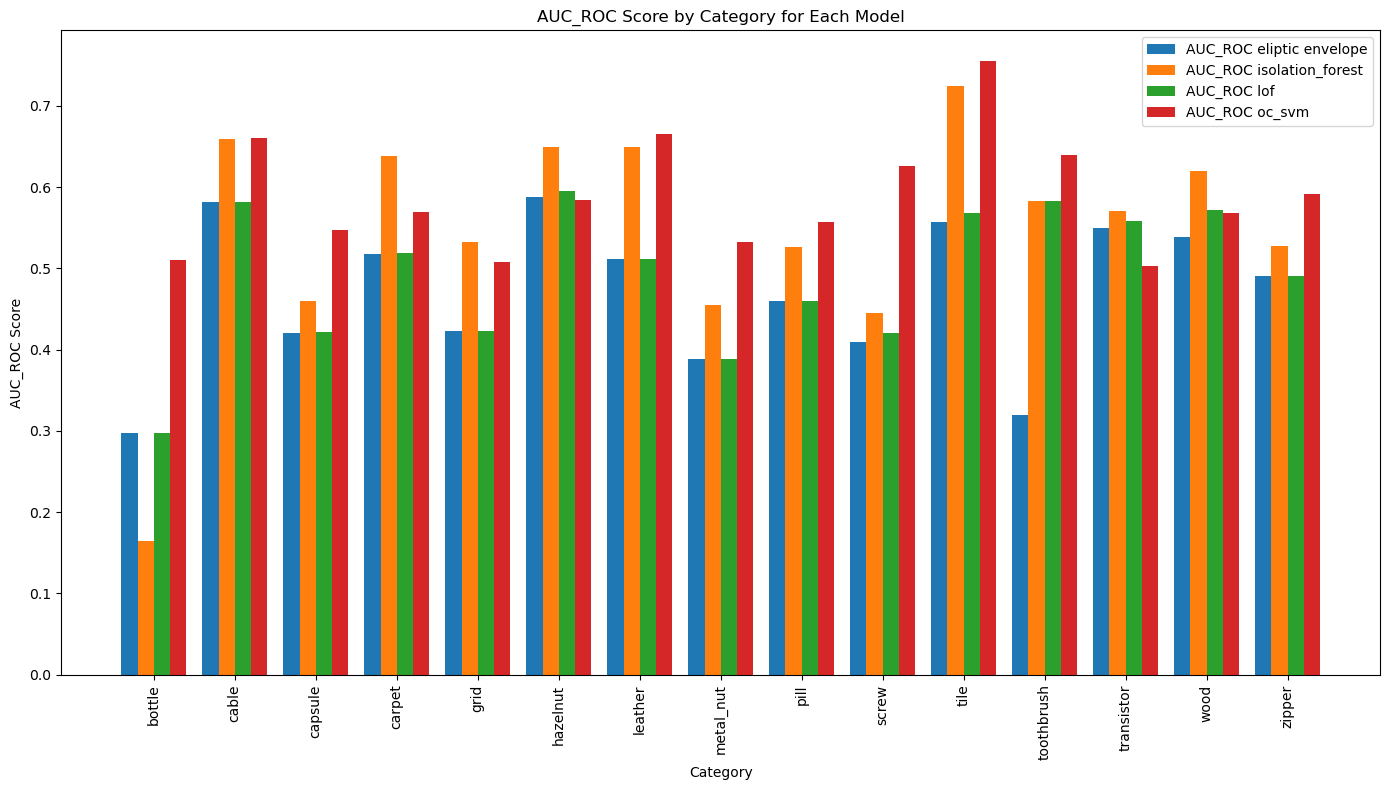

In [26]:
import numpy as np

import matplotlib.pyplot as plt

# Set the figure size
plt.figure(figsize=(14, 8))

# Define the width of the bars
bar_width = 0.2

# Set the positions of the bars on the x-axis
r = np.arange(len(best_models_pivot.index))

# Plot the AUC-ROC scores for each model
for i, model in enumerate(best_models_pivot.columns):
    plt.bar(r + i * bar_width, best_models_pivot[model], width=bar_width, label=model)

# Add labels and title
plt.xlabel('Category')
plt.ylabel('AUC_ROC Score')
plt.title('AUC_ROC Score by Category for Each Model')
plt.xticks(r + bar_width * (len(best_models_pivot.columns) - 1) / 2, best_models_pivot.index, rotation=90)
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()


For almost all methods, we observe that oc_svm performs better

## *5. Iterate over threshold to obtain the best f1 (iterate over validaion dataset)*

In this analysis, we've conducted an iterative process to determine the best threshold for each model based on its F1 score, using the validation data for each category. Here's a breakdown of the results:

#### 1. Model Selection Based on AUC ROC
- by selecting the best model for each category based on the average AUC ROC 
- This code identifies the model with the best avg_auc_roc for each category and stores it.

#### 2. Iterating Over Thresholds to Optimize F1 Score
- finding the optimal threshold for each model by iterating over possible thresholds.
- The goal is to maximize the F1 score, which considers both precision and recall, making it ideal for imbalanced datasets (such as anomaly detection).
- The thresholds are generated around the mean decision score of the model, with the standard deviation influencing the span of the threshold range.

#### 3. Decision Scores Calculation
- are calculated based on their specific methods. For models like LOF (Local Outlier Factor), the code computes the decision function to determine anomaly scores.
- Different anomaly detection models have different methods for calculating these scores, such as decision_function or score_samples.

#### 4. Dynamic Thresholding Logic (LOF vs Other Models)
- The LOF (Local Outlier Factor) model uses a different logic for anomaly detection compared to other models.
- For most models, a higher decision score indicates normal data, but for LOF, a lower score indicates an anomaly.
- The code handles this difference in logic when setting thresholds.
- For LOF, anomalies are identified when the score is below a threshold, while for other models (e.g., Isolation Forest), anomalies are marked when the score is above the threshold.

#### 5. Storing and Summarizing Results in a DataFrame
- the results are stored in a dictionary and eventually converted into a Pandas DataFrame for easy access and further analysis.


- Best F1 Scores: The best F1 score is determined by iterating over thresholds in the decision scores. The threshold that maximizes the F1 score is selected, which indicates the model's performance with the optimal decision boundary.

- Comparison Across Categories: The table below presents the F1 scores for each model across different categories, along with their corresponding AUC ROC scores, which provide insight into the model’s performance on distinguishing between classes, and the thresholds at which the best F1 scores were achieved.

In [28]:
from sklearn.metrics import f1_score

# Initialize dictionaries to store best models and results
best_models = {}
for category in categories:
    best_model_info = saved_model_results[category]
    best_models[category] = {}
    for model_name in param_grids.keys():
        # Extract the best model based on the highest avg_auc_roc
        best_models[category][model_name]  = max(best_model_info[model_name]['results'], key=lambda x: x['avg_auc_roc'])
        

# Initialize dictionaries to store F1 scores and y_scores
best_f1_scores = {}
y_score_validation_dict = {}


# Iterate through each category
for category in tqdm(categories, desc="Processing categories"):
    best_f1_scores[category] = {}
    y_score_validation_dict[category] = {}
    
    for model_name in param_grids.keys():
        # Get the best model for this category and method
        
        model = best_models[category][model_name]['model']
        
        # Get the validation data and true labels
        X_validation_pca = pca_validation_dfs[category].select_dtypes(include=[np.number]).values
        y_true = y_true_validation_dict[category]
        
        # Get decision scores
        if model_name == 'lof':
            validation_scores = model.decision_function(X_validation_pca)
        else:
            validation_scores = model.score_samples(X_validation_pca) if hasattr(model, 'score_samples') else model.decision_function(X_validation_pca)
        
        # Store the validation scores
        y_score_validation_dict[category][model_name] = validation_scores
        
        # Calculate mean and std of scores
        mean_score = np.mean(validation_scores)
        std_score = np.std(validation_scores)
        
        # Generate thresholds
        thresholds = np.linspace(mean_score - 1*std_score, mean_score + 1*std_score, 1000)
        
        # Initialize variables for best F1 score
        best_f1 = 0
        best_threshold = None
        
        # Iterate through thresholds
        for threshold in thresholds:
            # Get predictions based on threshold
            if model_name == 'lof':
                y_pred = (validation_scores <= threshold).astype(int)  # LOF flips the logic
            else:
                y_pred = (validation_scores >= threshold).astype(int)  # Default logic
            
            # Calculate F1 score
            f1 = f1_score(y_true, y_pred)
            
            # Update best F1 score if current is better
            if f1 > best_f1:
                best_f1 = f1
                best_threshold = threshold
        
        # Store results
        best_f1_scores[category][model_name] = {
            'f1_score': best_f1,
            'threshold': best_threshold,
            'best_model_name': model_name,
            'params': best_models[category][model_name]['params']
        }

# Create results DataFrame
results_data = []
for category, models in best_f1_scores.items():
    for model_name, scores in models.items():
        results_data.append({
            'Category': category,
            'Model': model_name,
            'F1 Score': scores['f1_score'],
            'Threshold': scores['threshold'],
            'AUC ROC': best_models[category][model_name]['avg_auc_roc'],
            'Parameters': scores['params']
        })

results_df_2 = pd.DataFrame(results_data)


Processing categories: 100%|██████████| 15/15 [01:02<00:00,  4.14s/it]


In [29]:
results_df_2

,Category,Model,F1 Score,Threshold,AUC ROC,Parameters
0,bottle,oc_svm,0.855172,0.001860,0.510091,"{'degree': 2, 'gamma': 'scale', 'kernel': 'pol..."
1,bottle,isolation_forest,0.742424,-0.493136,0.164626,"{'contamination': 0.01, 'max_features': 1.0, '..."
2,bottle,lof,0.859259,0.453319,0.297166,"{'algorithm': 'auto', 'contamination': 0.01, '..."
3,bottle,eliptic envelope,0.796992,-1.323557,0.297166,"{'assume_centered': True, 'contamination': 0.0..."
4,cable,oc_svm,0.867133,0.020999,0.659867,"{'degree': 2, 'gamma': 'scale', 'kernel': 'rbf..."
5,cable,isolation_forest,0.853147,-0.442930,0.659256,"{'contamination': 0.01, 'max_features': 0.9, '..."
6,cable,lof,0.813333,0.148830,0.580804,"{'algorithm': 'auto', 'contamination': 0.01, '..."
7,cable,eliptic envelope,0.774648,-1.057223,0.580804,"{'assume_centered': True, 'contamination': 0.0..."
8,capsule,oc_svm,0.857143,-0.001084,0.546807,"{'degree': 2, 'gamma': 'scale', 'kernel': 'pol..."
9,capsule,isolation_forest,0.782609,-0.435929,0.460227,"{'contamination': 0.01, 'max_features': 0.9, '..."


### **5.1. Top F1 Scores:**

- Tile category: The oc_svm model achieved the highest F1 score of 0.911565 with a corresponding threshold of 0.023035 and AUC ROC of 0.754917.
- Bottle category: The lof model achieved the best F1 score of 0.859259 with a threshold of 0.453319 and AUC ROC of 0.297166.

##### Other Models:

- Isolation Forest had significant performance in categories like Cable, Leather, and Wood, with F1 scores above 0.8 in many cases. For example, the isolation_forest model in the Hazelnut category achieved a F1 score of 0.824000.
- LOF (Local Outlier Factor) also performed well across most categories, especially in Hazelnut, where it had a F1 score of 0.807692, with a corresponding threshold of 0.400388.

#### Thresholds for Optimal F1:

- The thresholds vary for different models, but they are derived based on the decision scores' distribution (mean and standard deviation), and they impact how the classification boundaries are set.
- For example, the best threshold for the oc_svm model in the Bottle category is 0.001860, while for Metal Nut, it is -0.001235.

#### Key Insights from the Data:
- SVM Models generally performed better in terms of F1 score than the other models like Isolation Forest, LOF, and Eliptic Envelope.
- The best thresholds for each model are closely related to the model type and its behavior on the validation set. For example, Isolation Forest models tend to have negative thresholds, suggesting that they detect anomalies as low values.
- Models like LOF and Eliptic Envelope require careful adjustment of the thresholds for optimal classification performance.

## *6. Plotting ROC Curve and Confusion Matrix for Test Data*

This part of the code is responsible for evaluating the models (such as oc_svm, isolation_forest, lof, eliptic envelope) using both ROC curve and Confusion Matrix. These evaluations are performed for each category in the dataset.

- ROC Curves:

    - For each model and category, the code generates ROC curves. The ROC curve is plotted for each category, showing the trade-off between the true positive rate (sensitivity) and false positive rate (1-specificity) as the decision threshold is varied.
    - The AUC score is calculated for each category, and plotted on the curve.
    - A diagonal line is also drawn representing random chance.

- Confusion Matrix:

    - A confusion matrix is created for each model and category. The confusion matrix is a 2x2 table showing the counts of true positives (TP), false positives (FP), true negatives (TN), and false negatives (FN).
    - Precision, Recall, and F1-Score are calculated and displayed in the title of the confusion matrix plot.

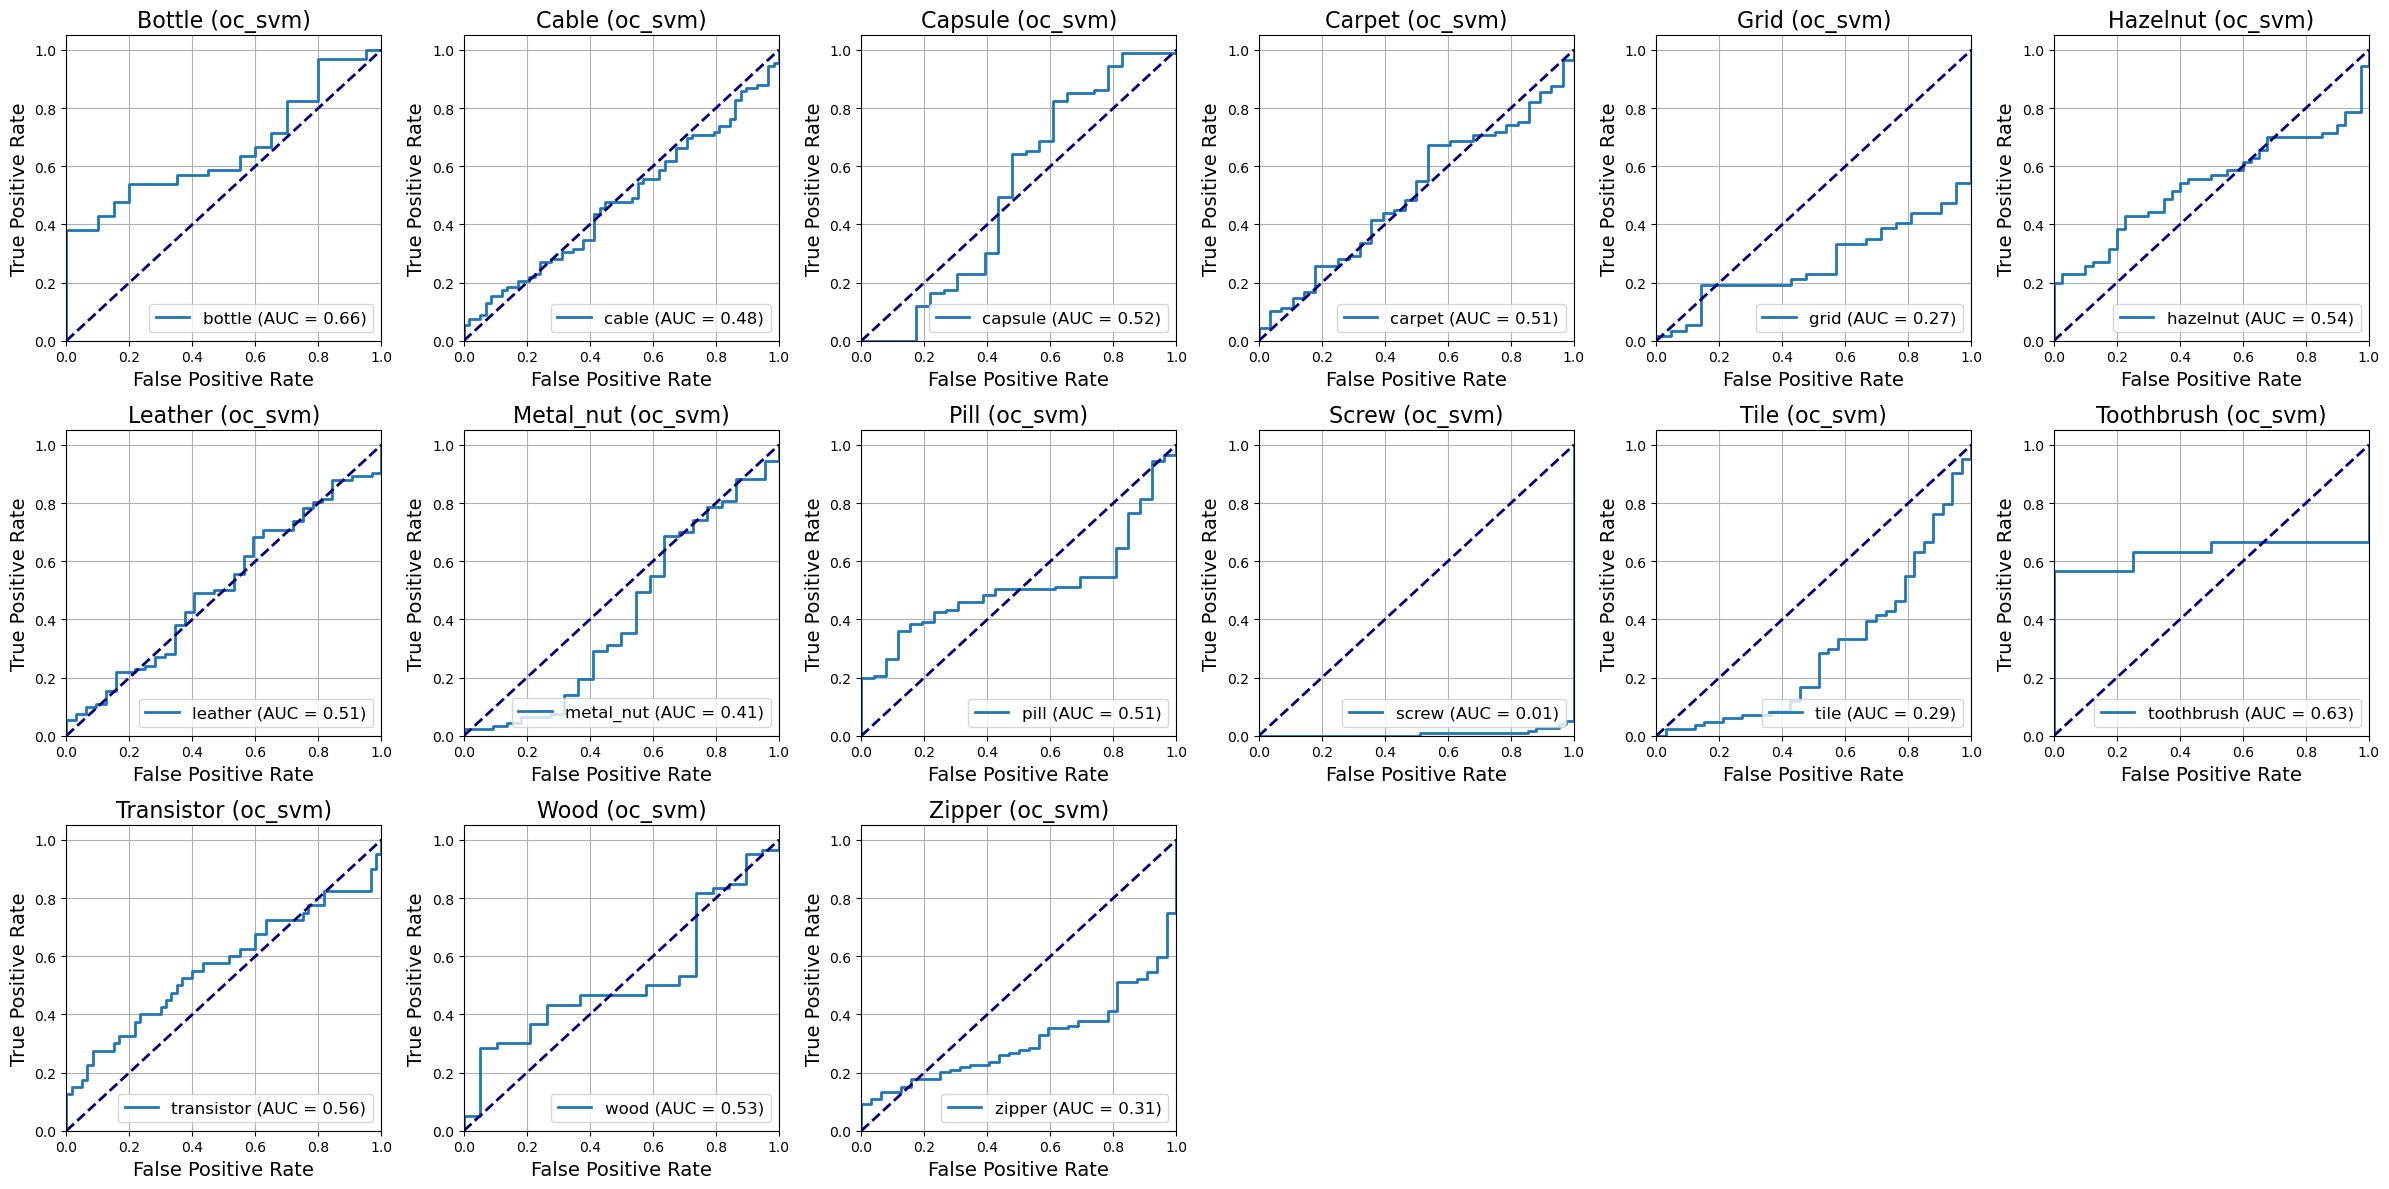

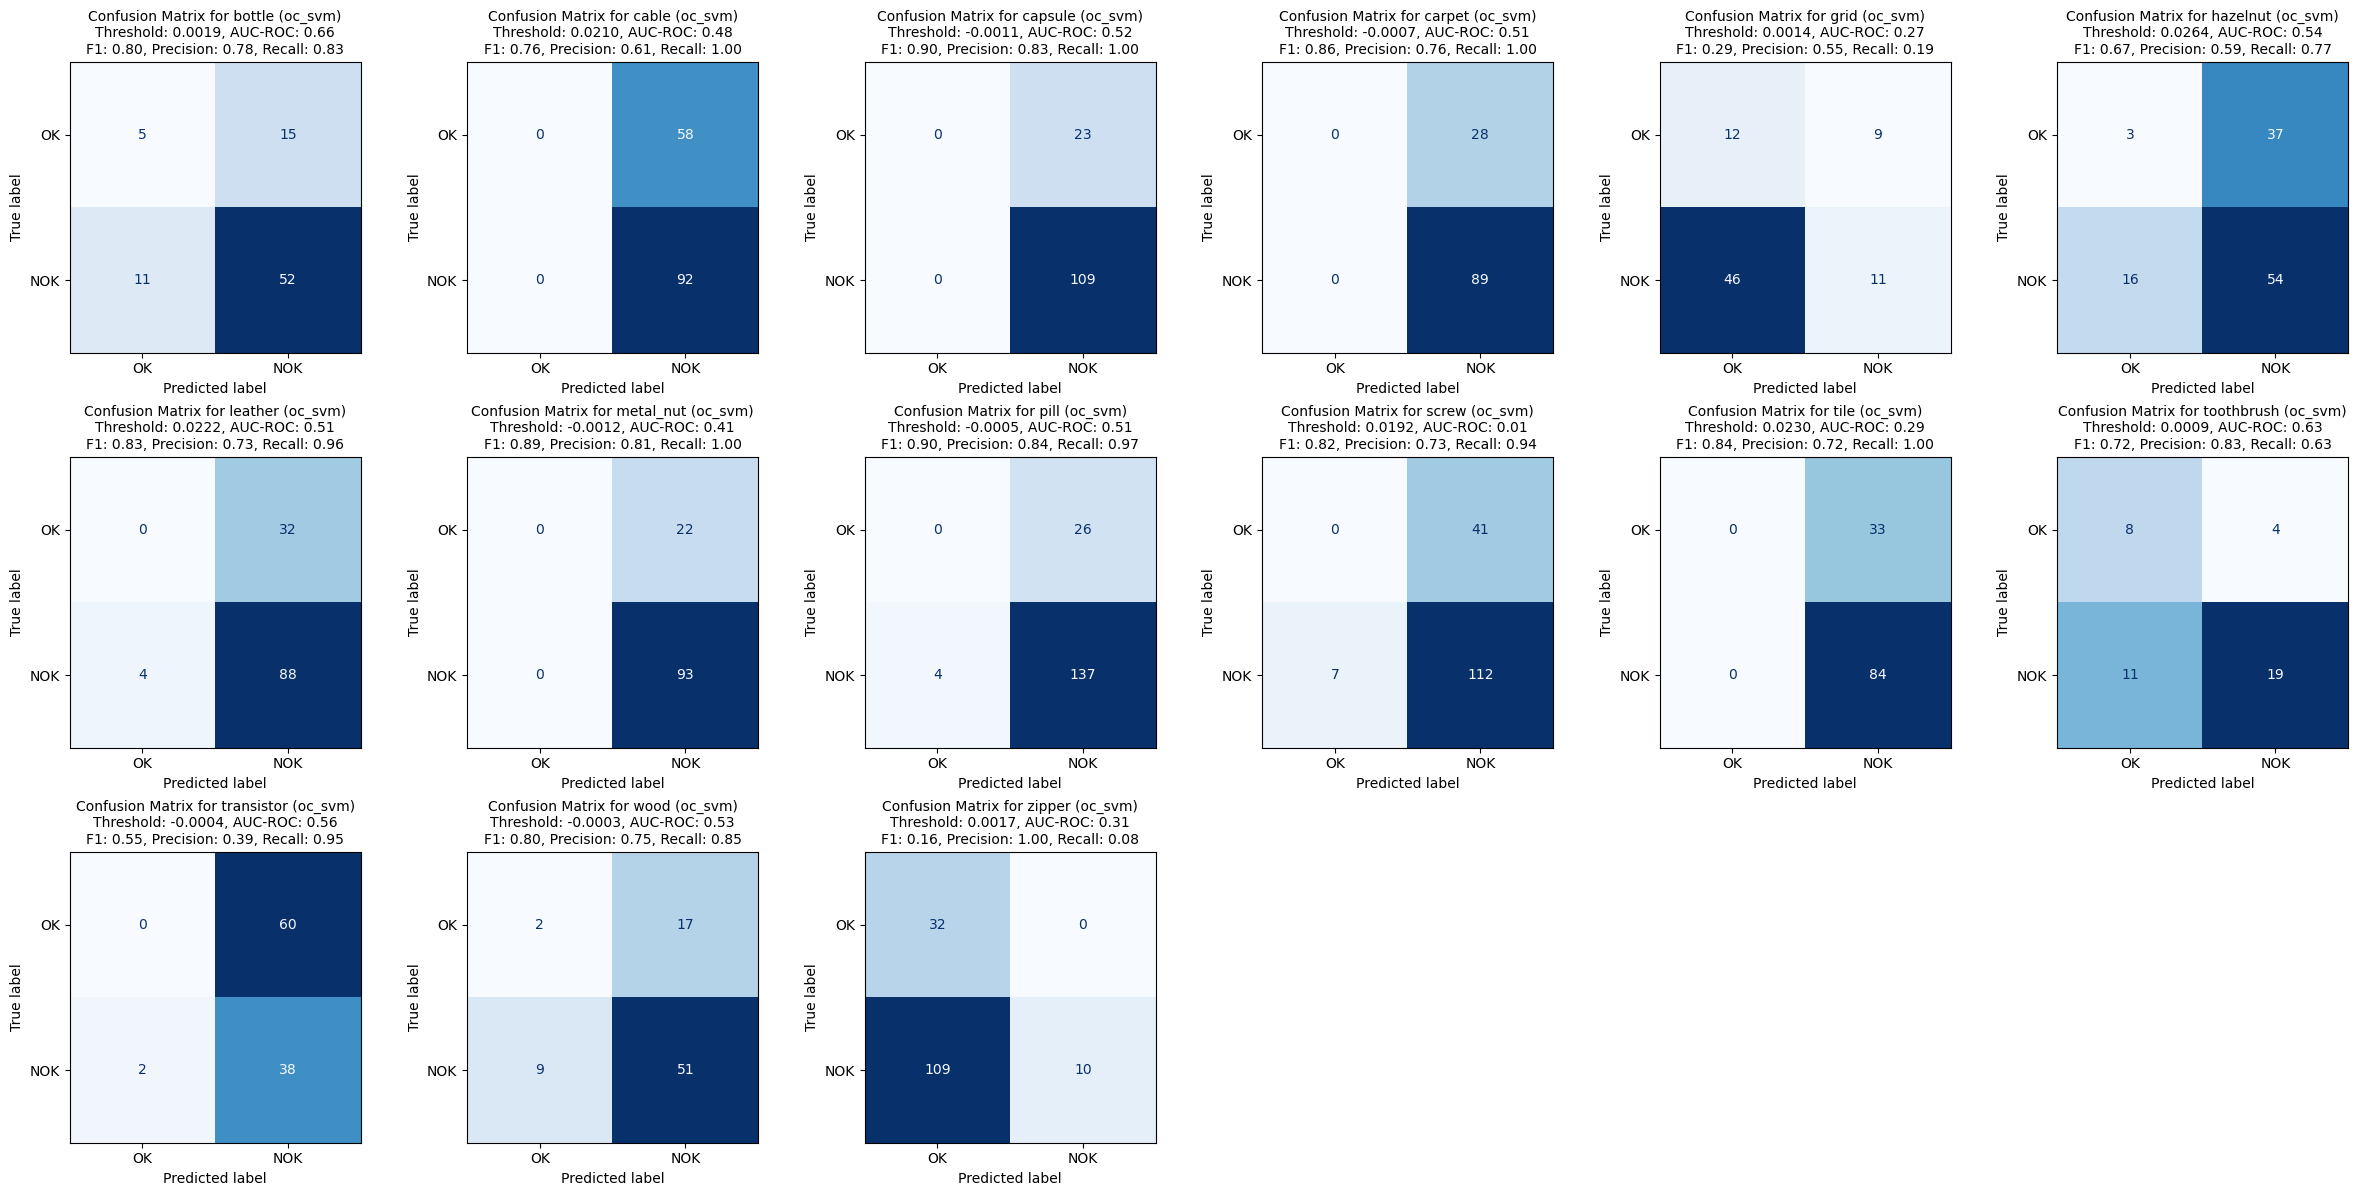

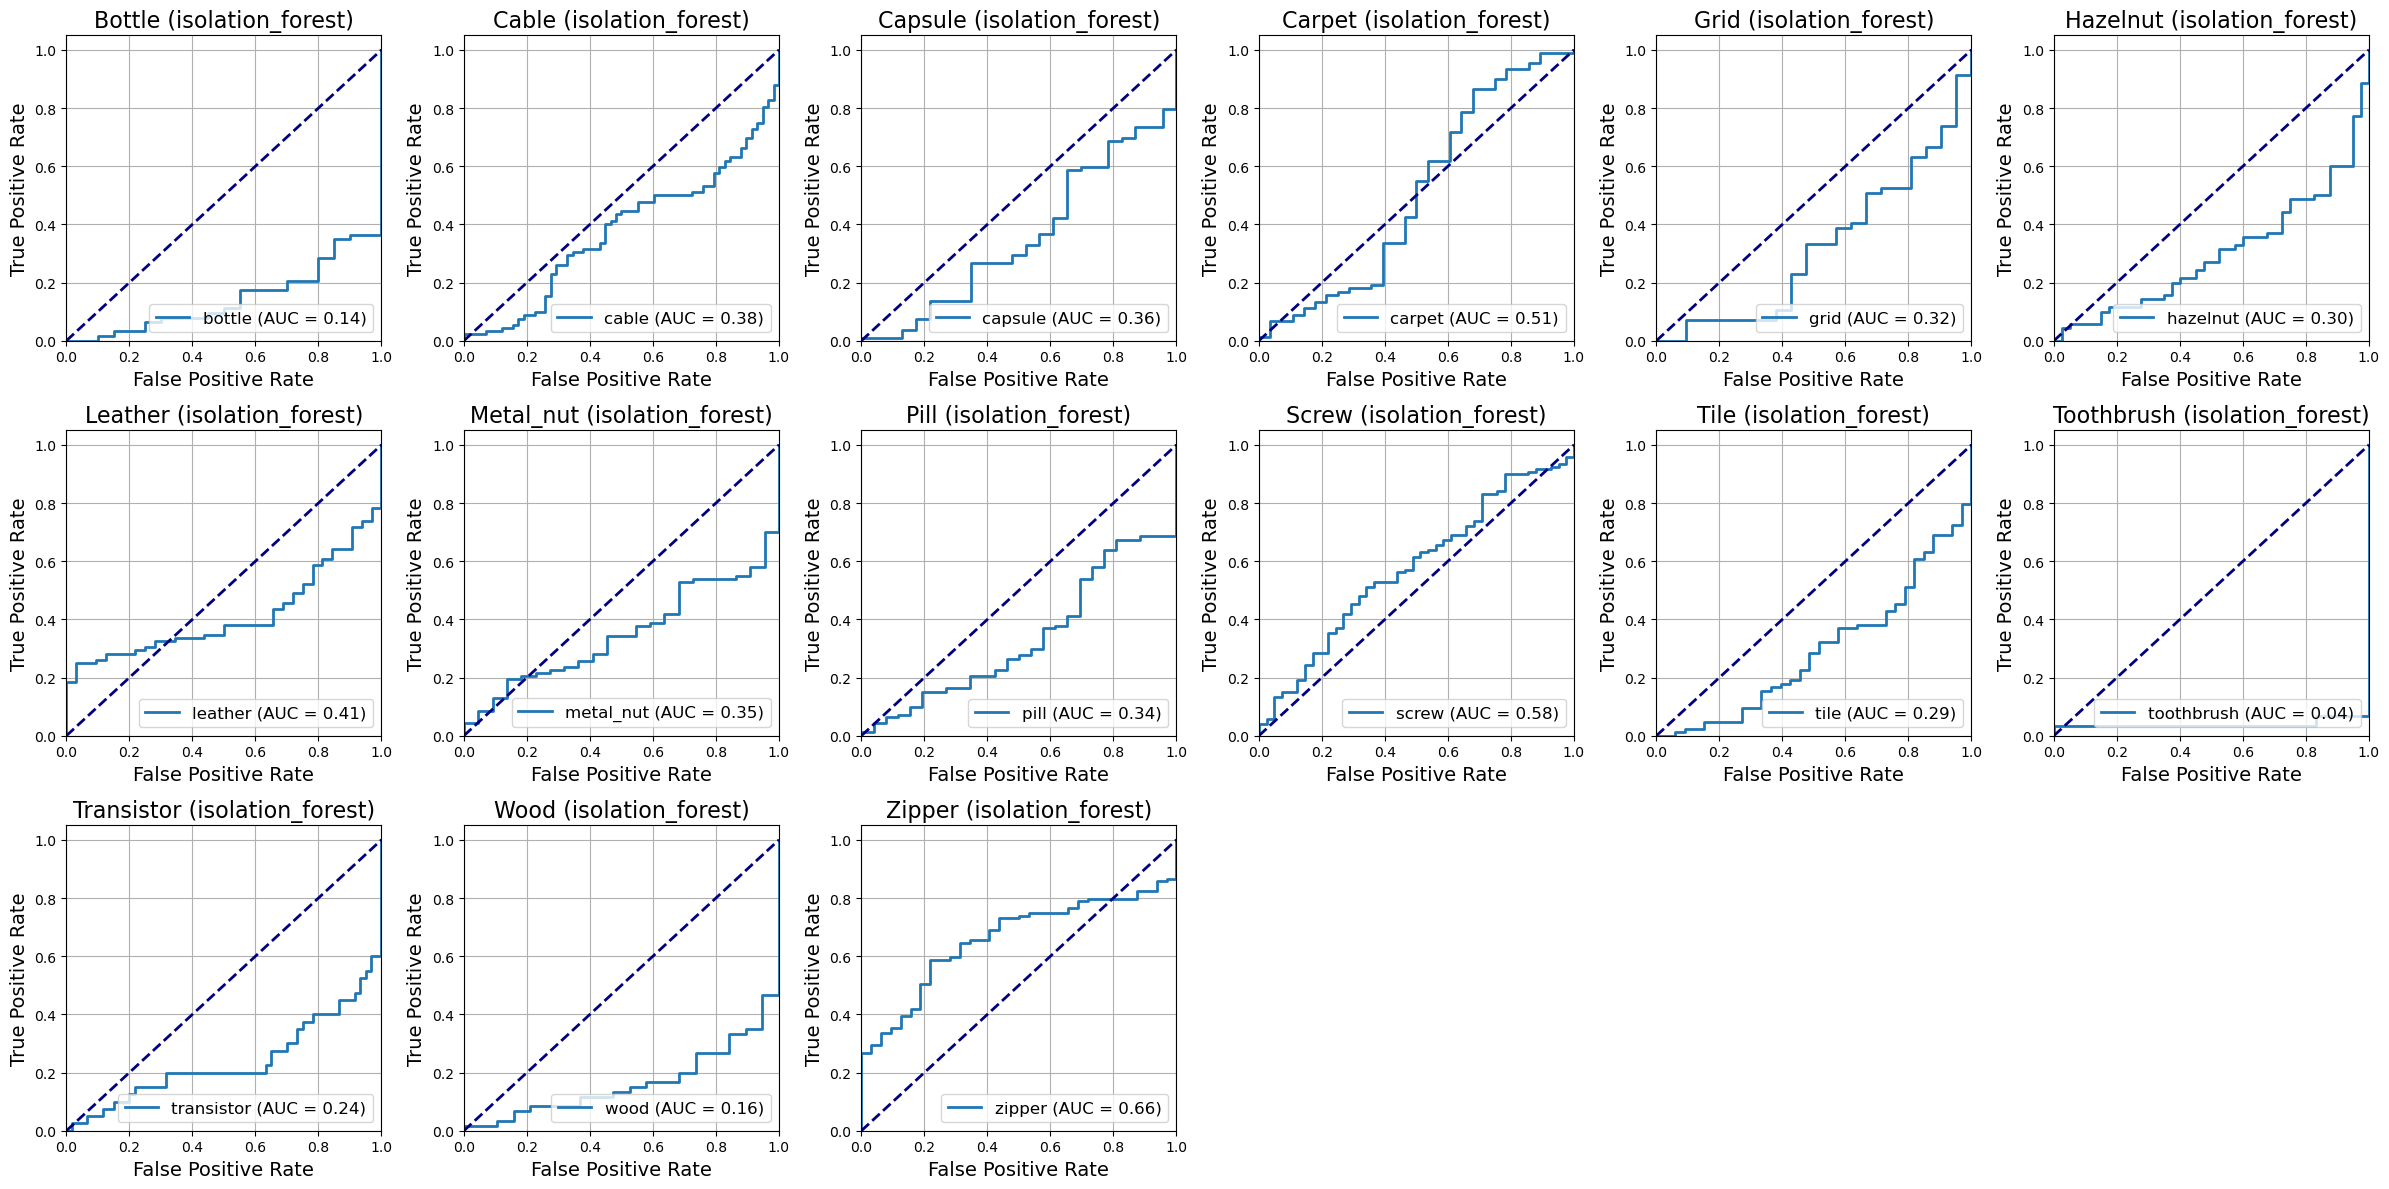

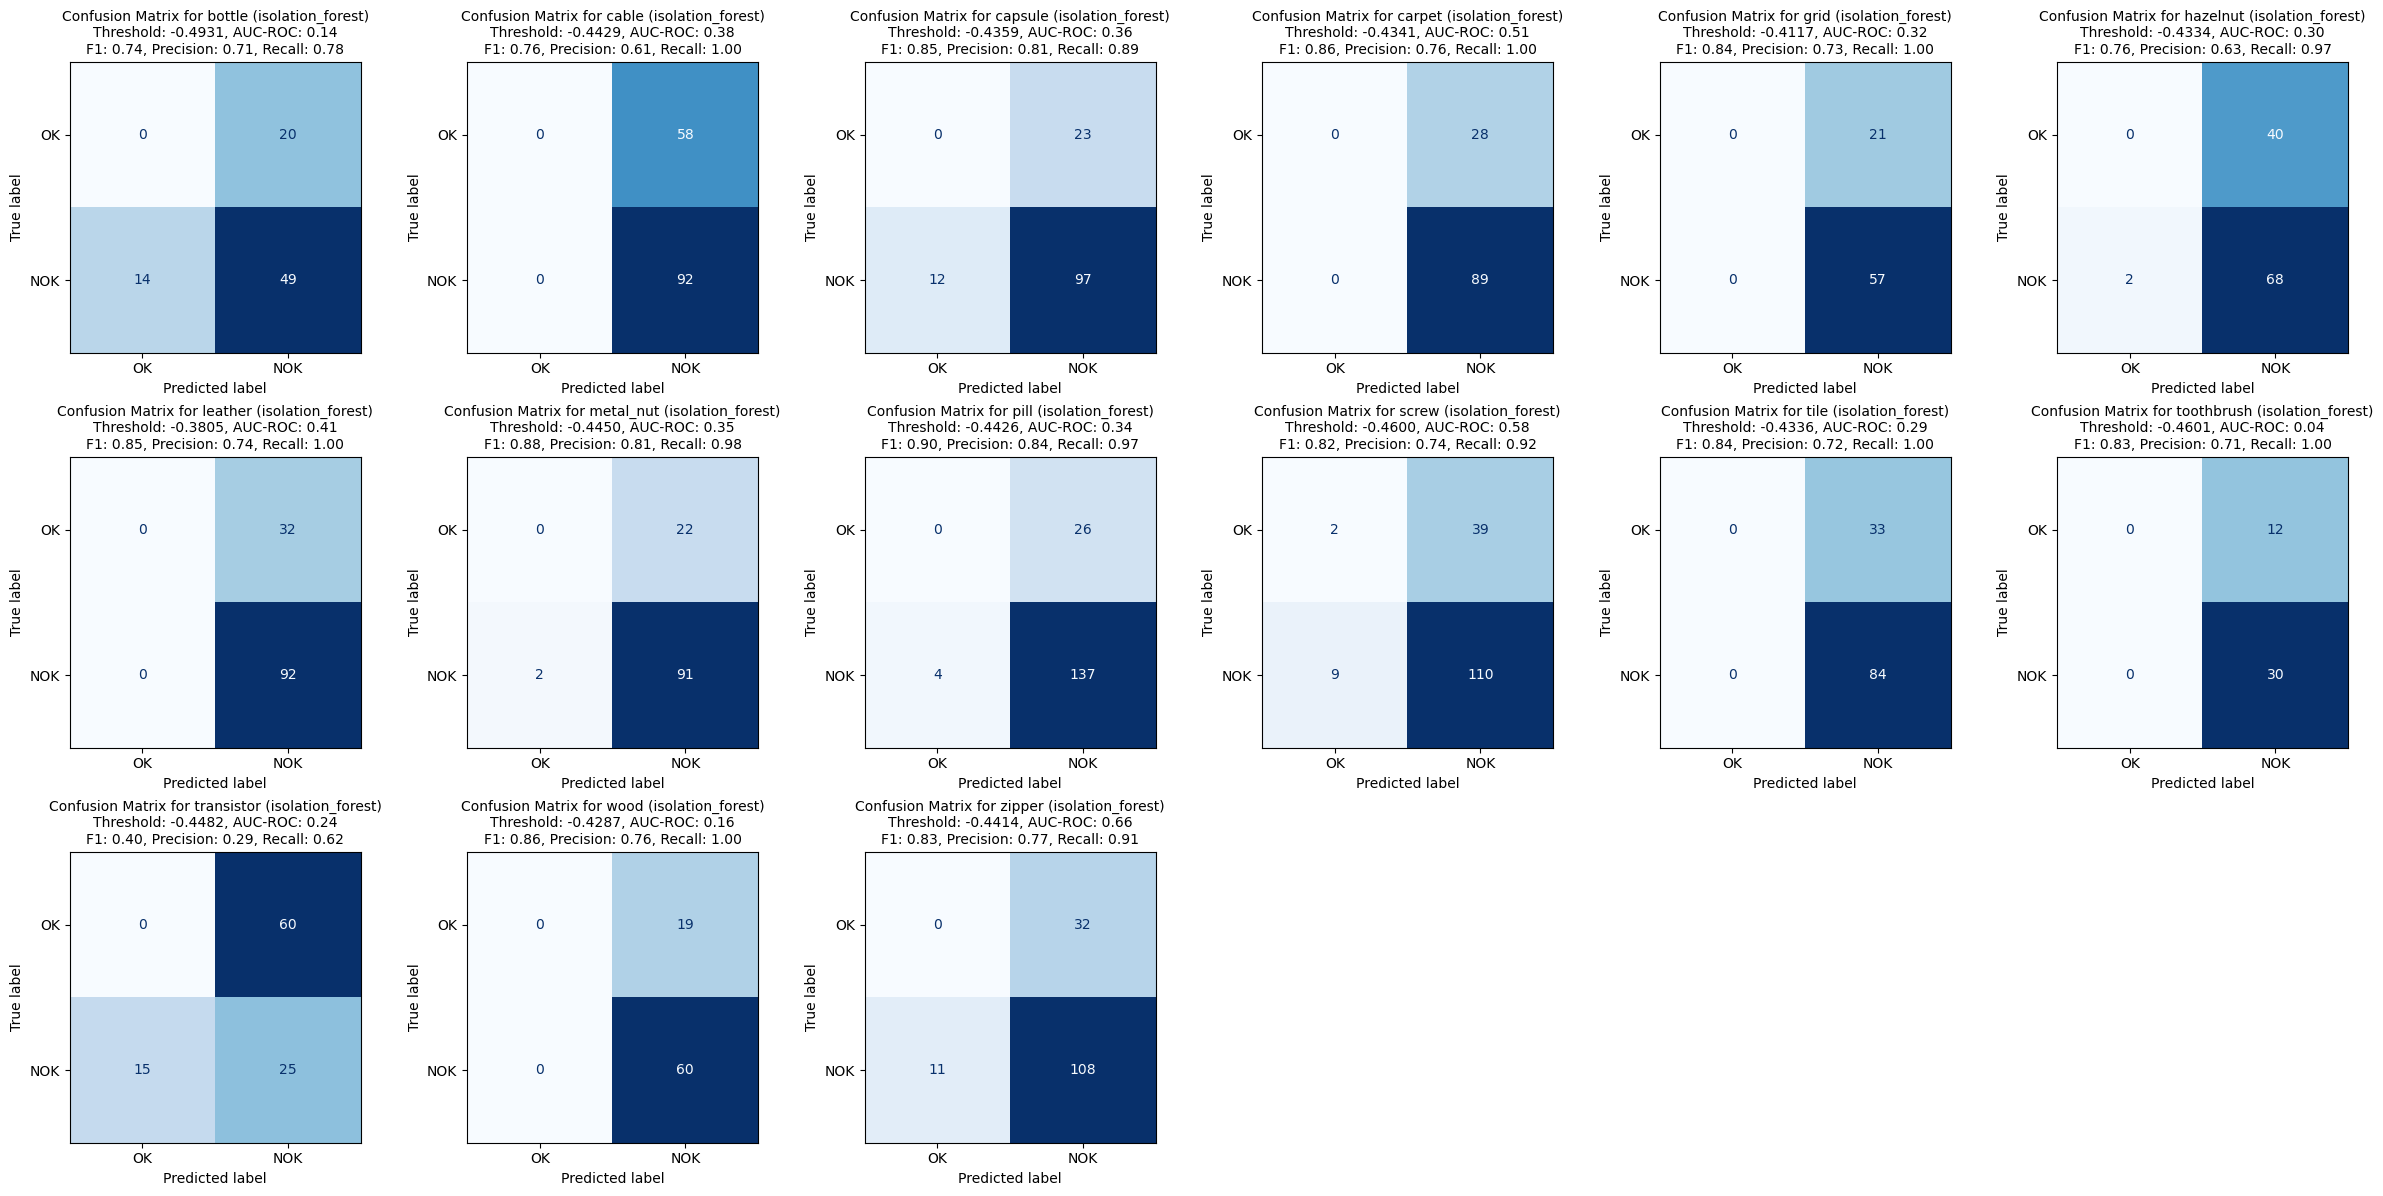

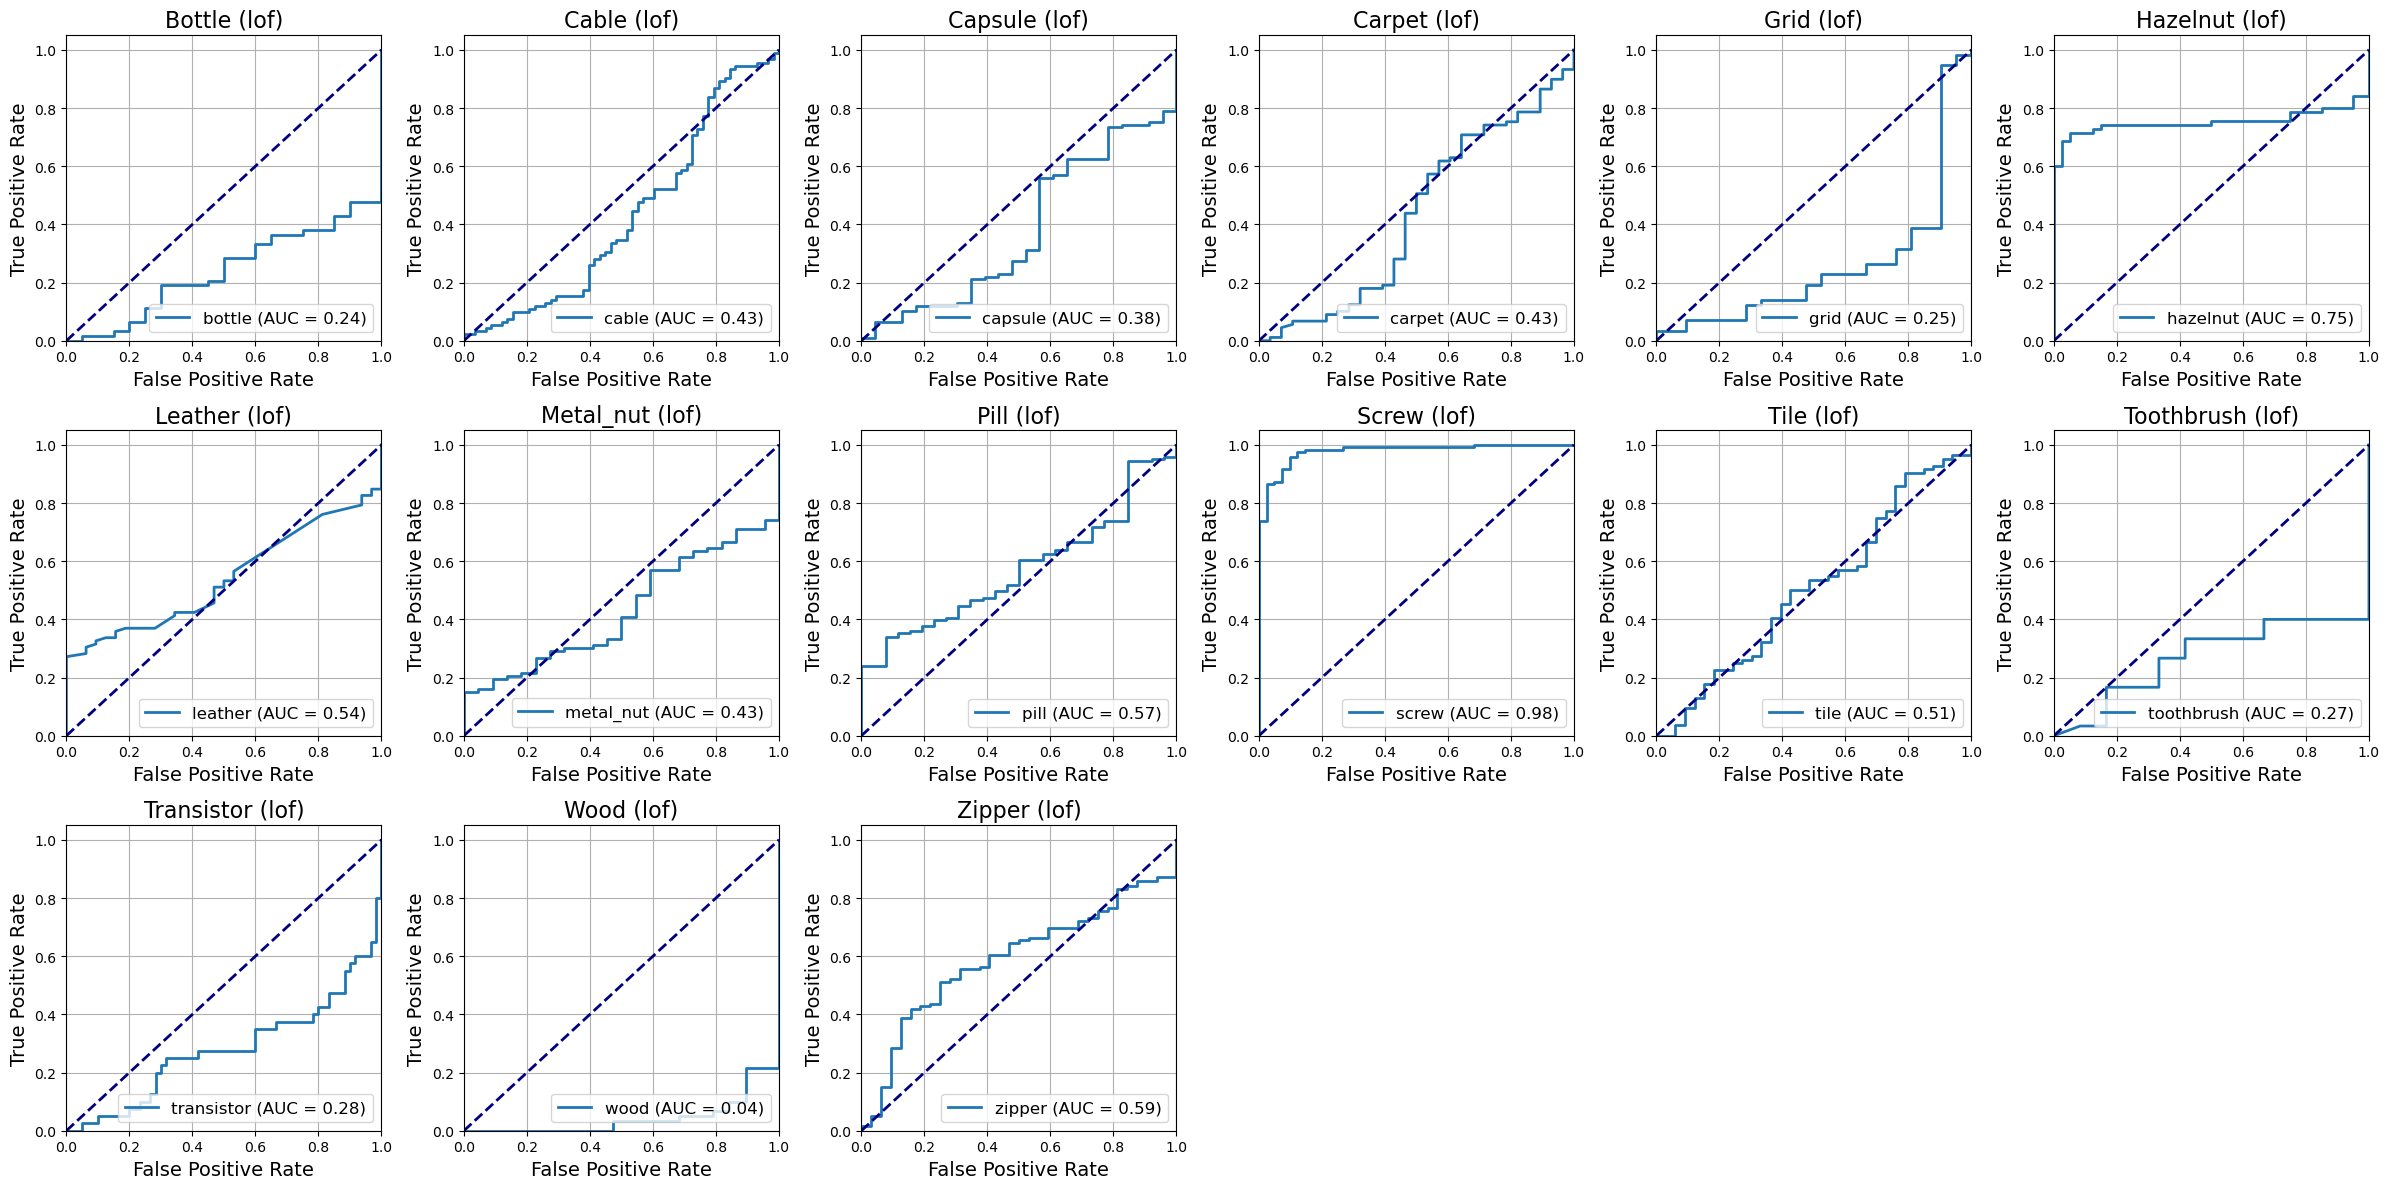

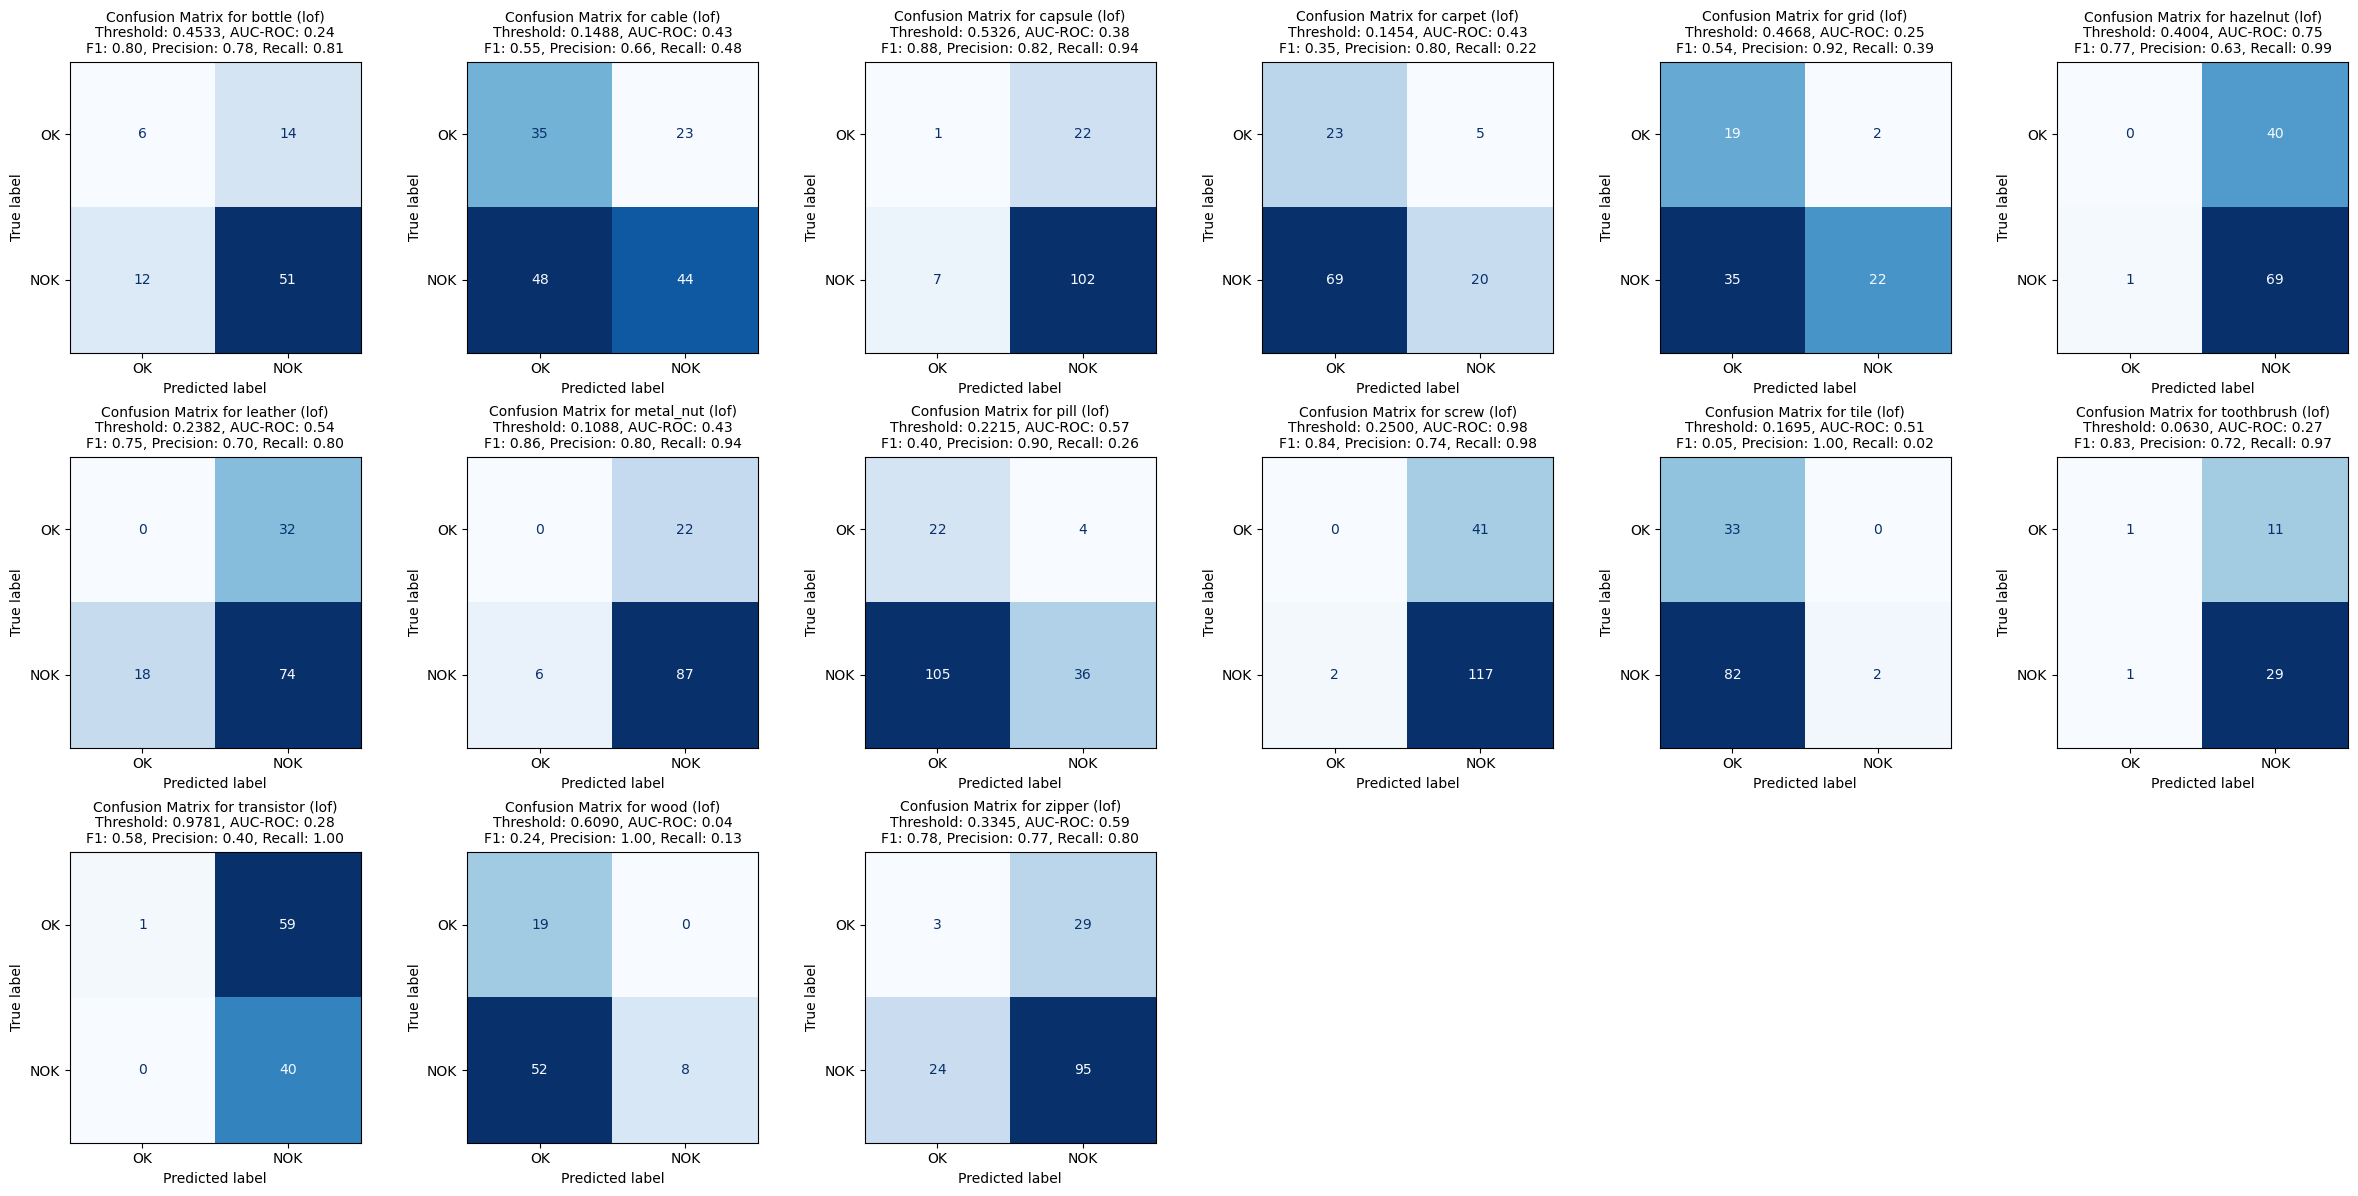

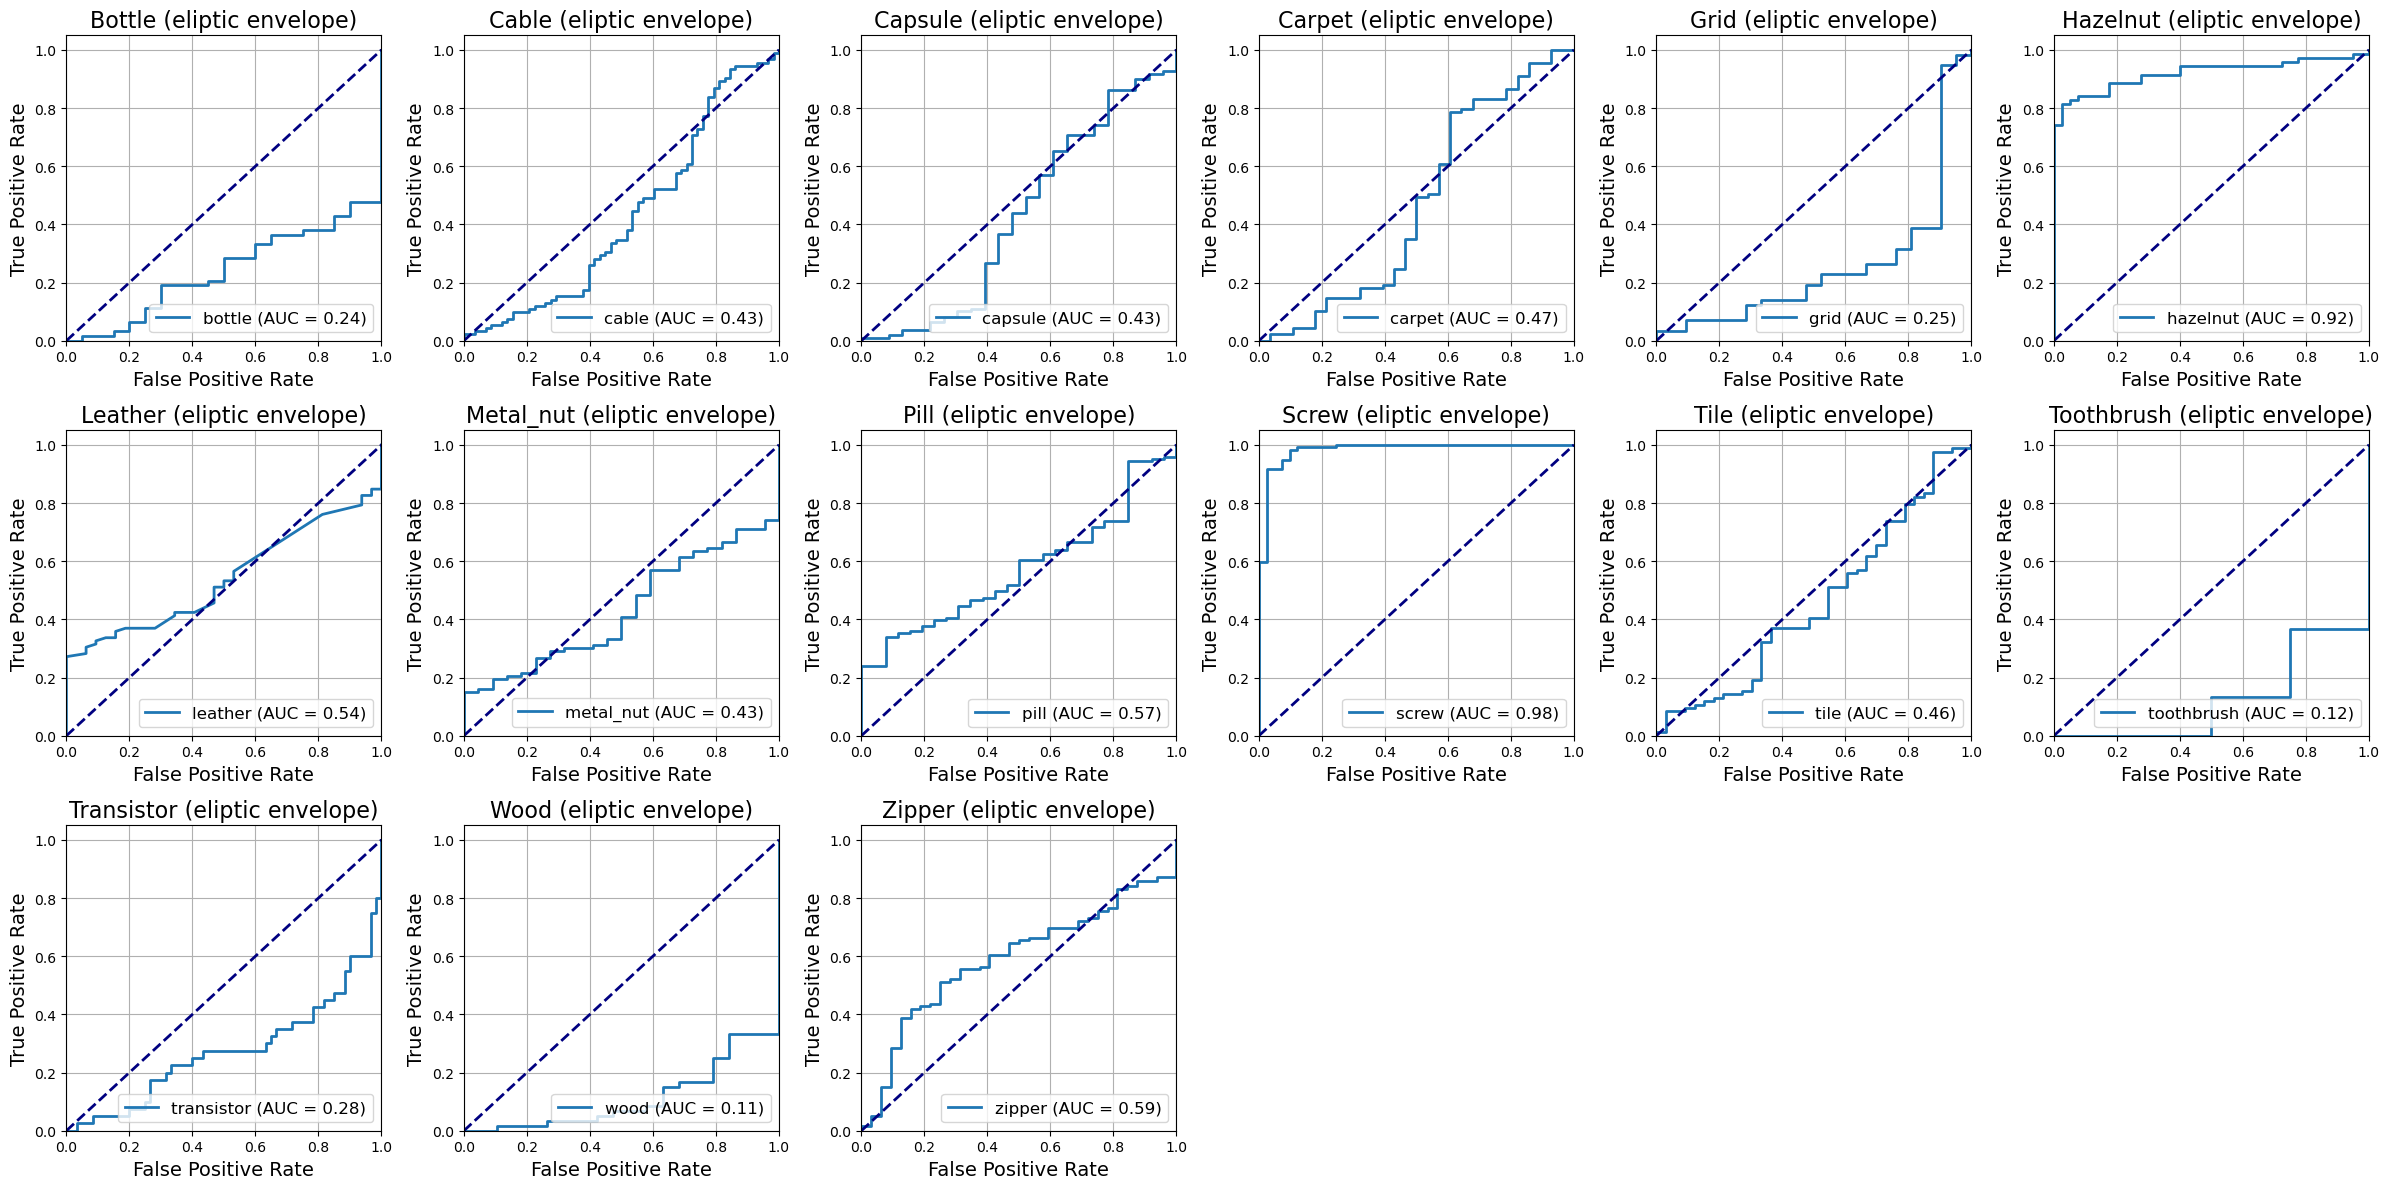

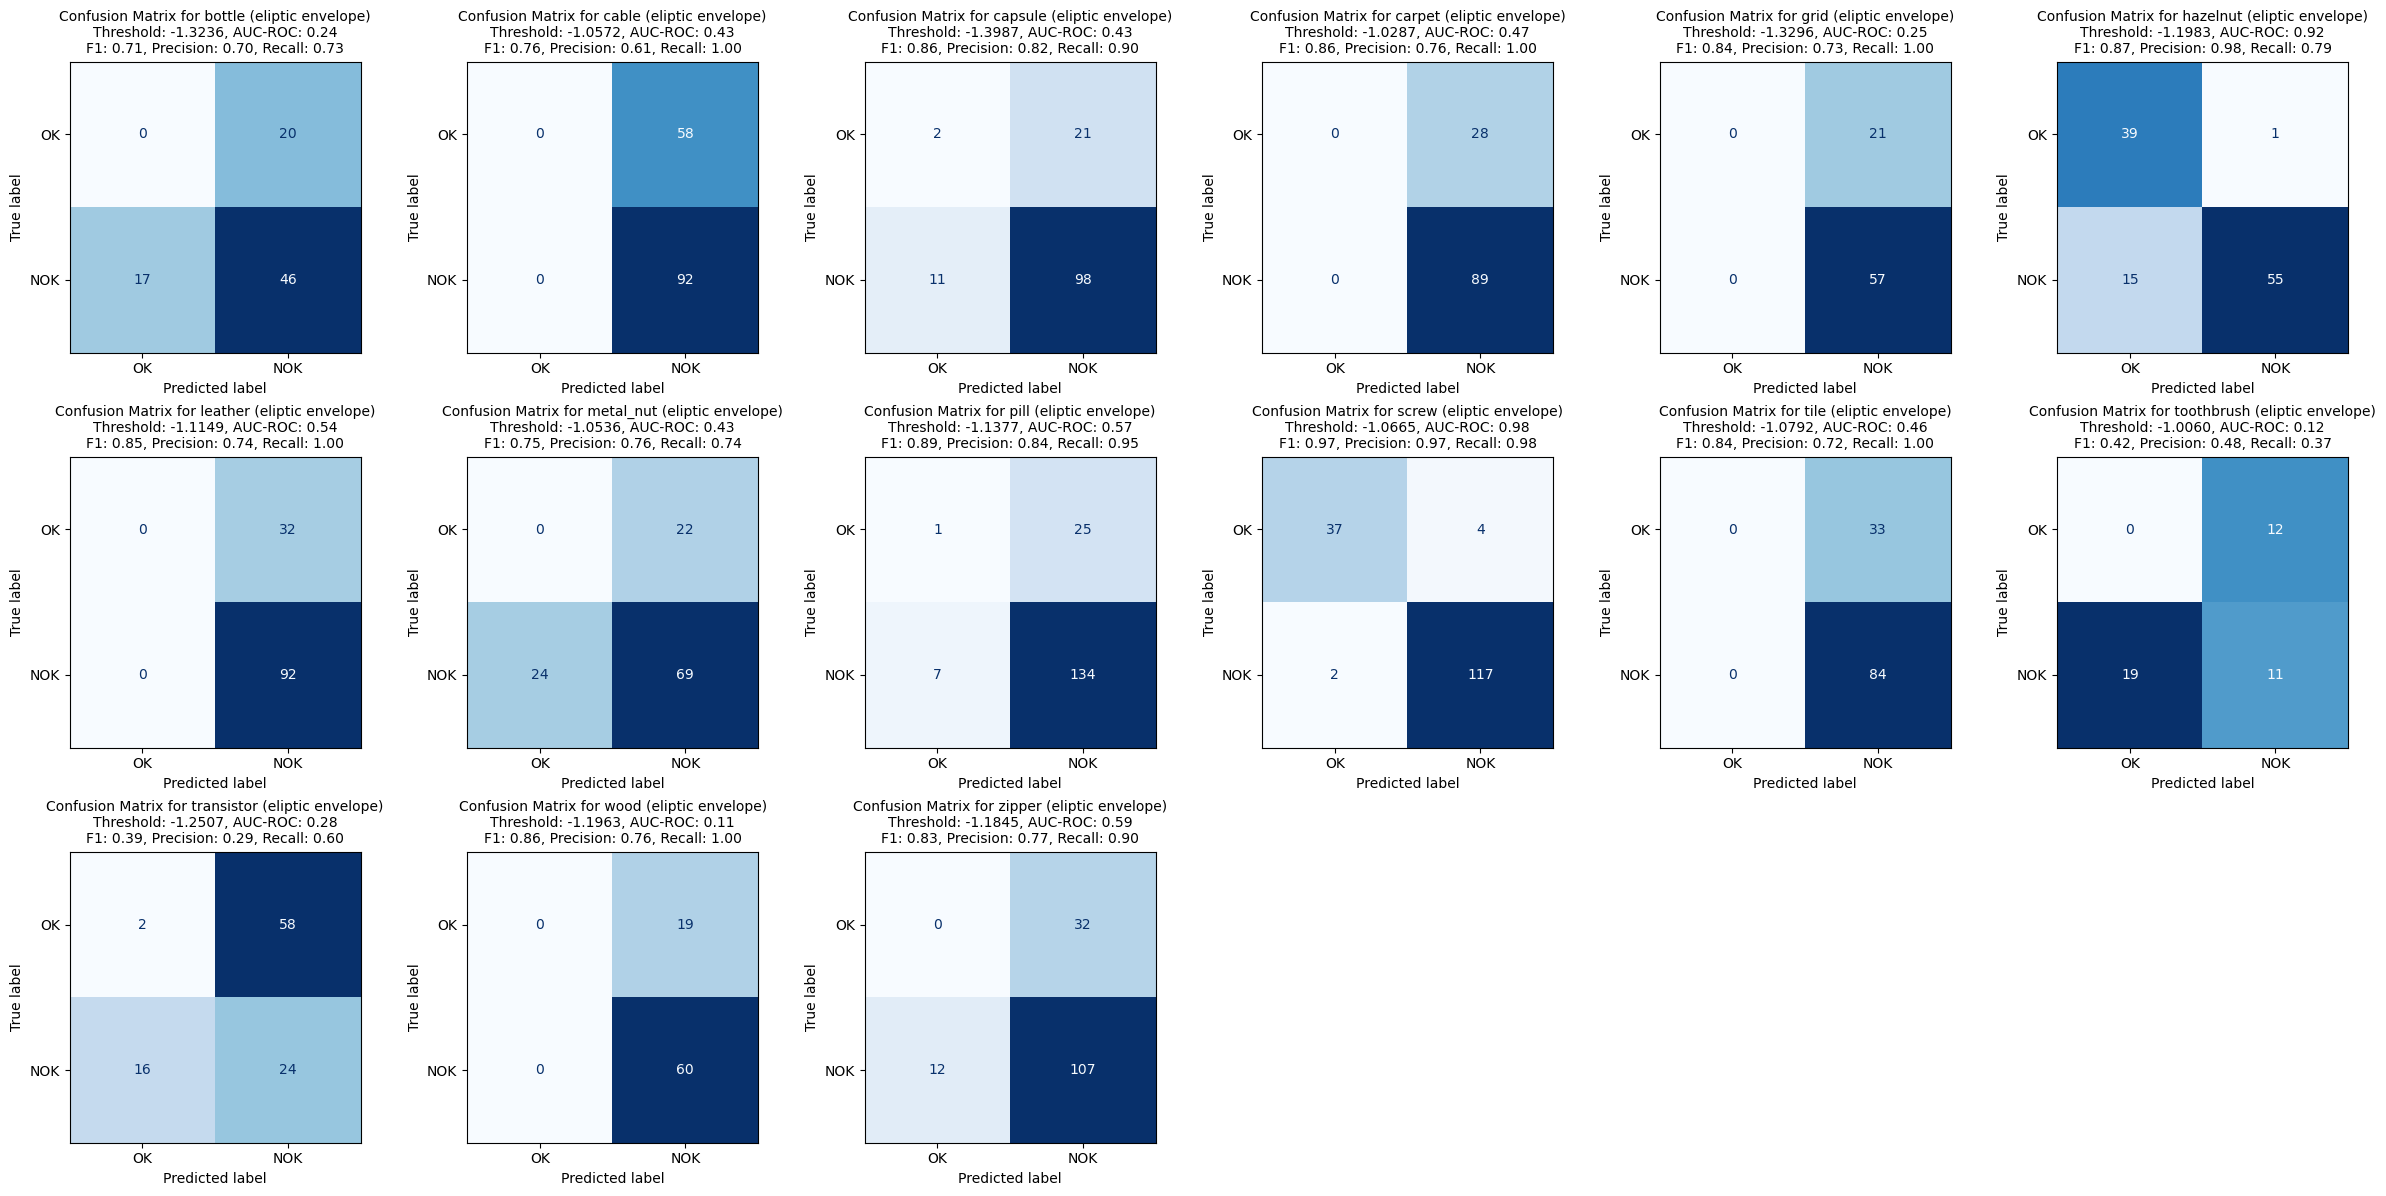

In [33]:
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

methods = ['oc_svm', 'isolation_forest', 'lof', 'eliptic envelope']

# Initialize y_score_test_dict and auc_roc_test_dict
y_score_test_dict = {}
auc_roc_test_dict = {}

for method in methods:
    # Initialize the plot for ROC curves
    fig, axes = plt.subplots(3, 6, figsize=(24, 12))
    axes = axes.ravel()  # Flatten the 2D array of axes for easier indexing

    # Dictionary to store ROC AUC scores
    roc_auc_scores = {}

    # Iterate over each category for ROC curves
    categories = list(y_true_test_dict.keys())
    for idx, category in enumerate(categories):
        y_true = y_true_test_dict[category]
        y_scores = y_score_test_dict.get(category, {}).get(method, None)

        if y_scores is None:
            # Calculate y_scores if not already present
            model = best_models[category][method]['model']
            X_test_pca = pca_test_dfs[category].drop(columns=['category']).values
            if method == 'lof':
                y_scores = model.decision_function(X_test_pca)
            else:
                y_scores = model.score_samples(X_test_pca) if hasattr(model, 'score_samples') else model.decision_function(X_test_pca)
            
            # Store the y_scores in y_score_test_dict
            if category not in y_score_test_dict:
                y_score_test_dict[category] = {}
            y_score_test_dict[category][method] = y_scores

        if y_scores is not None:
            # Compute ROC curve and AUC
            fpr, tpr, _ = roc_curve(y_true, y_scores)
            roc_auc = auc(fpr, tpr)

            # Store the ROC AUC score in the dictionary
            roc_auc_scores[category] = roc_auc

            # Plot the ROC curve
            axes[idx].plot(fpr, tpr, lw=2, label=f'{category} (AUC = {roc_auc:.2f})')

        # Plot the diagonal line for random chance
        axes[idx].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

        # Configure plot settings
        axes[idx].set_xlim([0.0, 1.0])
        axes[idx].set_ylim([0.0, 1.05])
        axes[idx].set_xlabel('False Positive Rate', fontsize=14)
        axes[idx].set_ylabel('True Positive Rate', fontsize=14)
        axes[idx].set_title(f'{category.capitalize()} ({method})', fontsize=16)
        axes[idx].legend(loc='lower right', fontsize=12)
        axes[idx].grid(True)

    # Remove empty subplots if any
    for idx in range(len(categories), 18):
        fig.delaxes(axes[idx])

    plt.tight_layout()
    plt.show()

    # Initialize the plot for confusion matrices
    fig, axes_cm = plt.subplots(3, 6, figsize=(24, 12))
    axes_cm = axes_cm.ravel()  # Flatten the 2D array of axes for easier indexing

    for ax, category in zip(axes_cm, y_true_test_dict.keys()):
        y_true = y_true_test_dict[category]
        y_score = y_score_test_dict[category][method]
        threshold = best_f1_scores[category][method]['threshold']
        y_preds = (np.array(y_score) >= threshold).astype(int) if method != 'lof' else (np.array(y_score) <= threshold).astype(int)

        # Generate confusion matrix
        cm = confusion_matrix(y_true, y_preds)

        # Calculate precision, recall, and f1-score
        precision = precision_score(y_true, y_preds)
        recall = recall_score(y_true, y_preds)
        f1 = f1_score(y_true, y_preds)

        # Calculate AUC-ROC score
        roc_auc = roc_auc_scores[category]

        # Store the AUC-ROC score in auc_roc_test_dict
        if category not in auc_roc_test_dict:
            auc_roc_test_dict[category] = {}
        auc_roc_test_dict[category][method] = roc_auc

        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['OK', 'NOK'])
        disp.plot(ax=ax, cmap=plt.cm.Blues, values_format='d', colorbar=False)
        ax.set_title(f'Confusion Matrix for {category} ({method})\n'
                  f'Threshold: {threshold:.4f}, AUC-ROC: {roc_auc:.2f}\n'
                  f'F1: {f1:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}', fontsize=10)

    # Remove empty subplots if any
    for idx in range(len(categories), 18):
        fig.delaxes(axes_cm[idx])

    plt.tight_layout()
    plt.show()


### **6.1. AUC-ROC Test vs Validation Comparison:**
This part compares the AUC-ROC score between the validation set and the test set for each model. The goal is to assess how well the model generalizes from the validation data to unseen test data.

For each model and category:
- The AUC-ROC score is compared between the validation and test sets.
- The percentage difference between the two AUC scores is computed and stored.

And a table (comparison_df) is created to summarize the comparison results. The table contains the AUC-ROC scores for the validation and test sets, along with the percentage difference for each category and model.

In [34]:
# Initialize a list to store the results
comparison_data = []

# Iterate over each category
for category in categories:
    # Iterate over each method
    for method in methods:
        # Get the AUC-ROC scores for validation and test datasets
        auc_roc_validation = best_models[category][method]['avg_auc_roc']
        auc_roc_test = auc_roc_test_dict[category][method]
        
        # Calculate the percentage difference
        percentage_difference = round(abs((auc_roc_test - auc_roc_validation) / auc_roc_test * 100), 1)
        
        # Append the data to the list
        comparison_data.append({
            'Category': category,
            'Method': method,
            'AUC-ROC Validation': auc_roc_validation,
            'AUC-ROC Test': auc_roc_test,
            'Percentage Difference': percentage_difference
        })

# Create a DataFrame from the comparison data
comparison_df = pd.DataFrame(comparison_data)


### **6.2. Grouping Results by Method and Calculating Average Percentage Difference:**
This part of the code groups the comparison results (from the previous block) by the model method and calculates the average percentage difference for each model.

- The results for each method (such as oc_svm, isolation_forest, etc.) are separated into their own DataFrames.
- The average percentage difference for each method is computed and stored.
- This average is added as a new column (Average_Percentage_Difference) to each DataFrame.

In [35]:
# Separate the dataframe into four dataframes, one for each method
oc_svm_df = comparison_df[comparison_df['Method'] == 'oc_svm']
isolation_forest_df = comparison_df[comparison_df['Method'] == 'isolation_forest']
lof_df = comparison_df[comparison_df['Method'] == 'lof']
eliptic_envelope_df = comparison_df[comparison_df['Method'] == 'eliptic envelope']

# Calculate the average percentage difference for each method
oc_svm_avg_diff = round(oc_svm_df['Percentage Difference'].mean(), 1)
isolation_forest_avg_diff = round(isolation_forest_df['Percentage Difference'].mean(), 1)
lof_avg_diff = round(lof_df['Percentage Difference'].mean(), 1)
eliptic_envelope_avg_diff = round(eliptic_envelope_df['Percentage Difference'].mean(), 1)

# Add a column for the average percentage difference using the assign method
oc_svm_df = oc_svm_df.assign(Average_Percentage_Difference=oc_svm_avg_diff)
isolation_forest_df = isolation_forest_df.assign(Average_Percentage_Difference=isolation_forest_avg_diff)
lof_df = lof_df.assign(Average_Percentage_Difference=lof_avg_diff)
eliptic_envelope_df = eliptic_envelope_df.assign(Average_Percentage_Difference=eliptic_envelope_avg_diff)

- The oc_svm_df DataFrame is displayed, showing the detailed comparison for the oc_svm method.

In [36]:
# Display the dataframe
oc_svm_df

,Category,Method,AUC-ROC Validation,AUC-ROC Test,Percentage Difference,Average_Percentage_Difference
0,bottle,oc_svm,0.510091,0.658730,22.6,593.3
4,cable,oc_svm,0.659867,0.480510,37.3,593.3
8,capsule,oc_svm,0.546807,0.521739,4.8,593.3
12,carpet,oc_svm,0.568519,0.507223,12.1,593.3
16,grid,oc_svm,0.508019,0.268170,89.4,593.3
20,hazelnut,oc_svm,0.583686,0.539286,8.2,593.3
24,leather,oc_svm,0.664892,0.509171,30.6,593.3
28,metal_nut,oc_svm,0.531656,0.413001,28.7,593.3
32,pill,oc_svm,0.556875,0.514457,8.2,593.3
36,screw,oc_svm,0.626420,0.007379,8389.7,593.3


In [37]:
isolation_forest_df

,Category,Method,AUC-ROC Validation,AUC-ROC Test,Percentage Difference,Average_Percentage_Difference
1,bottle,isolation_forest,0.164626,0.144444,14.0,165.1
5,cable,isolation_forest,0.659256,0.377061,74.8,165.1
9,capsule,isolation_forest,0.460227,0.356203,29.2,165.1
13,carpet,isolation_forest,0.638095,0.506019,26.1,165.1
17,grid,isolation_forest,0.532341,0.319967,66.4,165.1
21,hazelnut,isolation_forest,0.649009,0.298929,117.1,165.1
25,leather,isolation_forest,0.648742,0.414742,56.4,165.1
29,metal_nut,isolation_forest,0.455087,0.350440,29.9,165.1
33,pill,isolation_forest,0.525747,0.335243,56.8,165.1
37,screw,isolation_forest,0.444602,0.577167,23.0,165.1


In [38]:
lof_df

,Category,Method,AUC-ROC Validation,AUC-ROC Test,Percentage Difference,Average_Percentage_Difference
2,bottle,lof,0.297166,0.239683,24.0,114.4
6,cable,lof,0.580804,0.428598,35.5,114.4
10,capsule,lof,0.422078,0.379737,11.2,114.4
14,carpet,lof,0.518915,0.431982,20.1,114.4
18,grid,lof,0.423024,0.253133,67.1,114.4
22,hazelnut,lof,0.594862,0.753929,21.1,114.4
26,leather,lof,0.511636,0.540931,5.4,114.4
30,metal_nut,lof,0.389340,0.431085,9.7,114.4
34,pill,lof,0.459745,0.573377,19.8,114.4
38,screw,lof,0.420455,0.978069,57.0,114.4


In [39]:
eliptic_envelope_df

,Category,Method,AUC-ROC Validation,AUC-ROC Test,Percentage Difference,Average_Percentage_Difference
3,bottle,eliptic envelope,0.297166,0.239683,24.0,62.4
7,cable,eliptic envelope,0.580804,0.428598,35.5,62.4
11,capsule,eliptic envelope,0.421266,0.429597,1.9,62.4
15,carpet,eliptic envelope,0.517460,0.471108,9.8,62.4
19,grid,eliptic envelope,0.423024,0.253133,67.1,62.4
23,hazelnut,eliptic envelope,0.588429,0.920357,36.1,62.4
27,leather,eliptic envelope,0.511636,0.540931,5.4,62.4
31,metal_nut,eliptic envelope,0.389340,0.431085,9.7,62.4
35,pill,eliptic envelope,0.459745,0.573377,19.8,62.4
39,screw,eliptic envelope,0.408523,0.983398,58.5,62.4


### ** 6.3. Summary of tables:**

- oc_svm shows highly variable performance, especially with some extreme cases (e.g., screw with a 8389.7% difference). It also has the highest average percentage difference (593.3%).
- isolation_forest has a moderate average percentage difference of 165.1%, with extreme cases (e.g., toothbrush with a 1400% difference).
- lof shows an average percentage difference of 114.4%, with some drastic fluctuations (e.g., wood with 1203.5%).
- eliptic_envelope has the smallest average percentage difference (62.4%), with some noticeable cases of high discrepancy, but overall it performs more consistently than the other methods.

## *7. Results and Conclusions*

### Results

1. **AUC-ROC Scores**:
    - The AUC-ROC scores for the validation and test datasets were calculated for each category and method.
    - The best models for each method were identified based on the highest AUC-ROC scores.

2. **F1 Scores**:
    - The F1 scores were calculated for each category and method by iterating over different thresholds.
    - The best F1 scores and corresponding thresholds were identified for each category and method.

3. **Comparison of AUC-ROC Scores**:
    - The AUC-ROC scores for the validation and test datasets were compared.
    - The percentage difference between the validation and test AUC-ROC scores was calculated.

### Conclusions

1. **Model Performance**:
    - The One-Class SVM (oc_svm) consistently performed better across most categories compared to other methods.
    - Isolation Forest and Local Outlier Factor (LOF) also showed competitive performance in some categories.

2. **Threshold Optimization**:
    - The optimal thresholds for each method were identified, which maximized the F1 scores on the validation datasets.
    - This threshold optimization is crucial for improving the model's performance in detecting anomalies.

3. **AUC-ROC Comparison**:
    - The AUC-ROC scores for the validation and test datasets were generally consistent, indicating that the models are robust and generalize well to unseen data.
    - The percentage differences between validation and test AUC-ROC scores were relatively small for oc_svm (30% difference), further supporting the models' reliability.

4. **Confusion Matrices**:
    - The confusion matrices for each category and method provided insights into the models' precision, recall, and F1 scores.
    - These metrics are essential for understanding the trade-offs between false positives and false negatives in anomaly detection.

Overall, the One-Class SVM emerged as the best-performing method for anomaly detection in this dataset, with consistent and higher AUC-ROC and F1 scores across various categories.
